# Multi-Site Aethalometer Analysis: Follow-Up Analyses

This notebook contains follow-up analyses building on the main Multi_Site_Analysis_Modular notebook.

**Analyses included:**
1. Iron Color Gradient Cross-Plots (Fe concentration)
2. **Fe/EC Ratio Gradient Cross-Plots** (normalized dust indicator)
3. Multi-Site Comparison Plots (All Sites Including Addis Ababa)
4. HIPS vs Aethalometer Smooth/Raw Threshold Analysis
5. Before/After Flow Fix Separation Analysis
6. Wavelength Dependence Analysis (All Sites)
   - UV vs IR comparison
   - Multi-wavelength time series
   - Correlation matrix, histograms, boxplots
7. Excluded Dates: Multi-Wavelength Visualization
8. Research Questions Summary

---

## 1. Setup and Imports

In [24]:
# Add scripts folder to path
import sys
sys.path.insert(0, './scripts')

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from our modular scripts
from config import (
    SITES, PROCESSED_SITES_DIR, FILTER_DATA_PATH,
    MAC_VALUE, FLOW_FIX_PERIODS, MIN_EC_THRESHOLD,
    SMOOTH_RAW_THRESHOLDS, CROSS_COMPARISONS
)

from outliers import (
    EXCLUDED_SAMPLES, MANUAL_OUTLIERS,
    apply_exclusion_flags, apply_threshold_flags,
    get_clean_data, print_exclusion_summary,
    identify_outlier_dates
)

from data_matching import (
    load_aethalometer_data, load_filter_data,
    match_aeth_filter_data, match_all_parameters,
    match_with_smooth_raw_info, add_flow_period_column,
    get_site_code, get_site_color, print_data_summary
)

from plotting import (
    calculate_regression_stats,
    plot_crossplot, plot_before_after_comparison,
    plot_crossplot_iron_gradient,
    create_tiled_threshold_plots, plot_smooth_raw_distribution,
    plot_bc_timeseries, plot_multiwavelength_bc,
    print_comparison_table
)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Modules loaded successfully!")
print(f"\nSites configured: {list(SITES.keys())}")
print(f"MAC value: {MAC_VALUE} m^2/g")

Modules loaded successfully!

Sites configured: ['Beijing', 'Delhi', 'JPL', 'Addis_Ababa']
MAC value: 10 m^2/g


## 2. Load Data

In [25]:
# Load all aethalometer datasets
aethalometer_data = load_aethalometer_data()

Loaded Beijing: 590 records, 2022-02-23 to 2024-10-07
Loaded Delhi: 289 records, 2022-06-27 to 2024-07-01
Loaded JPL: 765 records, 2021-11-08 to 2024-08-14
Loaded Addis_Ababa: 515 records, 2022-12-06 to 2024-09-22

Total sites loaded: 4


In [26]:
# Load filter dataset
filter_data = load_filter_data()

Filter dataset loaded: 44493 measurements
Sites: ['CHTS' 'ETAD' 'INDH' 'USPA']
Date range: 2013-06-28 to 2024-12-08


In [27]:
# Match data for each site
all_matched_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    # Match aethalometer and filter data
    matched = match_aeth_filter_data(
        site_name, df_aeth, filter_data, config['code']
    )
    
    if matched is not None and len(matched) >= 3:
        all_matched_data[site_name] = matched
        print(f"{site_name}: {len(matched)} matched pairs")
    else:
        print(f"{site_name}: Insufficient matched data")

Beijing: 65 matched pairs
Delhi: 24 matched pairs
JPL: 42 matched pairs
Addis_Ababa: 181 matched pairs


In [28]:
# Match all parameters for each site
all_params_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_all_parameters(
        site_name, config['code'], df_aeth, filter_data
    )
    
    if matched is not None and len(matched) >= 3:
        all_params_data[site_name] = matched
        
        # Show available parameters
        available = [col for col in ['ir_bcc', 'hips_fabs', 'ftir_ec', 'iron'] 
                     if col in matched.columns and matched[col].notna().any()]
        print(f"{site_name}: {len(matched)} days, params: {', '.join(available)}")
    else:
        print(f"{site_name}: Insufficient data")

Beijing: 193 days, params: ir_bcc, hips_fabs, ftir_ec, iron
Delhi: 63 days, params: ir_bcc, hips_fabs, ftir_ec, iron
JPL: 253 days, params: ir_bcc, hips_fabs, ftir_ec, iron
Addis_Ababa: 189 days, params: ir_bcc, hips_fabs, ftir_ec, iron



Beijing: Iron Gradient Cross-Plots (Before/After Outlier Removal)
  Date-based exclusions: 0
  Threshold-based outliers: 1
  Total flagged: 1


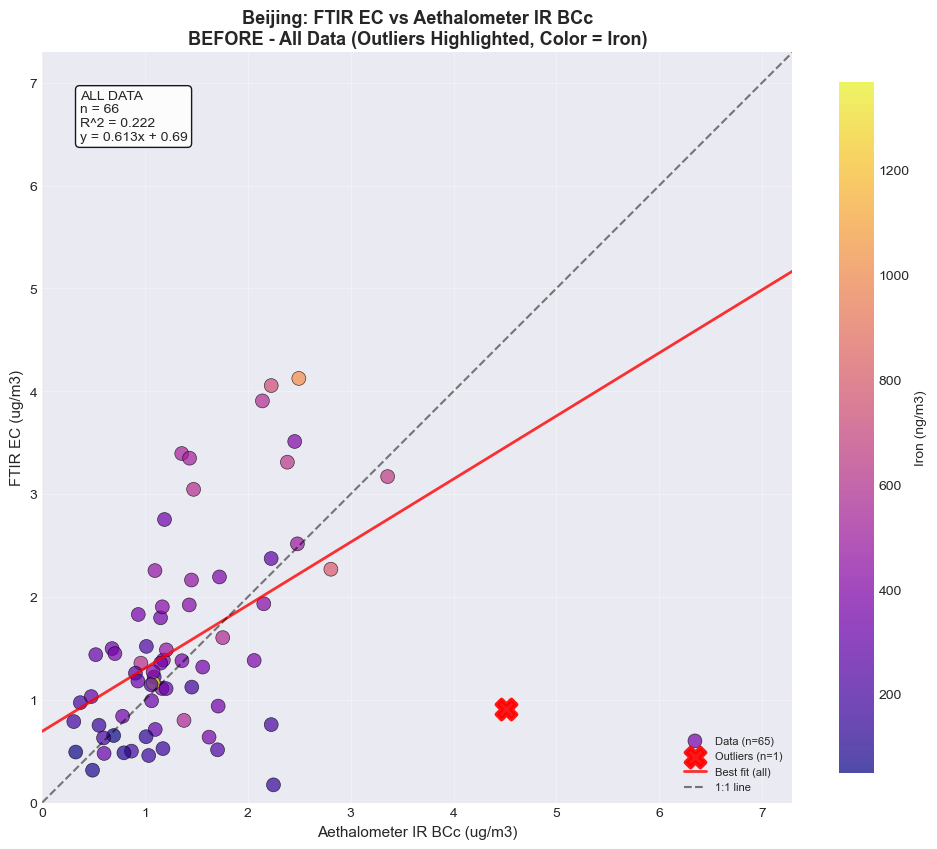

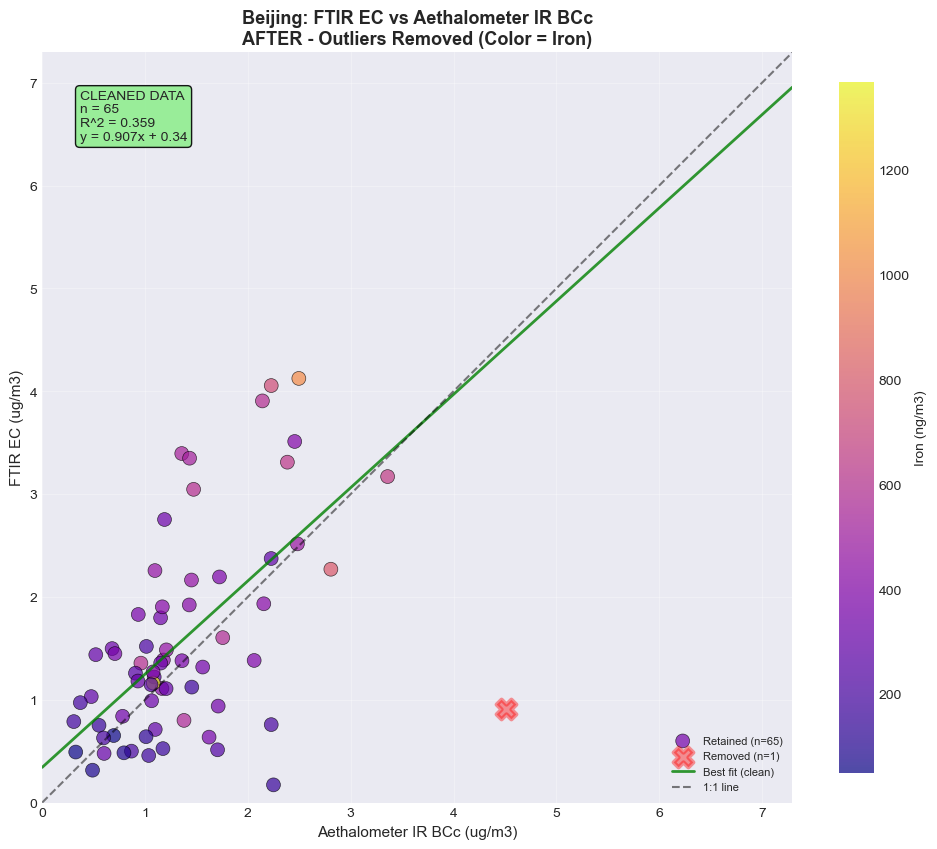


  FTIR EC vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.222 -> 0.359 (delta = +0.137)
    Slope: 0.613 -> 0.907


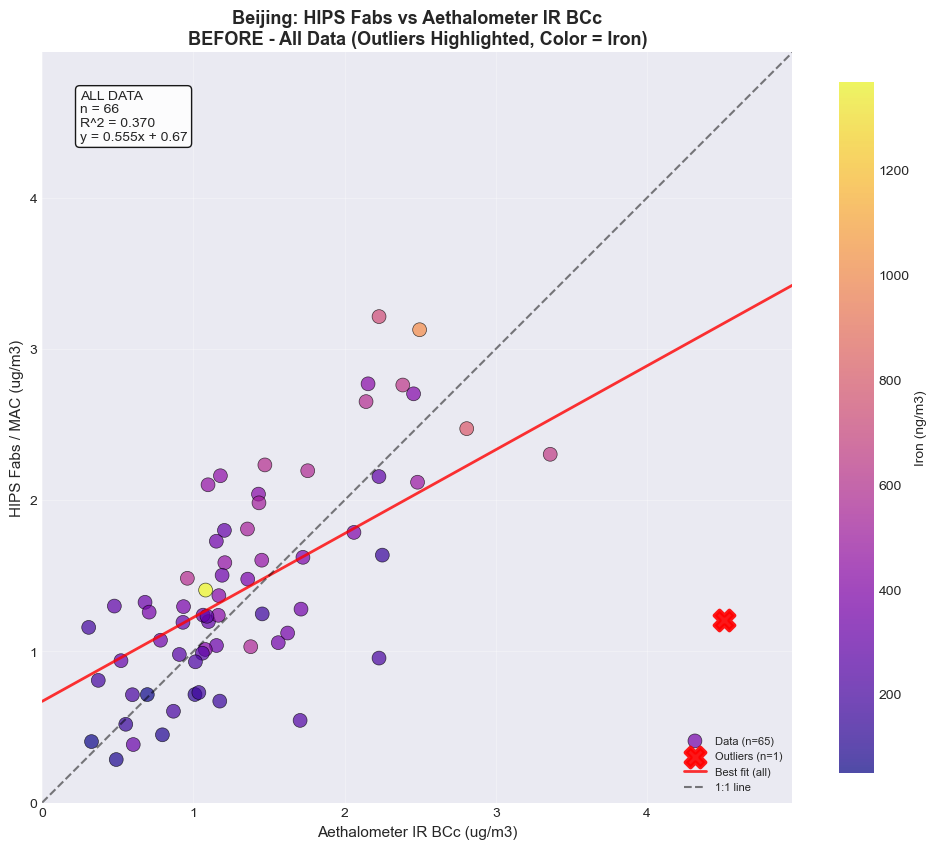

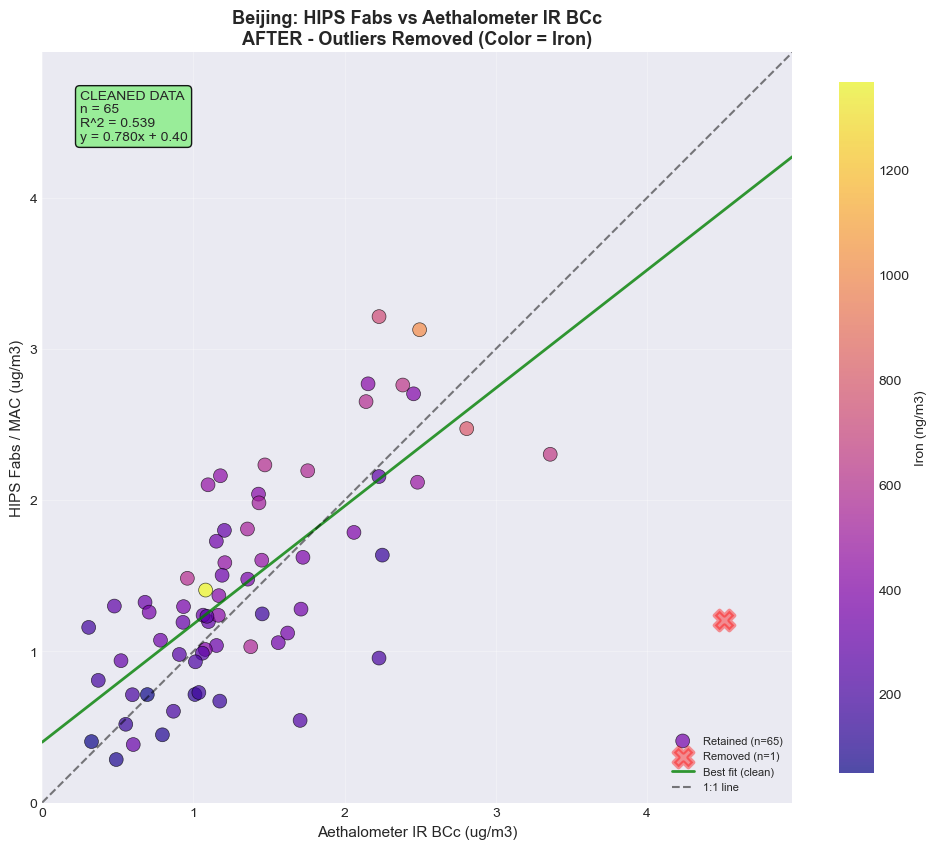


  HIPS Fabs vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.370 -> 0.539 (delta = +0.169)
    Slope: 0.555 -> 0.780


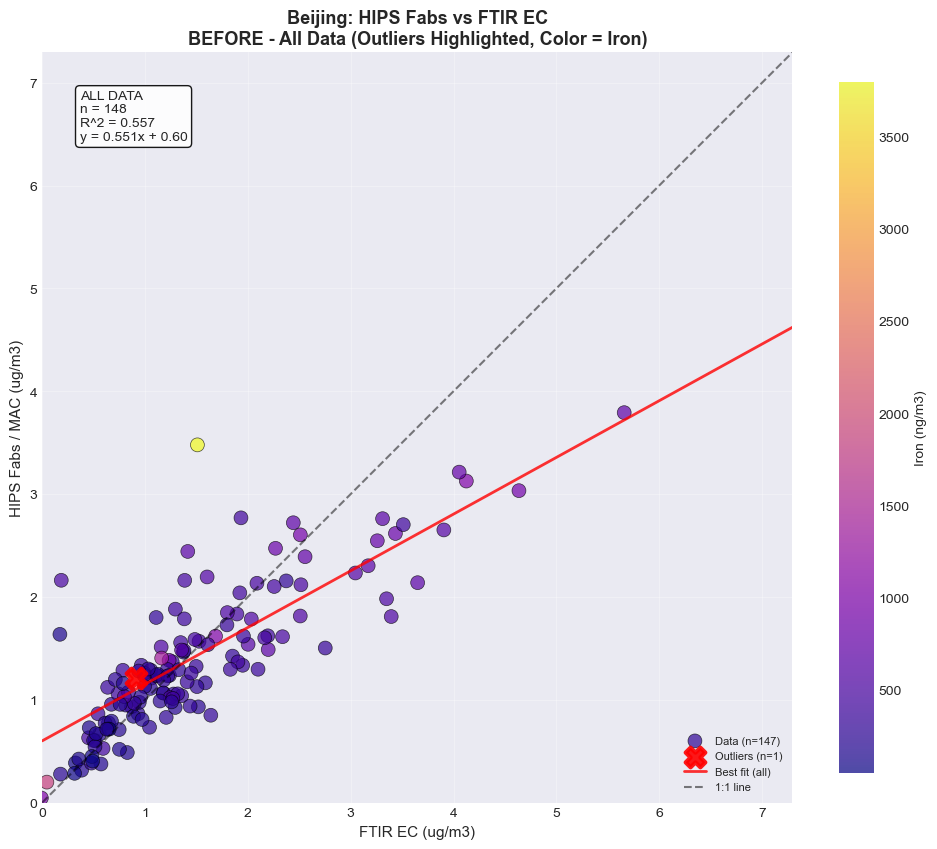

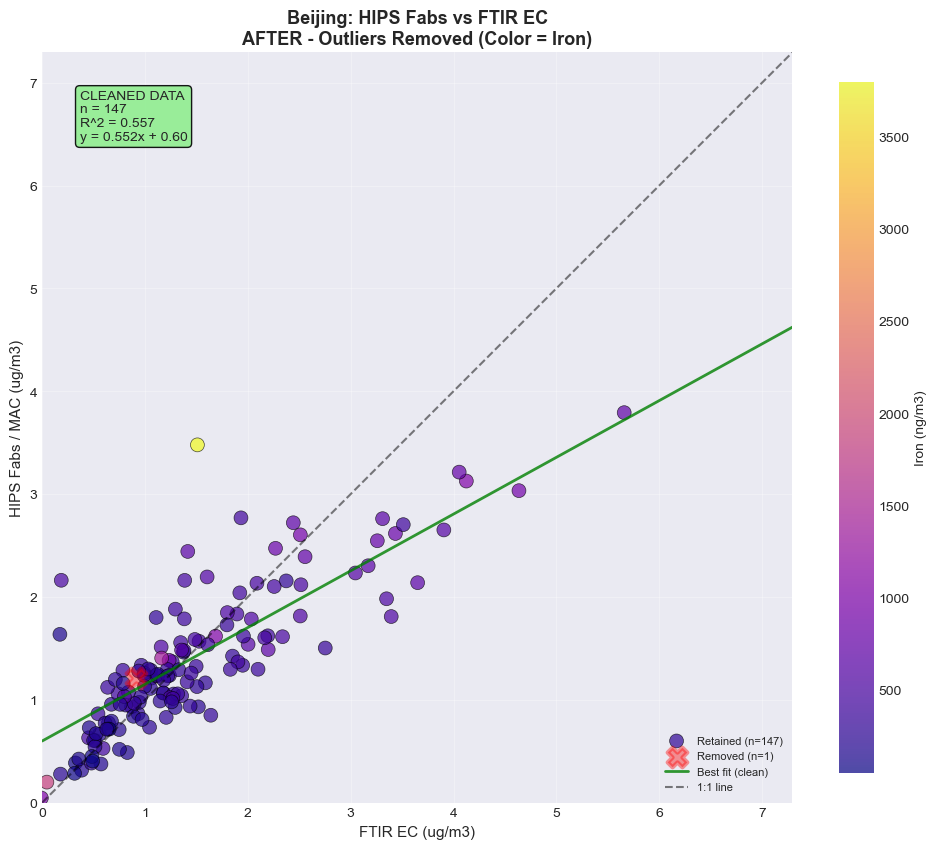


  HIPS Fabs vs FTIR EC - Impact of outlier removal:
    R^2: 0.557 -> 0.557 (delta = -0.000)
    Slope: 0.551 -> 0.552

Delhi: Iron Gradient Cross-Plots (Before/After Outlier Removal)
  Date-based exclusions: 0
  Threshold-based outliers: 2
  Total flagged: 2


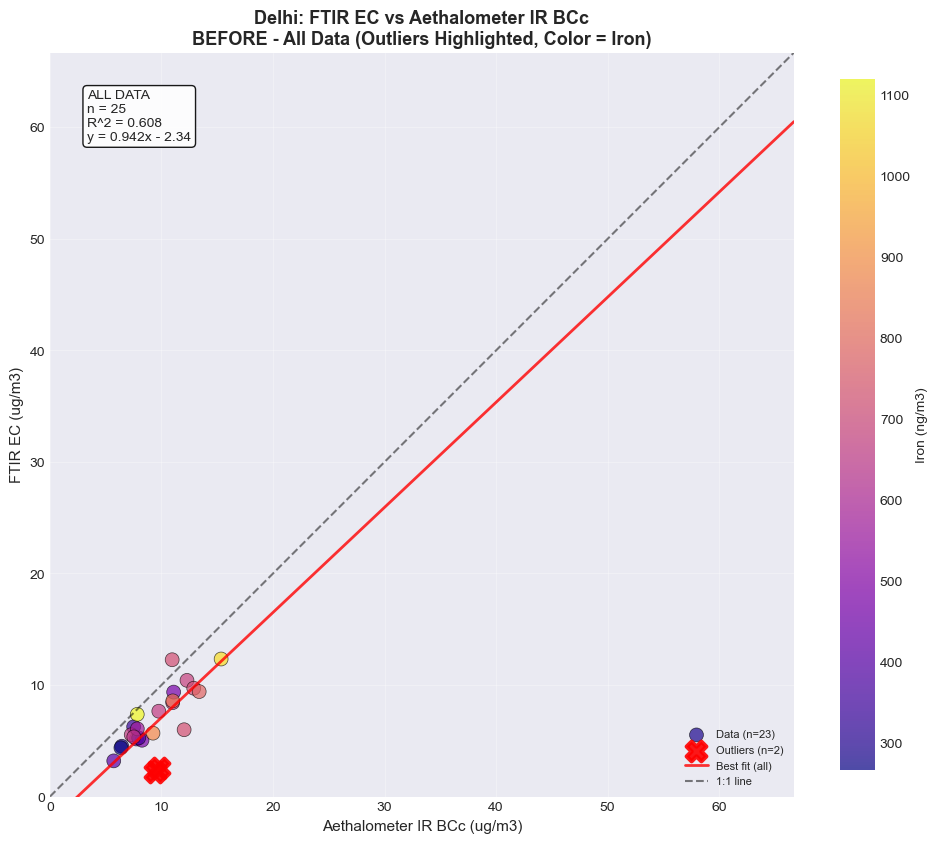

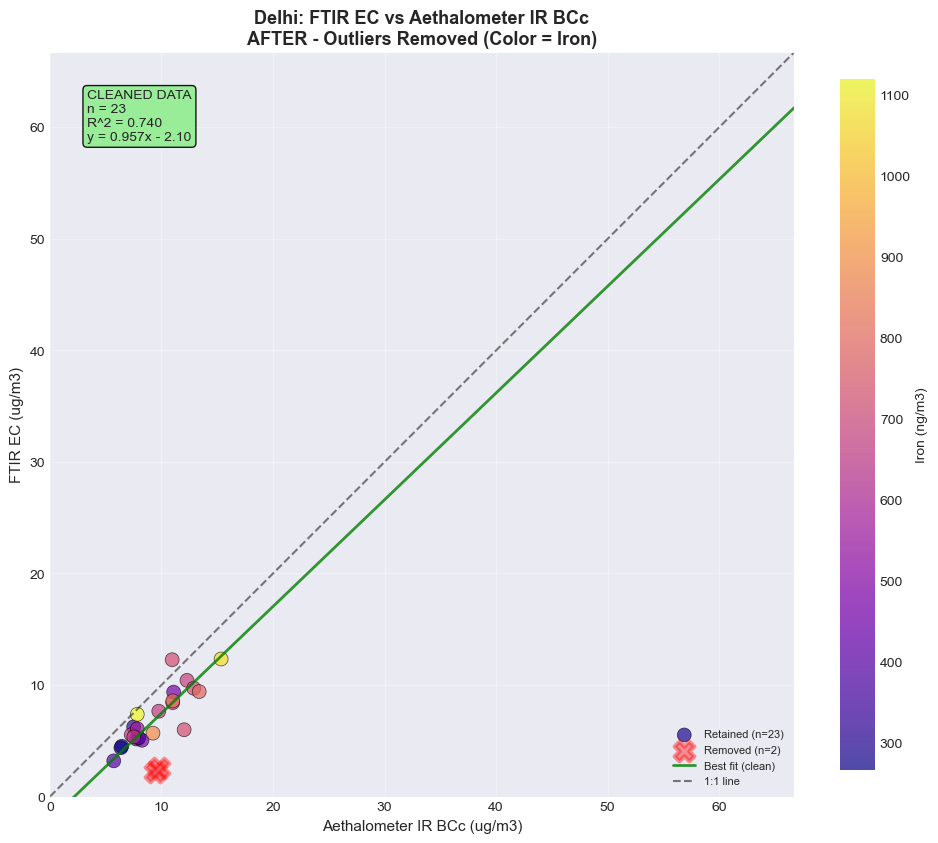


  FTIR EC vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.608 -> 0.740 (delta = +0.132)
    Slope: 0.942 -> 0.957


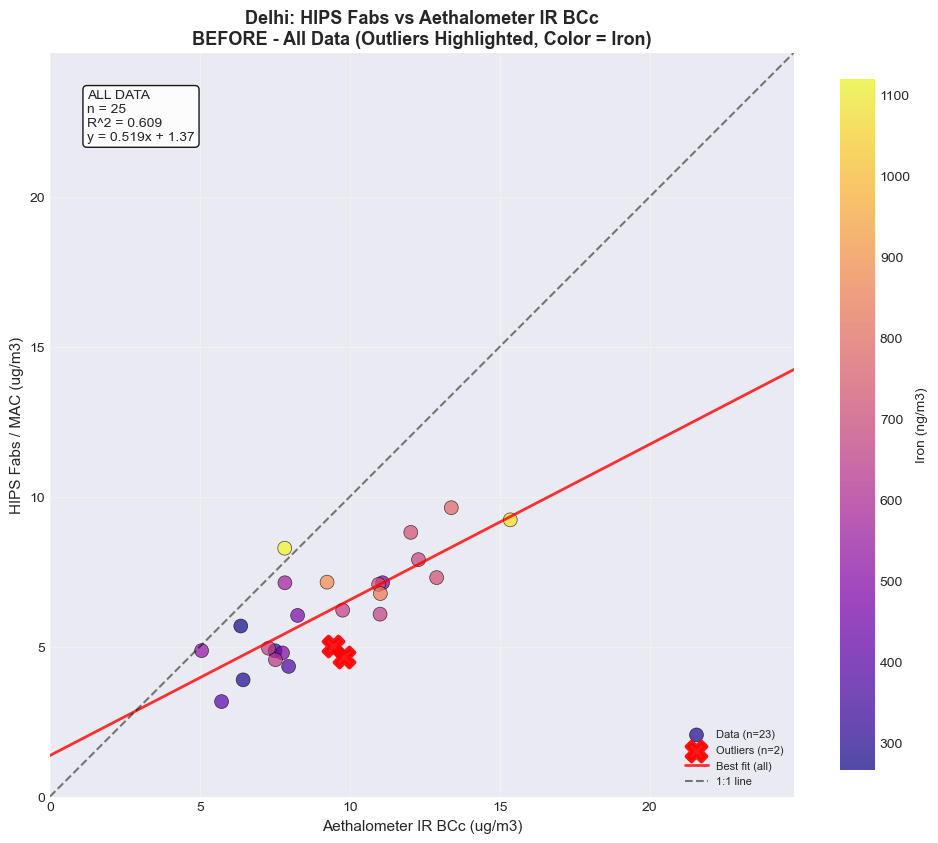

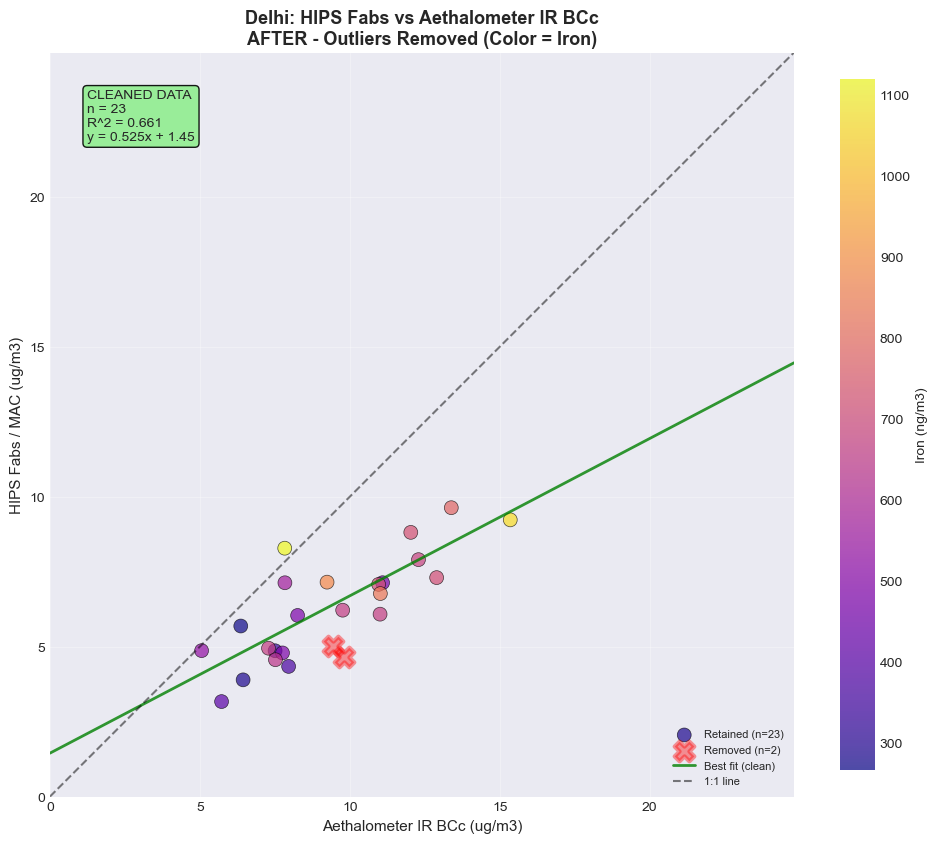


  HIPS Fabs vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.609 -> 0.661 (delta = +0.052)
    Slope: 0.519 -> 0.525


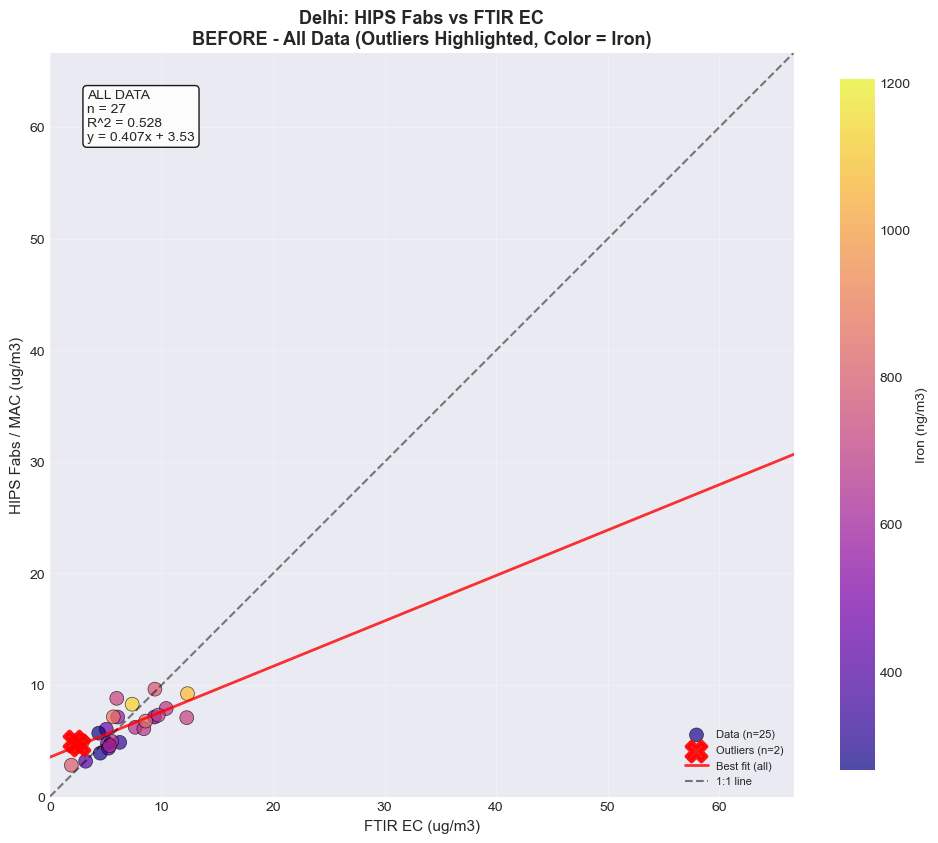

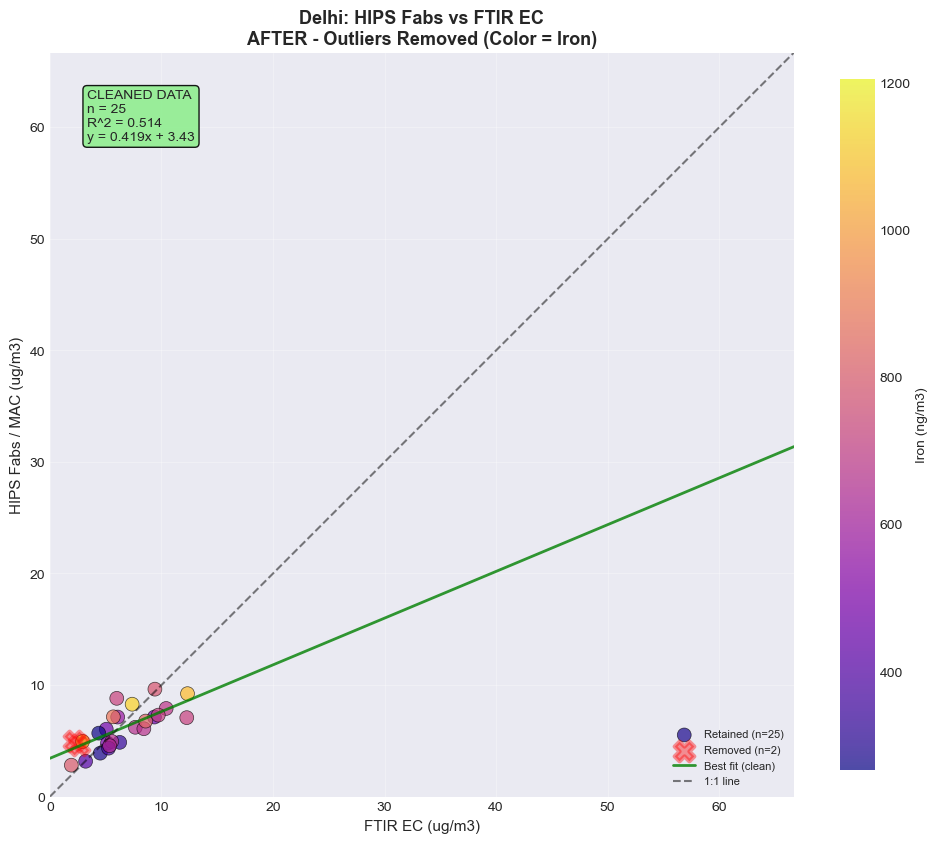


  HIPS Fabs vs FTIR EC - Impact of outlier removal:
    R^2: 0.528 -> 0.514 (delta = -0.014)
    Slope: 0.407 -> 0.419

JPL: Iron Gradient Cross-Plots (Before/After Outlier Removal)
  Date-based exclusions: 2
  Threshold-based outliers: 5
  Total flagged: 7


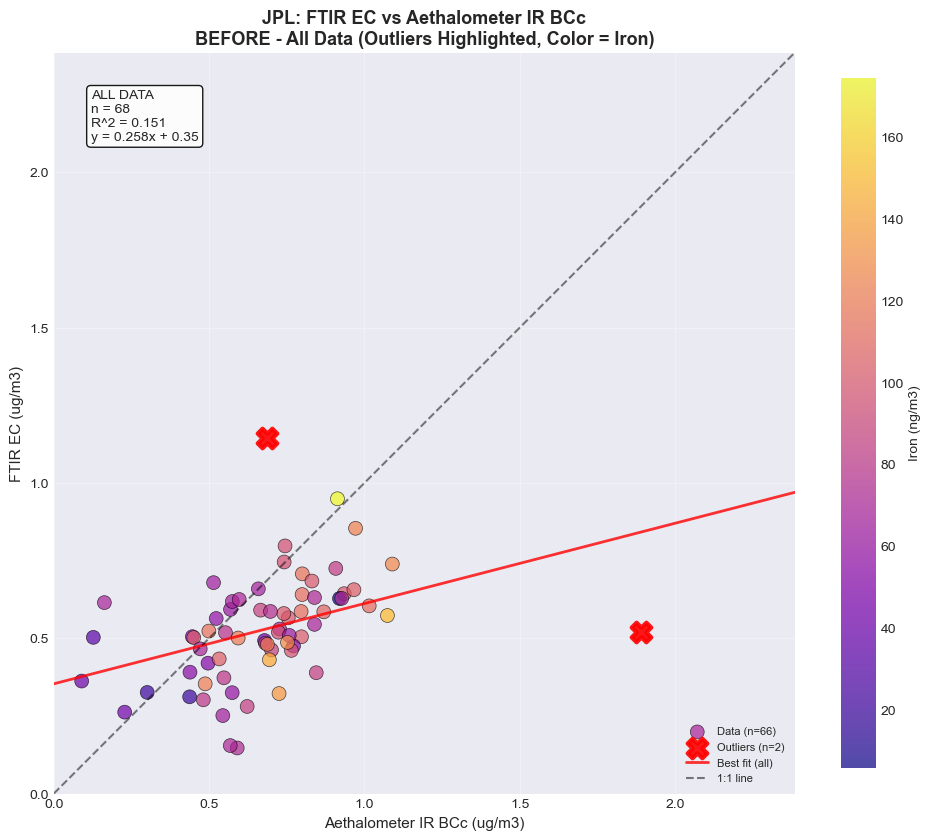

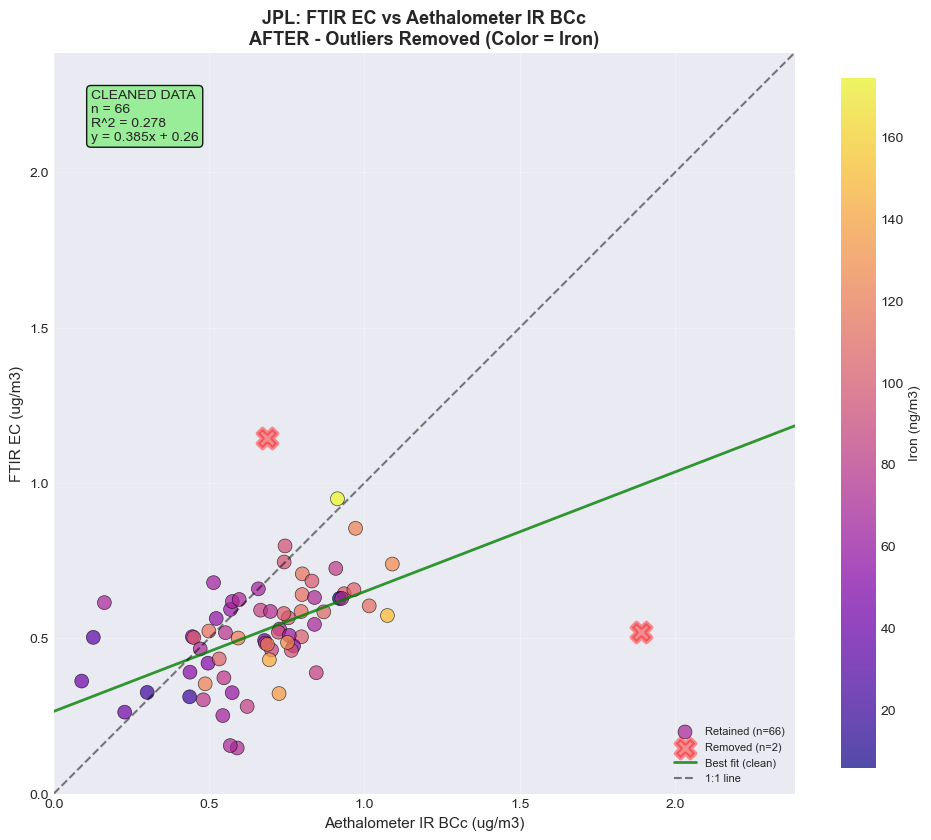


  FTIR EC vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.151 -> 0.278 (delta = +0.127)
    Slope: 0.258 -> 0.385


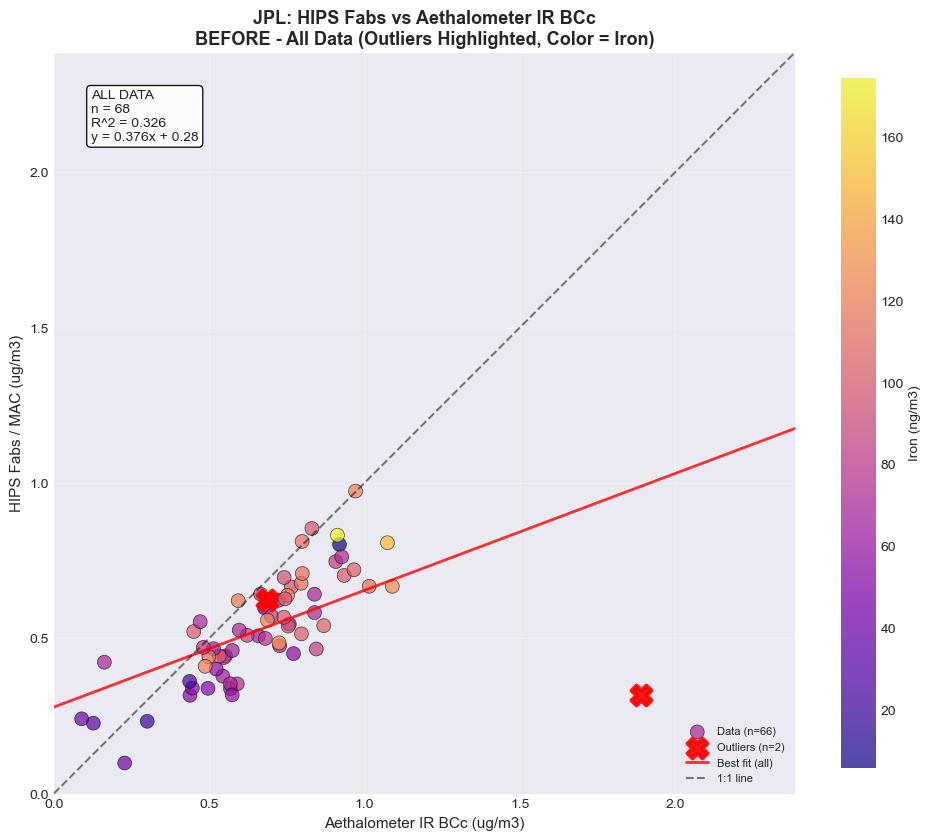

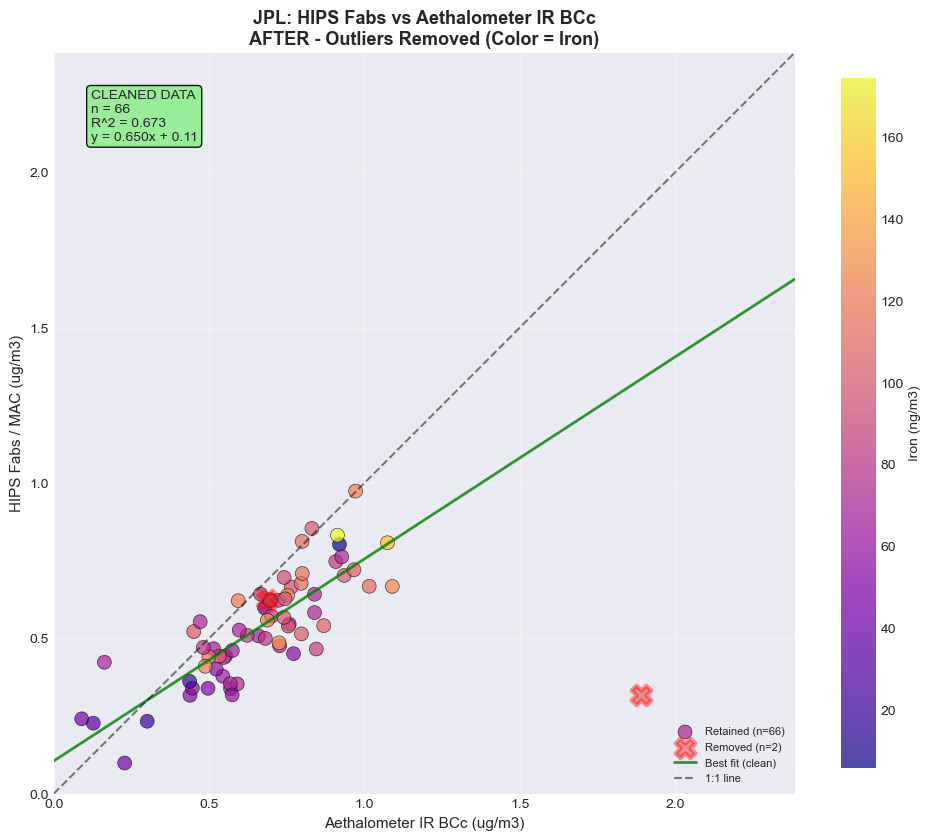


  HIPS Fabs vs Aethalometer IR BCc - Impact of outlier removal:
    R^2: 0.326 -> 0.673 (delta = +0.346)
    Slope: 0.376 -> 0.650


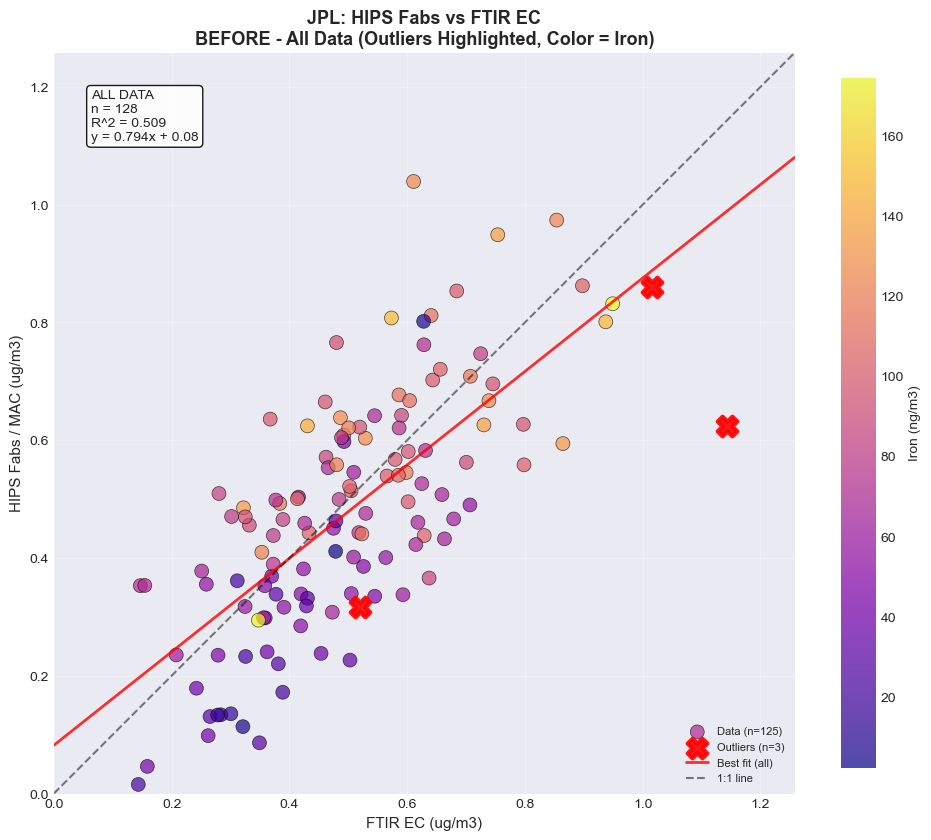

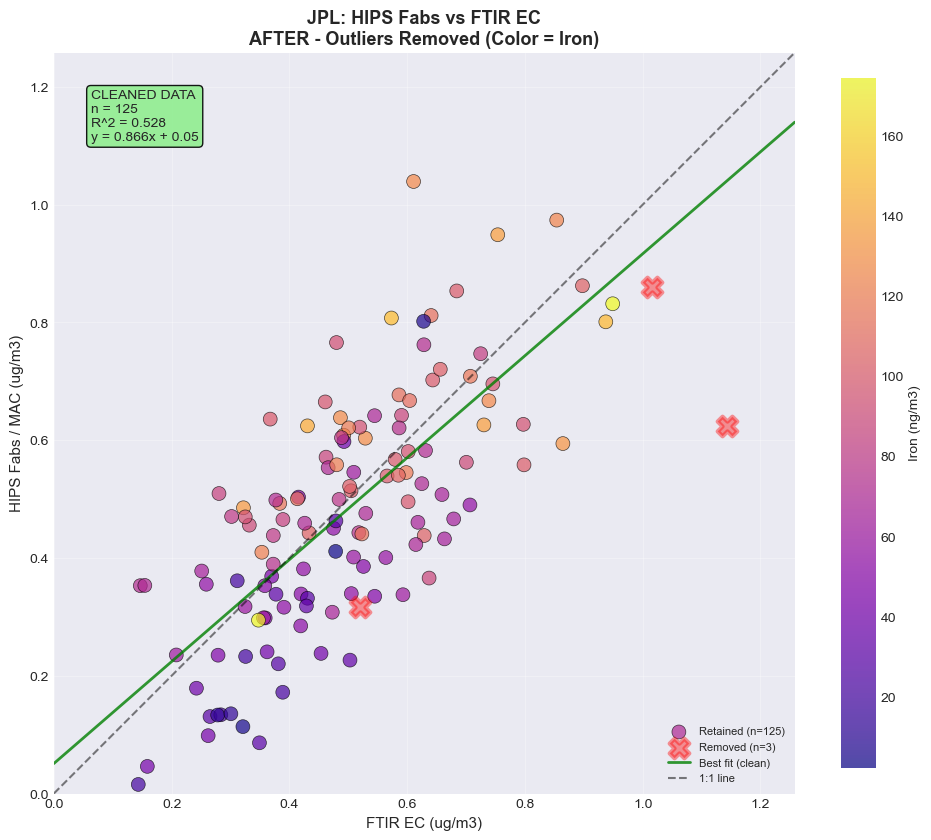


  HIPS Fabs vs FTIR EC - Impact of outlier removal:
    R^2: 0.509 -> 0.528 (delta = +0.018)
    Slope: 0.794 -> 0.866

Addis_Ababa: Iron Gradient Cross-Plots (Before/After Outlier Removal)
  Date-based exclusions: 0
  Threshold-based outliers: 0
  Total flagged: 0


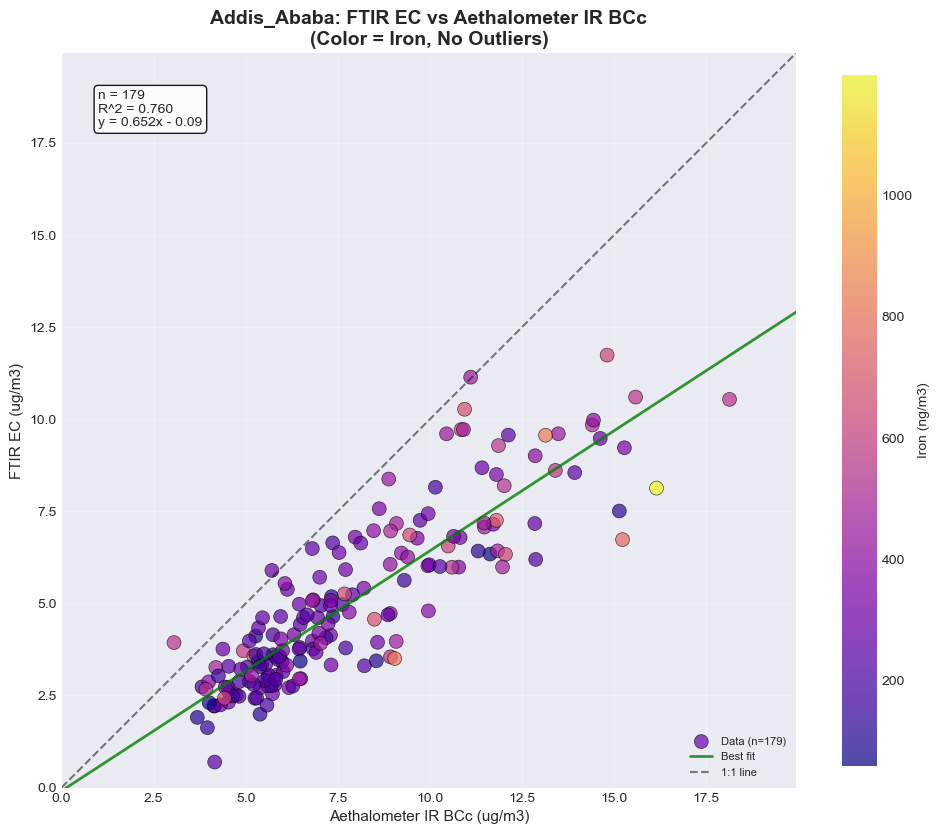

  FTIR EC vs Aethalometer IR BCc: R^2 = 0.760, n = 179


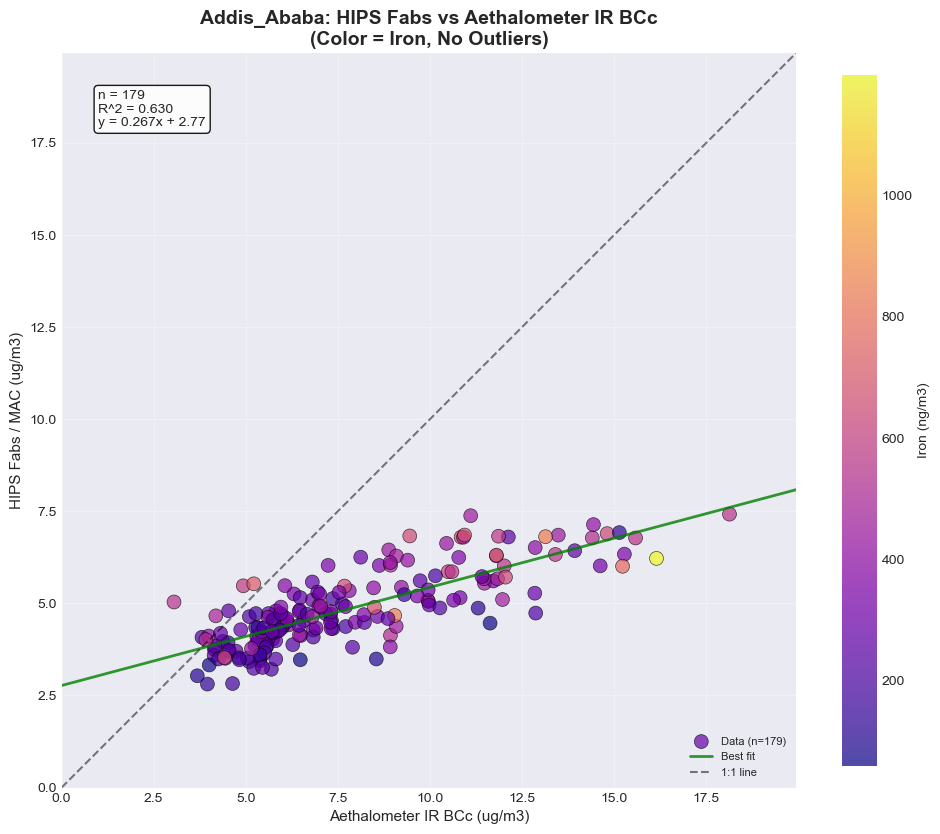

  HIPS Fabs vs Aethalometer IR BCc: R^2 = 0.630, n = 179


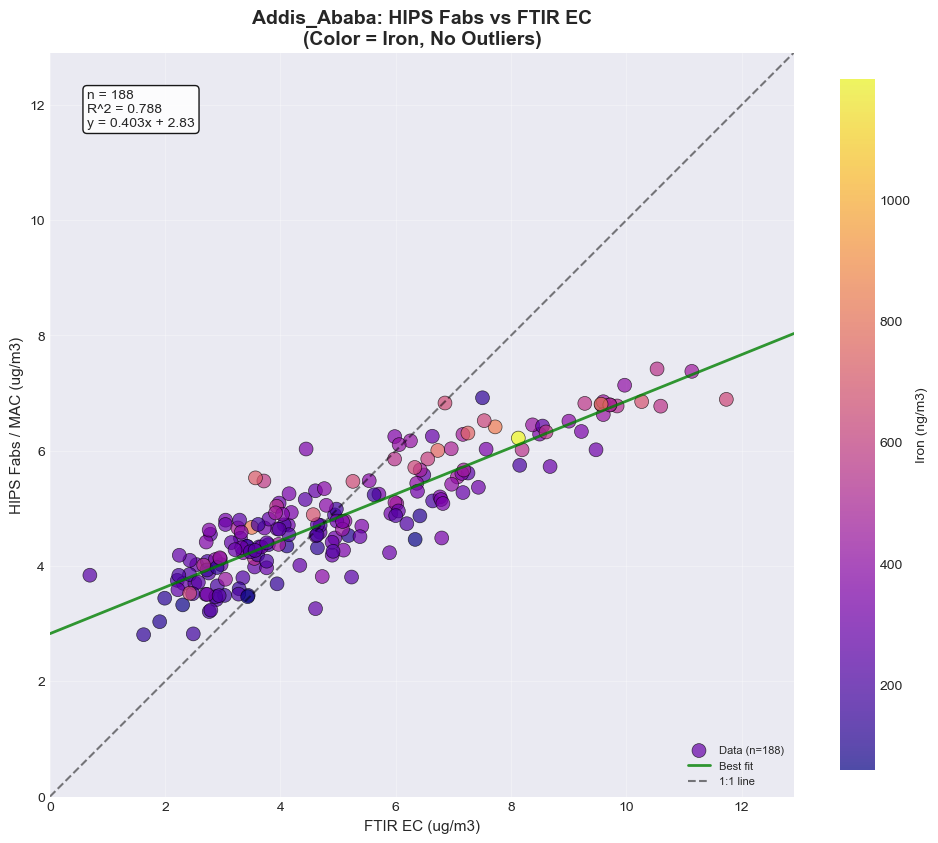

  HIPS Fabs vs FTIR EC: R^2 = 0.788, n = 188


In [29]:
# Create iron gradient cross-plots for each site with BEFORE/AFTER comparison
# Comparisons: FTIR EC vs Aeth, HIPS vs Aeth, HIPS vs FTIR EC

iron_gradient_comparisons = [
    {
        'name': 'FTIR EC vs Aethalometer IR BCc',
        'x_col': 'ir_bcc',
        'y_col': 'ftir_ec',
        'x_label': 'Aethalometer IR BCc (ug/m3)',
        'y_label': 'FTIR EC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs Aethalometer IR BCc',
        'x_col': 'ir_bcc',
        'y_col': 'hips_fabs',
        'x_label': 'Aethalometer IR BCc (ug/m3)',
        'y_label': 'HIPS Fabs / MAC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs FTIR EC',
        'x_col': 'ftir_ec',
        'y_col': 'hips_fabs',
        'x_label': 'FTIR EC (ug/m3)',
        'y_label': 'HIPS Fabs / MAC (ug/m3)',
        'equal_axes': True
    }
]

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Iron Gradient Cross-Plots (Before/After Outlier Removal)")
    print(f"{'='*60}")
    
    # Need to create outlier flags based on the columns we have
    # all_params_data has: ir_bcc (ug/m3), hips_fabs (ug/m3), ftir_ec (ug/m3), iron (ug/m3)
    # We need to convert to ng/m3 for threshold comparison or adjust thresholds
    
    matched_df = matched_df.copy()
    
    # Create temporary columns in ng/m3 for outlier detection (matching MANUAL_OUTLIERS thresholds)
    if 'ir_bcc' in matched_df.columns:
        matched_df['aeth_bc'] = matched_df['ir_bcc'] * 1000  # ug to ng
    if 'ftir_ec' in matched_df.columns:
        matched_df['filter_ec'] = matched_df['ftir_ec'] * 1000  # ug to ng
    
    # Apply both date-based exclusions AND threshold-based outlier flags
    matched_df = apply_exclusion_flags(matched_df, site_name)
    matched_df = apply_threshold_flags(matched_df, site_name)
    
    # Combine both flags into single outlier mask
    is_excluded = matched_df['is_excluded'].values if 'is_excluded' in matched_df.columns else np.zeros(len(matched_df), dtype=bool)
    is_outlier = matched_df['is_outlier'].values if 'is_outlier' in matched_df.columns else np.zeros(len(matched_df), dtype=bool)
    outlier_mask = is_excluded | is_outlier
    
    n_excluded = is_excluded.sum()
    n_outlier = is_outlier.sum()
    n_total = outlier_mask.sum()
    print(f"  Date-based exclusions: {n_excluded}")
    print(f"  Threshold-based outliers: {n_outlier}")
    print(f"  Total flagged: {n_total}")
    
    for comp in iron_gradient_comparisons:
        x_col = comp['x_col']
        y_col = comp['y_col']
        
        # Check if required columns exist
        if x_col not in matched_df.columns or y_col not in matched_df.columns:
            print(f"  {comp['name']}: Missing columns")
            continue
        
        if 'iron' not in matched_df.columns:
            print(f"  {comp['name']}: No iron data")
            continue
        
        # Check for sufficient data with iron values
        valid_mask = ((~np.isnan(matched_df[x_col].values)) & 
                      (~np.isnan(matched_df[y_col].values)) &
                      (~np.isnan(matched_df['iron'].values)))
        valid_count = valid_mask.sum()
        
        if valid_count < 3:
            print(f"  {comp['name']}: Insufficient data with iron (n={valid_count})")
            continue
        
        x_data = matched_df[x_col].values
        y_data = matched_df[y_col].values
        iron_data = matched_df['iron'].values
        
        # Calculate axis limits (same for both plots)
        all_vals = np.concatenate([
            x_data[~np.isnan(x_data)],
            y_data[~np.isnan(y_data)]
        ])
        max_val = all_vals.max() * 1.1 if len(all_vals) > 0 else 100
        
        # Check if there are any outliers for this comparison
        valid_outliers = valid_mask & outlier_mask
        
        if not valid_outliers.any():
            # No outliers - just show single plot with iron gradient
            fig, ax = plt.subplots(figsize=(10, 9))
            
            stats, _ = plot_crossplot_iron_gradient(
                ax,
                x_data,
                y_data,
                iron_data,
                comp['x_label'],
                comp['y_label'],
                equal_axes=comp['equal_axes'],
                outlier_mask=None,
                cmap='plasma'
            )
            
            ax.set_title(f"{site_name}: {comp['name']}\n(Color = Iron, No Outliers)", 
                         fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            if stats:
                print(f"  {comp['name']}: R^2 = {stats['r_squared']:.3f}, n = {stats['n']}")
            continue
        
        # ---- BEFORE: All Data with Iron Gradient (Outliers Highlighted) ----
        fig, ax = plt.subplots(figsize=(10, 9))
        
        # Get clean and outlier masks for valid data
        clean_valid = valid_mask & ~outlier_mask
        outlier_valid = valid_mask & outlier_mask
        
        # Plot clean data with iron gradient
        scatter = ax.scatter(x_data[clean_valid], y_data[clean_valid], 
                            c=iron_data[clean_valid], cmap='plasma',
                            alpha=0.7, s=100, edgecolors='black', linewidth=0.5,
                            label=f'Data (n={clean_valid.sum()})')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Iron (ng/m3)', fontsize=10)
        
        # Plot outliers as red X
        ax.scatter(x_data[outlier_valid], y_data[outlier_valid],
                   color='red', alpha=0.9, s=200, marker='X', linewidths=3,
                   label=f'Outliers (n={outlier_valid.sum()})')
        
        # Regression on ALL valid data (including outliers)
        x_all = x_data[valid_mask]
        y_all = y_data[valid_mask]
        stats_all = calculate_regression_stats(x_all, y_all)
        
        if stats_all:
            x_line = np.array([0, max_val])
            y_line = stats_all['slope'] * x_line + stats_all['intercept']
            ax.plot(x_line, y_line, 'r-', linewidth=2, alpha=0.8, label='Best fit (all)')
            
            sign = '+' if stats_all['intercept'] >= 0 else '-'
            eq = f"y = {stats_all['slope']:.3f}x {sign} {abs(stats_all['intercept']):.2f}"
            stats_text = f"ALL DATA\nn = {stats_all['n']}\nR^2 = {stats_all['r_squared']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        ax.set_xlabel(comp['x_label'], fontsize=11)
        ax.set_ylabel(comp['y_label'], fontsize=11)
        ax.set_title(f"{site_name}: {comp['name']}\nBEFORE - All Data (Outliers Highlighted, Color = Iron)", 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # ---- AFTER: Outliers Removed with Iron Gradient ----
        fig, ax = plt.subplots(figsize=(10, 9))
        
        # Plot clean data with iron gradient
        scatter = ax.scatter(x_data[clean_valid], y_data[clean_valid], 
                            c=iron_data[clean_valid], cmap='plasma',
                            alpha=0.7, s=100, edgecolors='black', linewidth=0.5,
                            label=f'Retained (n={clean_valid.sum()})')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Iron (ng/m3)', fontsize=10)
        
        # Show removed points as red X (faded)
        ax.scatter(x_data[outlier_valid], y_data[outlier_valid],
                   color='red', alpha=0.4, s=200, marker='X', linewidths=3,
                   label=f'Removed (n={outlier_valid.sum()})')
        
        # Regression on CLEAN data only
        x_clean = x_data[clean_valid]
        y_clean = y_data[clean_valid]
        stats_clean = calculate_regression_stats(x_clean, y_clean)
        
        if stats_clean:
            x_line = np.array([0, max_val])
            y_line = stats_clean['slope'] * x_line + stats_clean['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit (clean)')
            
            sign = '+' if stats_clean['intercept'] >= 0 else '-'
            eq = f"y = {stats_clean['slope']:.3f}x {sign} {abs(stats_clean['intercept']):.2f}"
            stats_text = f"CLEANED DATA\nn = {stats_clean['n']}\nR^2 = {stats_clean['r_squared']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        ax.set_xlabel(comp['x_label'], fontsize=11)
        ax.set_ylabel(comp['y_label'], fontsize=11)
        ax.set_title(f"{site_name}: {comp['name']}\nAFTER - Outliers Removed (Color = Iron)", 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Print impact
        if stats_all and stats_clean:
            print(f"\n  {comp['name']} - Impact of outlier removal:")
            print(f"    R^2: {stats_all['r_squared']:.3f} -> {stats_clean['r_squared']:.3f} "
                  f"(delta = {stats_clean['r_squared'] - stats_all['r_squared']:+.3f})")
            print(f"    Slope: {stats_all['slope']:.3f} -> {stats_clean['slope']:.3f}")

### 3b. Fe/EC Ratio Gradient Cross-Plots

The Fe/EC ratio (Iron / FTIR EC) may be more relevant than absolute iron concentration for identifying dust interference, as it normalizes for overall pollution levels. Higher Fe/EC ratios indicate relatively more dust contribution compared to combustion sources.

Fe/EC RATIO GRADIENT CROSS-PLOTS

Higher Fe/EC ratio = relatively more dust vs combustion sources
Color scale shows Fe/EC ratio (iron / FTIR EC)


Beijing: Fe/EC Ratio Gradient Cross-Plots
  Fe/EC ratio statistics (x1000):
    n = 171
    Mean = -185417.36
    Median = 260696.30
    Min = -130343722.11, Max = 40175061.14


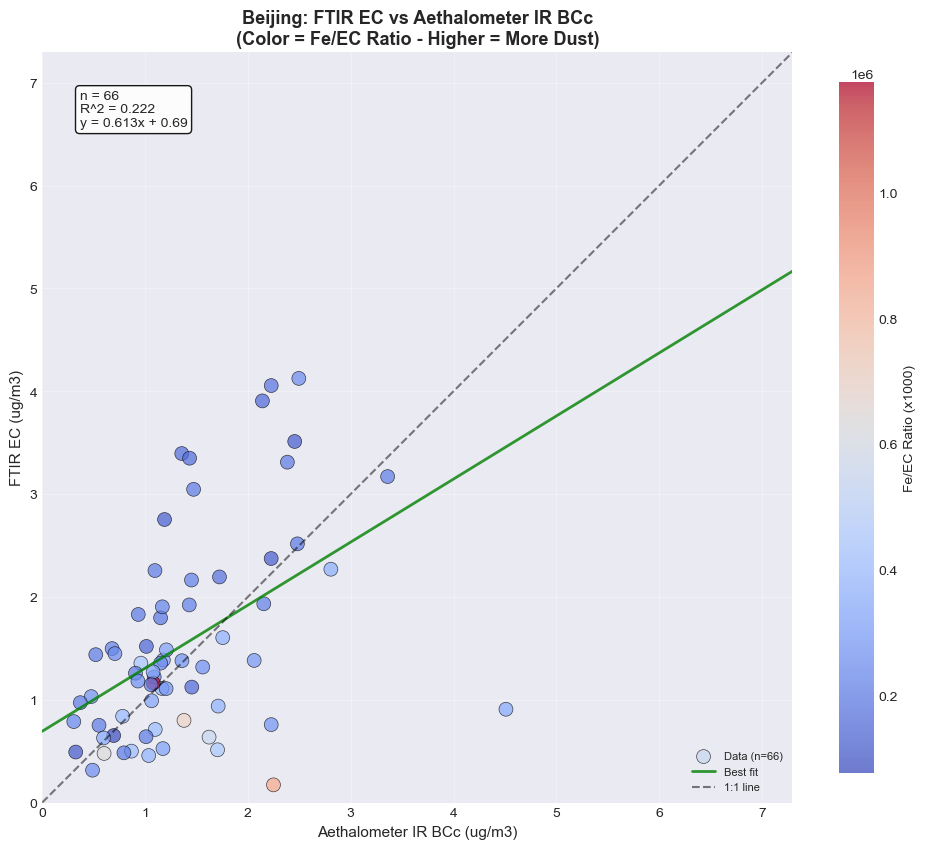

  FTIR EC vs Aethalometer IR BCc: R^2 = 0.222, n = 66
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.429
    -> Higher Fe/EC associated with negative deviation (y < x)


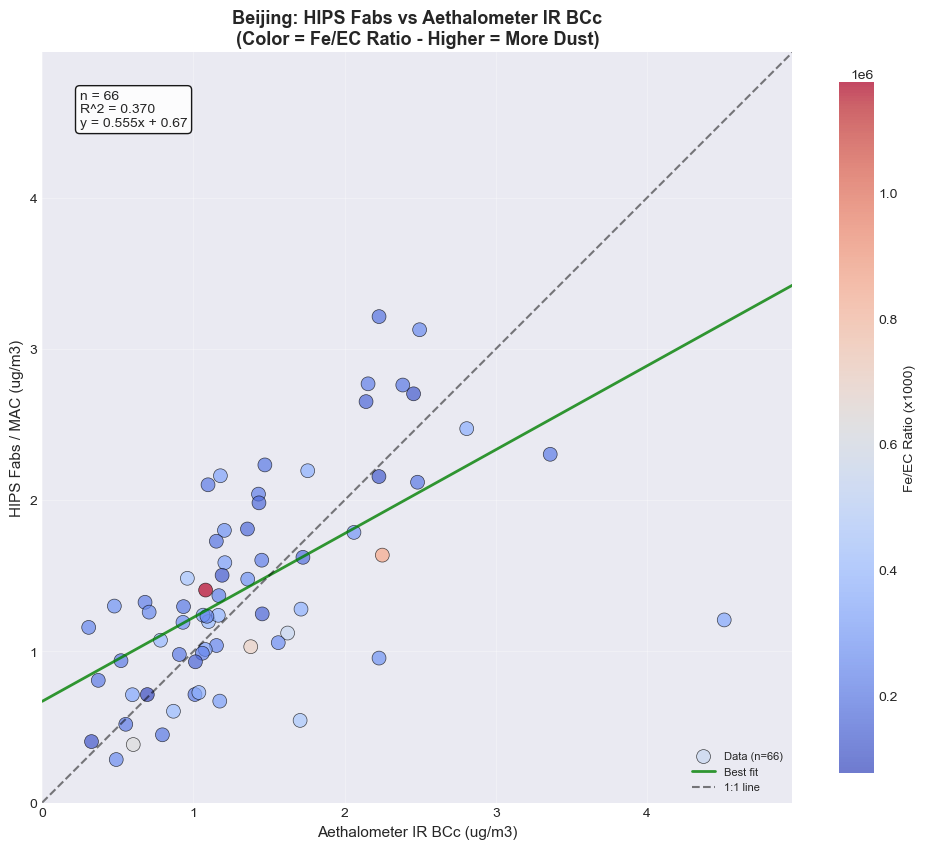

  HIPS Fabs vs Aethalometer IR BCc: R^2 = 0.370, n = 66
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.191


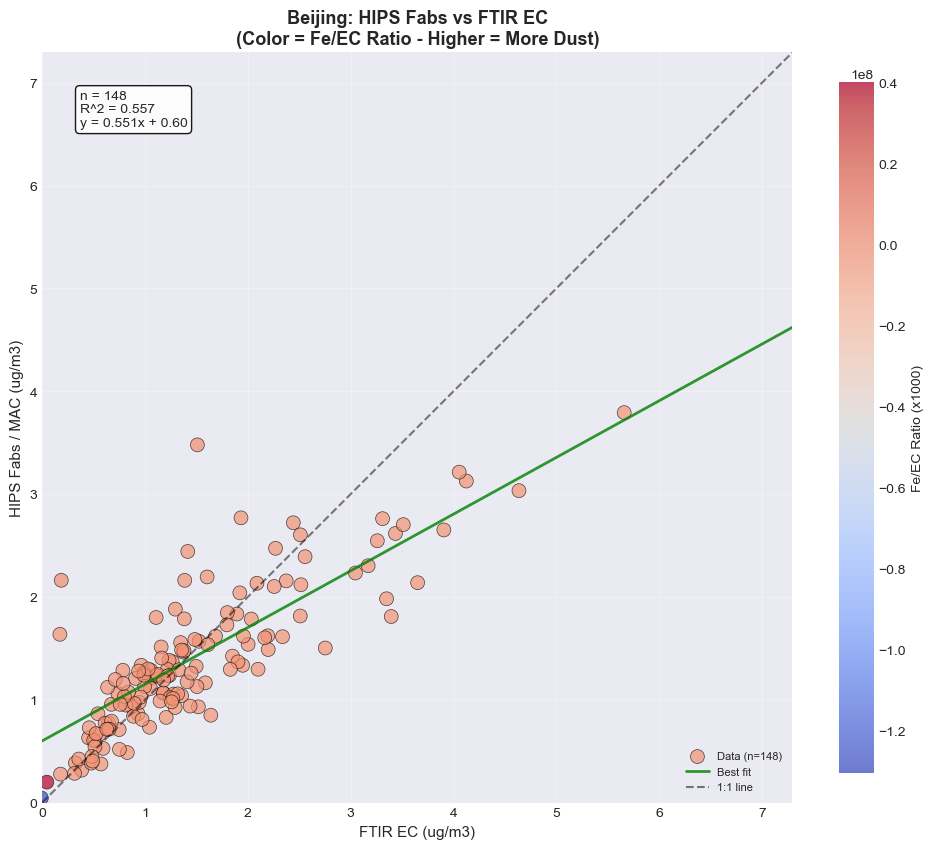

  HIPS Fabs vs FTIR EC: R^2 = 0.557, n = 148
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.001

Delhi: Fe/EC Ratio Gradient Cross-Plots
  Fe/EC ratio statistics (x1000):
    n = 27
    Mean = 105626.39
    Median = 92470.29
    Min = -561805.79, Max = 416592.27


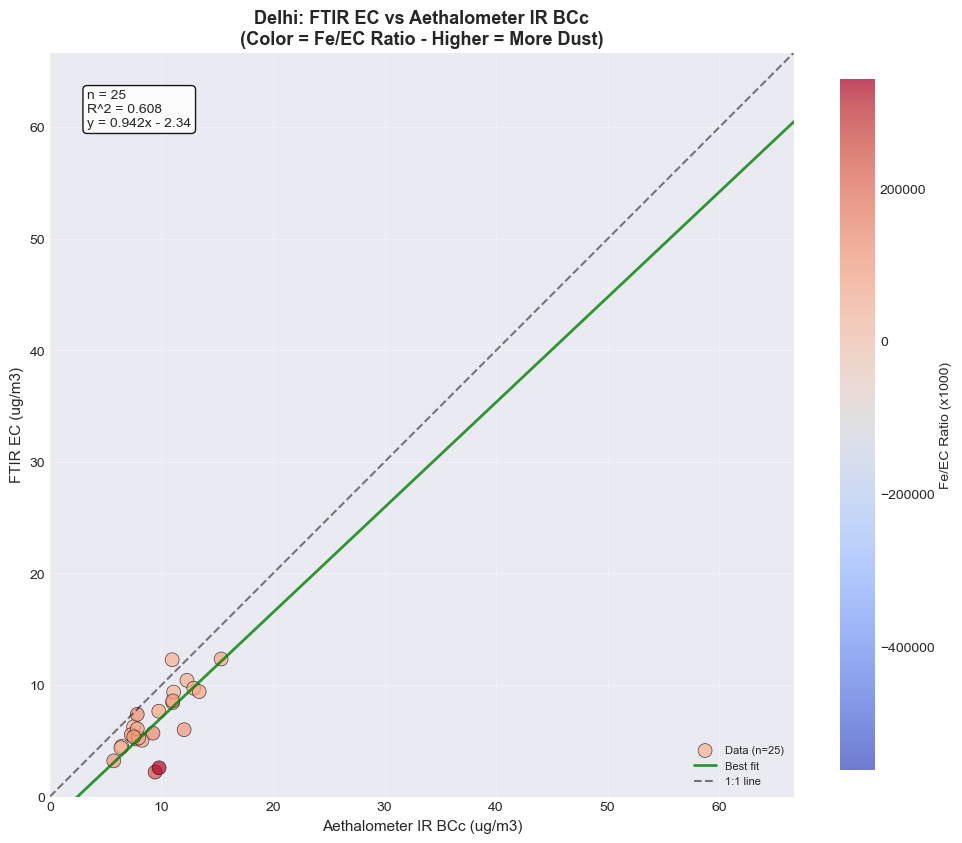

  FTIR EC vs Aethalometer IR BCc: R^2 = 0.608, n = 25
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.000


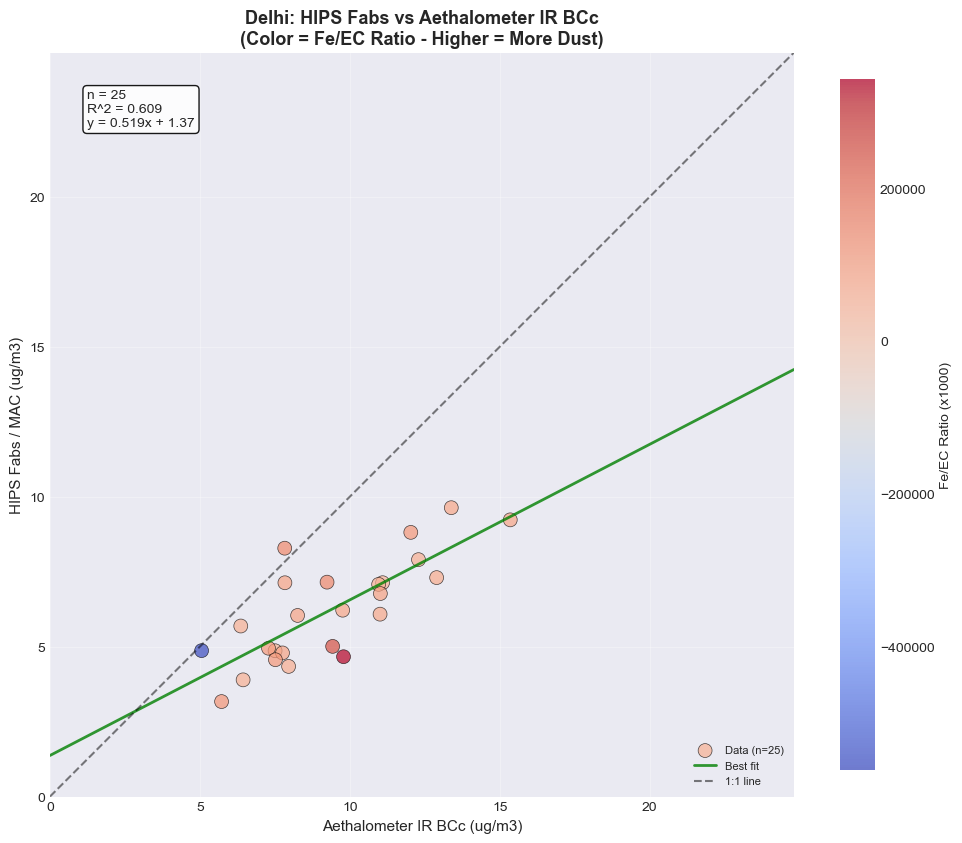

  HIPS Fabs vs Aethalometer IR BCc: R^2 = 0.609, n = 25
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.375
    -> Higher Fe/EC associated with negative deviation (y < x)


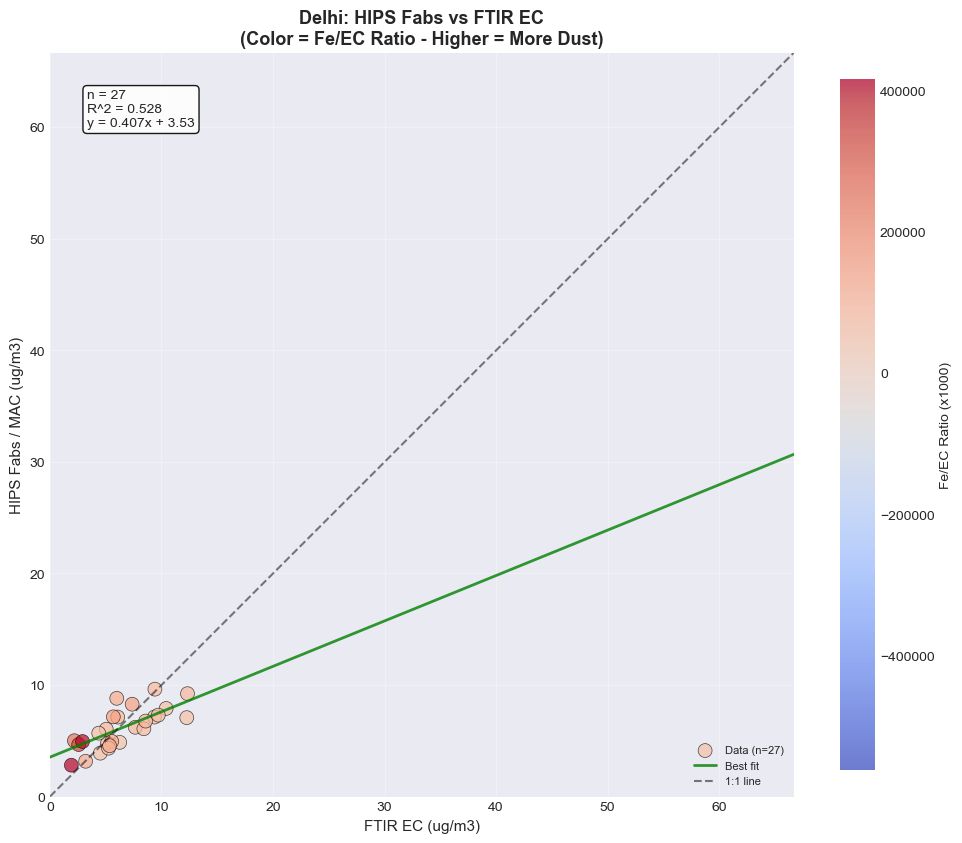

  HIPS Fabs vs FTIR EC: R^2 = 0.528, n = 27
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.117

JPL: Fe/EC Ratio Gradient Cross-Plots
  Fe/EC ratio statistics (x1000):
    n = 156
    Mean = 171946.34
    Median = 156090.10
    Min = -171966.18, Max = 659397.83


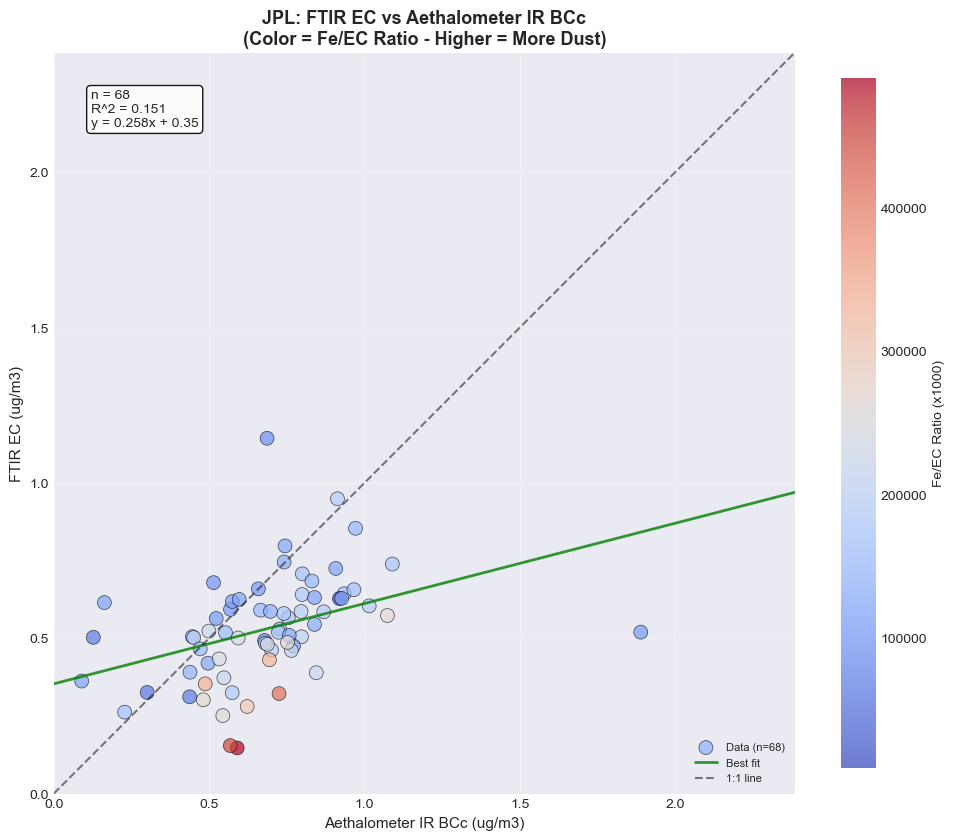

  FTIR EC vs Aethalometer IR BCc: R^2 = 0.151, n = 68
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.349
    -> Higher Fe/EC associated with negative deviation (y < x)


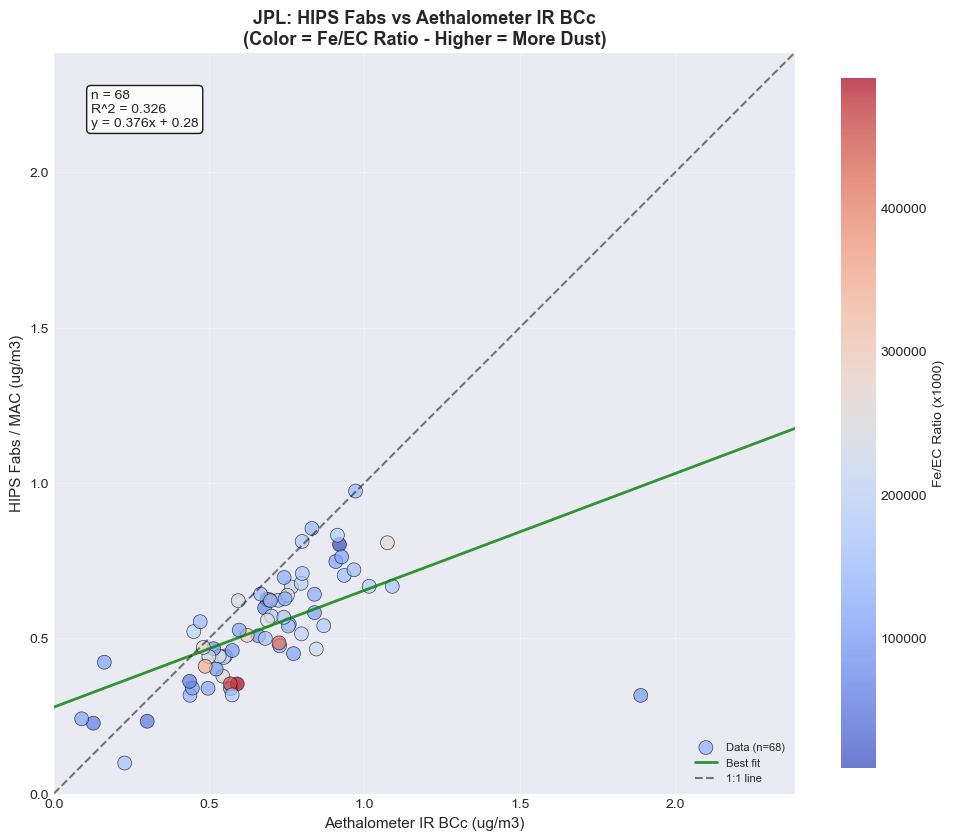

  HIPS Fabs vs Aethalometer IR BCc: R^2 = 0.326, n = 68
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.030


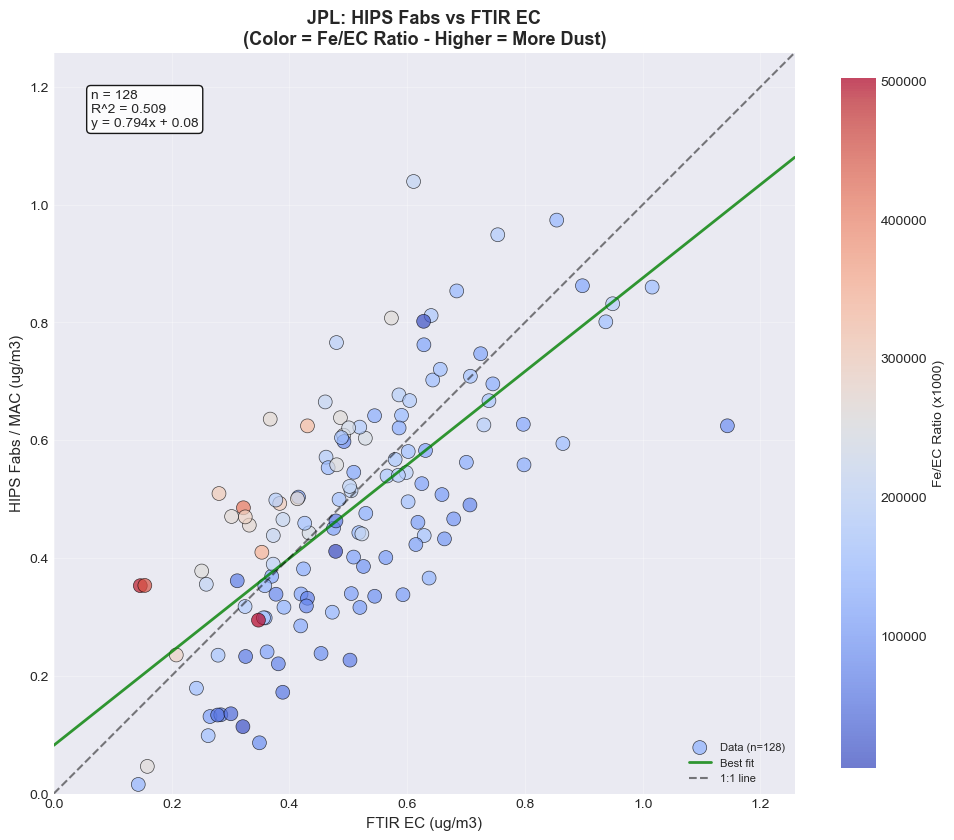

  HIPS Fabs vs FTIR EC: R^2 = 0.509, n = 128
    Correlation between Fe/EC ratio and residuals from 1:1: r = 0.550
    -> Higher Fe/EC associated with positive deviation (y > x)

Addis_Ababa: Fe/EC Ratio Gradient Cross-Plots
  Fe/EC ratio statistics (x1000):
    n = 188
    Mean = 73562.46
    Median = 65586.55
    Min = 9429.81, Max = 341213.32


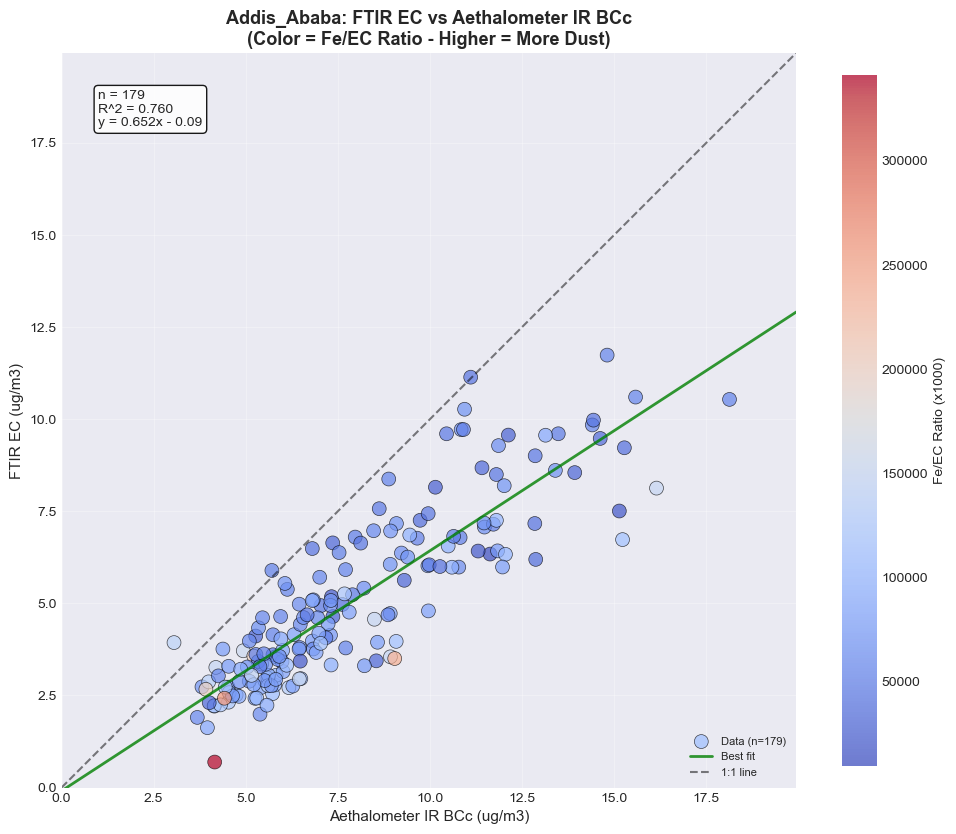

  FTIR EC vs Aethalometer IR BCc: R^2 = 0.760, n = 179
    Correlation between Fe/EC ratio and residuals from 1:1: r = -0.011


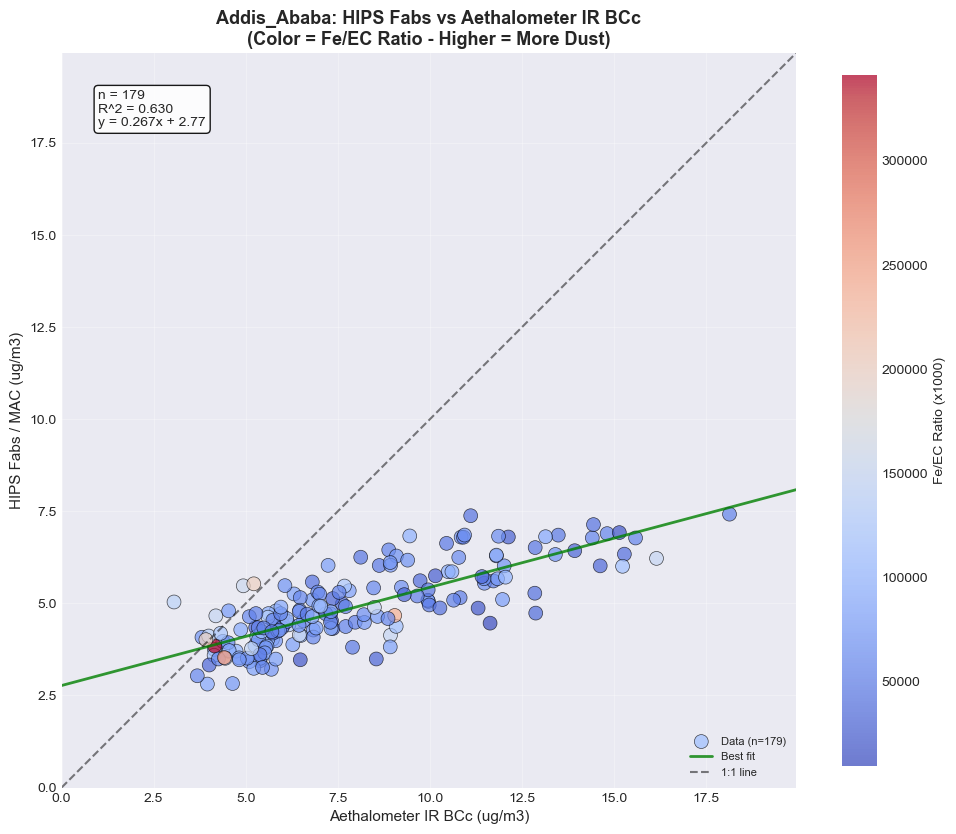

  HIPS Fabs vs Aethalometer IR BCc: R^2 = 0.630, n = 179
    Correlation between Fe/EC ratio and residuals from 1:1: r = 0.315
    -> Higher Fe/EC associated with positive deviation (y > x)


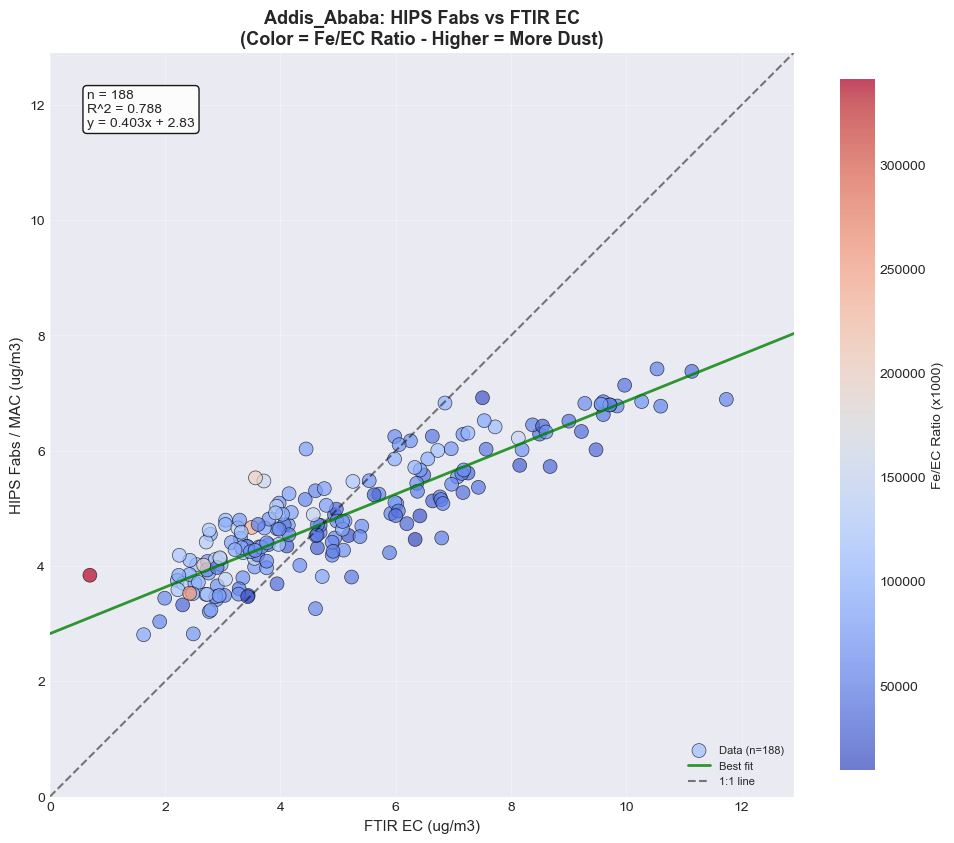

  HIPS Fabs vs FTIR EC: R^2 = 0.788, n = 188
    Correlation between Fe/EC ratio and residuals from 1:1: r = 0.505
    -> Higher Fe/EC associated with positive deviation (y > x)


In [30]:
# Fe/EC Ratio Gradient Cross-Plots for each site
# Fe/EC ratio normalizes iron by EC, highlighting relative dust contribution

print("="*80)
print("Fe/EC RATIO GRADIENT CROSS-PLOTS")
print("="*80)
print("\nHigher Fe/EC ratio = relatively more dust vs combustion sources")
print("Color scale shows Fe/EC ratio (iron / FTIR EC)")
print()

fe_ec_comparisons = [
    {
        'name': 'FTIR EC vs Aethalometer IR BCc',
        'x_col': 'ir_bcc',
        'y_col': 'ftir_ec',
        'x_label': 'Aethalometer IR BCc (ug/m3)',
        'y_label': 'FTIR EC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs Aethalometer IR BCc',
        'x_col': 'ir_bcc',
        'y_col': 'hips_fabs',
        'x_label': 'Aethalometer IR BCc (ug/m3)',
        'y_label': 'HIPS Fabs / MAC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs FTIR EC',
        'x_col': 'ftir_ec',
        'y_col': 'hips_fabs',
        'x_label': 'FTIR EC (ug/m3)',
        'y_label': 'HIPS Fabs / MAC (ug/m3)',
        'equal_axes': True
    }
]

for site_name, matched_df in all_params_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Fe/EC Ratio Gradient Cross-Plots")
    print(f"{'='*60}")
    
    matched_df = matched_df.copy()
    
    # Check if we have iron and ftir_ec for Fe/EC ratio calculation
    if 'iron' not in matched_df.columns or 'ftir_ec' not in matched_df.columns:
        print(f"  Missing iron or ftir_ec data for Fe/EC ratio calculation")
        continue
    
    # Calculate Fe/EC ratio (both in ug/m3, so ratio is dimensionless)
    # Multiply by 1000 to get a more readable scale (Fe is typically much smaller than EC)
    matched_df['fe_ec_ratio'] = (matched_df['iron'] / matched_df['ftir_ec']) * 1000
    
    # Print Fe/EC ratio statistics
    valid_ratio = matched_df['fe_ec_ratio'].dropna()
    if len(valid_ratio) > 0:
        print(f"  Fe/EC ratio statistics (x1000):")
        print(f"    n = {len(valid_ratio)}")
        print(f"    Mean = {valid_ratio.mean():.2f}")
        print(f"    Median = {valid_ratio.median():.2f}")
        print(f"    Min = {valid_ratio.min():.2f}, Max = {valid_ratio.max():.2f}")
    
    for comp in fe_ec_comparisons:
        x_col = comp['x_col']
        y_col = comp['y_col']
        
        # Check if required columns exist
        if x_col not in matched_df.columns or y_col not in matched_df.columns:
            print(f"  {comp['name']}: Missing columns")
            continue
        
        # Check for sufficient data with Fe/EC ratio values
        valid_mask = ((~np.isnan(matched_df[x_col].values)) & 
                      (~np.isnan(matched_df[y_col].values)) &
                      (~np.isnan(matched_df['fe_ec_ratio'].values)))
        valid_count = valid_mask.sum()
        
        if valid_count < 3:
            print(f"  {comp['name']}: Insufficient data with Fe/EC ratio (n={valid_count})")
            continue
        
        x_data = matched_df[x_col].values
        y_data = matched_df[y_col].values
        fe_ec_data = matched_df['fe_ec_ratio'].values
        
        # Calculate axis limits
        all_vals = np.concatenate([
            x_data[~np.isnan(x_data)],
            y_data[~np.isnan(y_data)]
        ])
        max_val = all_vals.max() * 1.1 if len(all_vals) > 0 else 100
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 9))
        
        # Get valid data
        x_valid = x_data[valid_mask]
        y_valid = y_data[valid_mask]
        fe_ec_valid = fe_ec_data[valid_mask]
        
        # Plot with Fe/EC ratio as color gradient (using 'coolwarm' - blue=low, red=high)
        scatter = ax.scatter(x_valid, y_valid, c=fe_ec_valid, cmap='coolwarm',
                            alpha=0.7, s=100, edgecolors='black', linewidth=0.5,
                            label=f'Data (n={len(x_valid)})')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
        cbar.set_label('Fe/EC Ratio (x1000)', fontsize=10)
        
        # Calculate regression
        stats = calculate_regression_stats(x_valid, y_valid)
        
        if stats:
            # Regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
            stats_text = f"n = {stats['n']}\nR^2 = {stats['r_squared']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel(comp['x_label'], fontsize=11)
        ax.set_ylabel(comp['y_label'], fontsize=11)
        ax.set_title(f"{site_name}: {comp['name']}\n(Color = Fe/EC Ratio - Higher = More Dust)", 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        if stats:
            print(f"  {comp['name']}: R^2 = {stats['r_squared']:.3f}, n = {stats['n']}")
        
        # Check for correlation between Fe/EC ratio and residuals from 1:1 line
        residuals = y_valid - x_valid  # Deviation from 1:1 line
        if len(residuals) >= 3:
            residual_corr = np.corrcoef(fe_ec_valid, residuals)[0, 1]
            print(f"    Correlation between Fe/EC ratio and residuals from 1:1: r = {residual_corr:.3f}")
            if abs(residual_corr) > 0.3:
                if residual_corr > 0:
                    print(f"    -> Higher Fe/EC associated with positive deviation (y > x)")
                else:
                    print(f"    -> Higher Fe/EC associated with negative deviation (y < x)")

---

## 4. Multi-Site Comparison Plots (All Sites Including Addis Ababa)

Combine all sites on single plots for direct comparison. Each site has its own color, and outliers are shown with consistent red X markers.

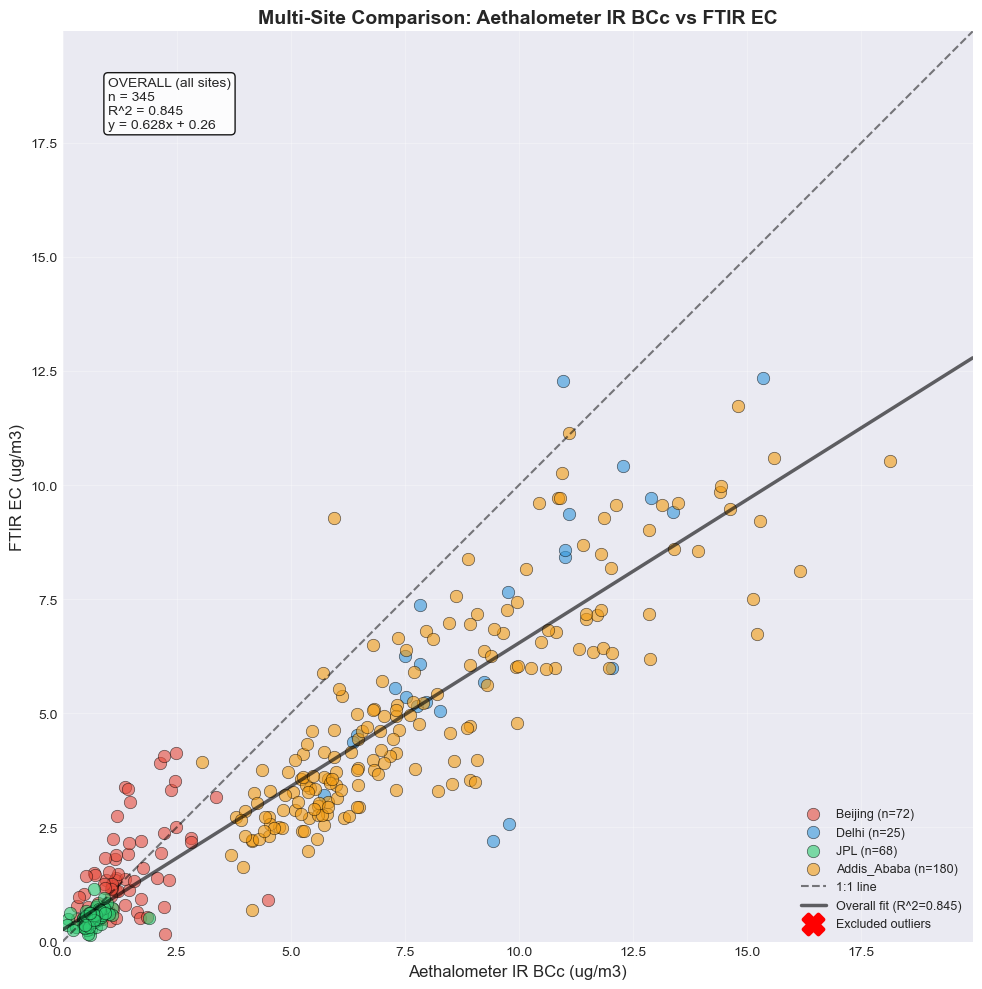


Aethalometer IR BCc vs FTIR EC - Site Statistics:
Site                   n        R^2      Slope
---------------------------------------------
Beijing               72      0.227      0.606
Delhi                 25      0.608      0.942
JPL                   68      0.151      0.258
Addis_Ababa          180      0.734      0.646
---------------------------------------------
OVERALL              345      0.845      0.628



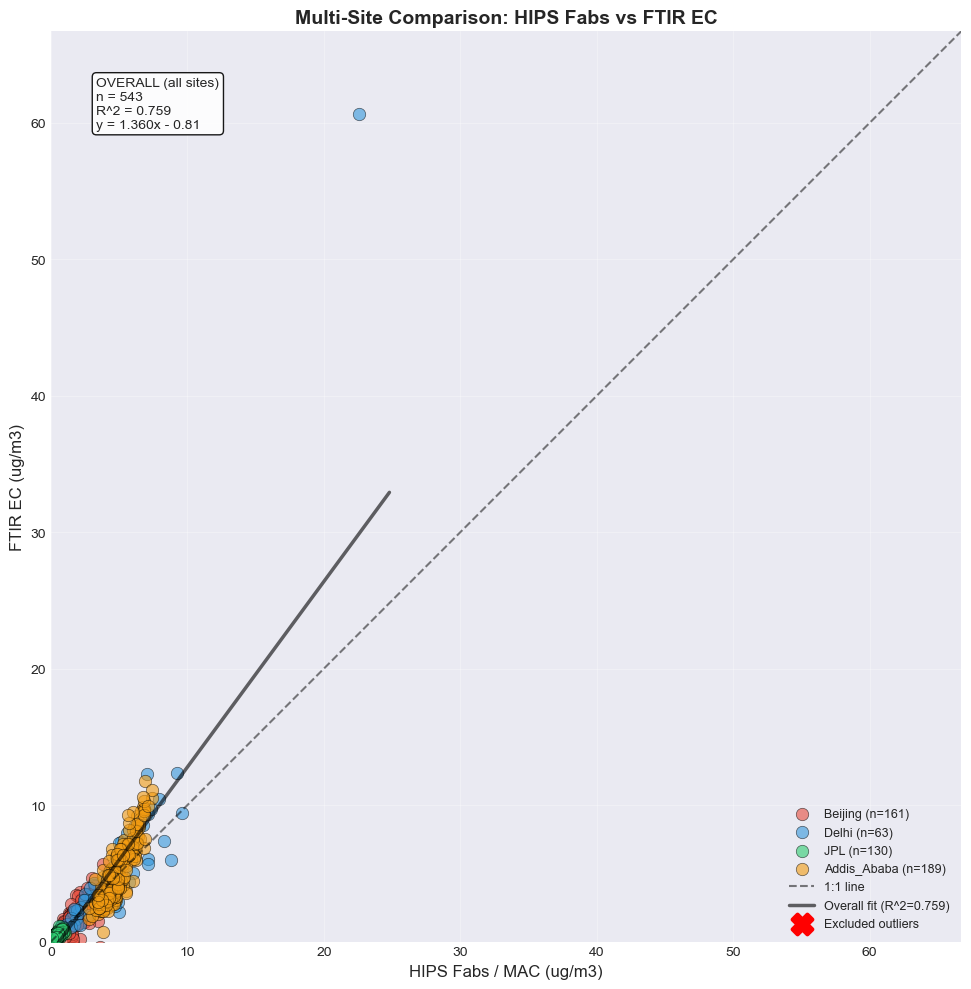


HIPS Fabs vs FTIR EC - Site Statistics:
Site                   n        R^2      Slope
---------------------------------------------
Beijing              161      0.541      0.971
Delhi                 63      0.764      1.998
JPL                  130      0.522      0.641
Addis_Ababa          189      0.784      1.963
---------------------------------------------
OVERALL              543      0.759      1.360



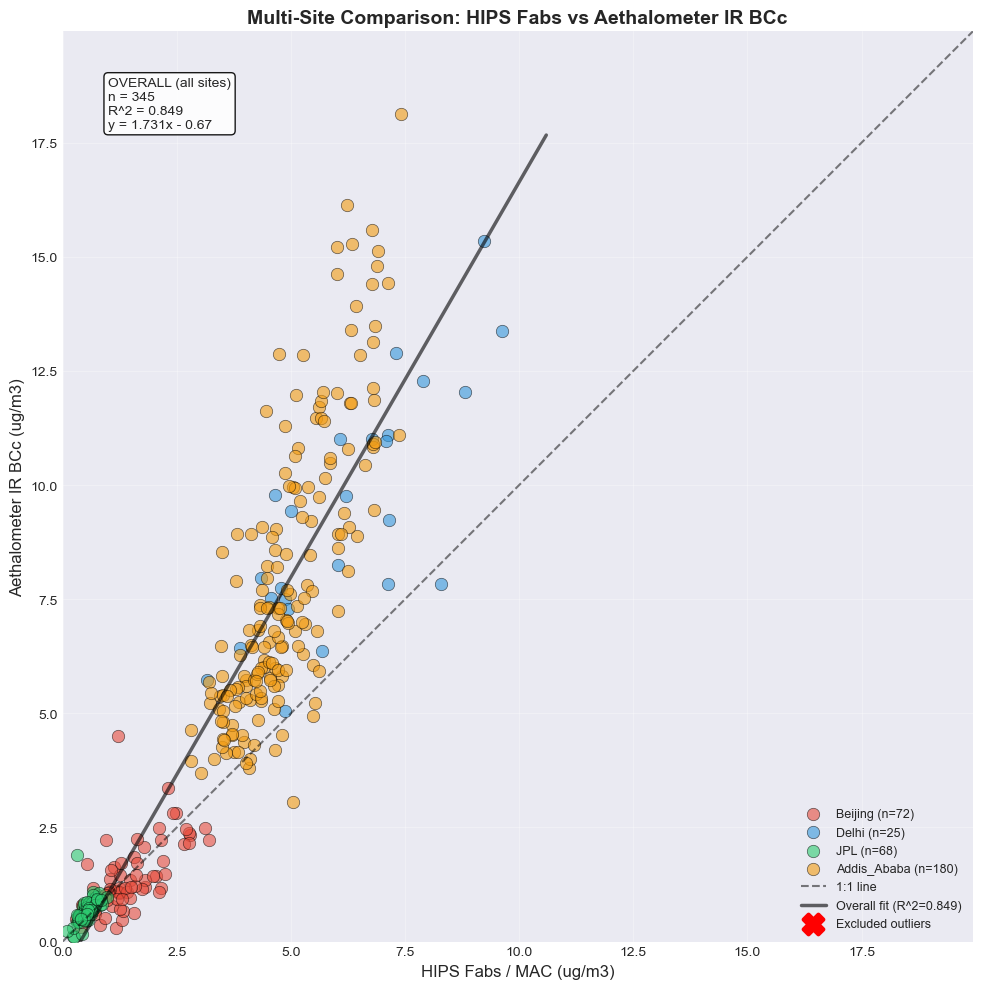


HIPS Fabs vs Aethalometer IR BCc - Site Statistics:
Site                   n        R^2      Slope
---------------------------------------------
Beijing               72      0.404      0.689
Delhi                 25      0.609      1.174
JPL                   68      0.326      0.867
Addis_Ababa          180      0.623      2.349
---------------------------------------------
OVERALL              345      0.849      1.731



In [31]:
# Multi-site comparison plots
# Show all sites on same axes for direct comparison

multisite_comparisons = [
    {
        'name': 'Aethalometer IR BCc vs FTIR EC',
        'x_col': 'ir_bcc',
        'y_col': 'ftir_ec',
        'x_label': 'Aethalometer IR BCc (ug/m3)',
        'y_label': 'FTIR EC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs FTIR EC',
        'x_col': 'hips_fabs',
        'y_col': 'ftir_ec',
        'x_label': 'HIPS Fabs / MAC (ug/m3)',
        'y_label': 'FTIR EC (ug/m3)',
        'equal_axes': True
    },
    {
        'name': 'HIPS Fabs vs Aethalometer IR BCc',
        'x_col': 'hips_fabs',
        'y_col': 'ir_bcc',
        'x_label': 'HIPS Fabs / MAC (ug/m3)',
        'y_label': 'Aethalometer IR BCc (ug/m3)',
        'equal_axes': True
    }
]

for comp in multisite_comparisons:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    all_x = []
    all_y = []
    site_stats = {}
    
    for site_name, matched_df in all_params_data.items():
        config = SITES[site_name]
        
        x_col = comp['x_col']
        y_col = comp['y_col']
        
        # Check if columns exist
        if x_col not in matched_df.columns or y_col not in matched_df.columns:
            continue
        
        # Apply exclusion flags
        df_flagged = apply_exclusion_flags(matched_df.copy(), site_name)
        outlier_mask = df_flagged['is_excluded'].values if 'is_excluded' in df_flagged.columns else None
        
        x_data = df_flagged[x_col].values
        y_data = df_flagged[y_col].values
        
        # Valid data mask
        valid_mask = (~np.isnan(x_data)) & (~np.isnan(y_data))
        
        if outlier_mask is not None:
            clean_mask = valid_mask & ~outlier_mask
            outlier_plot_mask = valid_mask & outlier_mask
        else:
            clean_mask = valid_mask
            outlier_plot_mask = np.zeros(len(x_data), dtype=bool)
        
        x_clean = x_data[clean_mask]
        y_clean = y_data[clean_mask]
        
        if len(x_clean) < 3:
            continue
        
        all_x.extend(x_clean)
        all_y.extend(y_clean)
        
        # Plot clean data for this site
        ax.scatter(x_clean, y_clean, color=config['color'], alpha=0.6, s=80,
                   edgecolors='black', linewidth=0.5,
                   label=f"{site_name} (n={len(x_clean)})")
        
        # Plot outliers as red X (no legend entry to avoid duplicates)
        if outlier_plot_mask.any():
            ax.scatter(x_data[outlier_plot_mask], y_data[outlier_plot_mask],
                       color='red', alpha=0.9, s=200, marker='X', linewidths=3)
        
        # Calculate site stats
        stats = calculate_regression_stats(x_clean, y_clean)
        if stats:
            site_stats[site_name] = stats
    
    if len(all_x) < 3:
        print(f"{comp['name']}: Insufficient data")
        plt.close()
        continue
    
    # Set axis limits
    if comp['equal_axes']:
        max_val = max(max(all_x), max(all_y)) * 1.1
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
    else:
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)
    
    # Add overall regression
    overall_stats = calculate_regression_stats(all_x, all_y)
    if overall_stats:
        x_line = np.array([0, max(all_x) * 1.1])
        y_line = overall_stats['slope'] * x_line + overall_stats['intercept']
        ax.plot(x_line, y_line, 'k-', linewidth=2.5, alpha=0.6, 
                label=f'Overall fit (R^2={overall_stats["r_squared"]:.3f})')
        
        sign = '+' if overall_stats['intercept'] >= 0 else '-'
        eq = f"y = {overall_stats['slope']:.3f}x {sign} {abs(overall_stats['intercept']):.2f}"
        text = f"OVERALL (all sites)\nn = {overall_stats['n']}\nR^2 = {overall_stats['r_squared']:.3f}\n{eq}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # Add red X to legend (once)
    ax.scatter([], [], color='red', marker='X', s=200, linewidths=3, label='Excluded outliers')
    
    ax.set_xlabel(comp['x_label'], fontsize=12)
    ax.set_ylabel(comp['y_label'], fontsize=12)
    ax.set_title(f"Multi-Site Comparison: {comp['name']}", fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print stats table
    print(f"\n{comp['name']} - Site Statistics:")
    print(f"{'Site':<15s} {'n':>8s} {'R^2':>10s} {'Slope':>10s}")
    print("-" * 45)
    for site_name, stats in site_stats.items():
        print(f"{site_name:<15s} {stats['n']:>8d} {stats['r_squared']:>10.3f} {stats['slope']:>10.3f}")
    if overall_stats:
        print("-" * 45)
        print(f"{'OVERALL':<15s} {overall_stats['n']:>8d} {overall_stats['r_squared']:>10.3f} {overall_stats['slope']:>10.3f}")
    print()

---

## 5. HIPS vs Aethalometer Smooth/Raw Threshold Analysis

Redo the smooth/raw threshold analysis specifically for HIPS vs Aethalometer comparison (absorption vs absorption), rather than FTIR EC vs Aethalometer.

This is a more direct comparison since both HIPS and aethalometer measure light absorption.

In [32]:
# Match HIPS data with aethalometer smooth/raw info
def match_hips_with_smooth_raw_info(site_name, df_aeth, filter_data, site_code, wavelength='IR'):
    """
    Match HIPS Fabs and aethalometer data, including smooth/raw difference info.
    
    Returns DataFrame with:
    - date
    - aeth_bc (using raw BC, ug/m3)
    - aeth_bc_smooth (ug/m3)
    - hips_fabs (ug/m3 equivalent, divided by MAC)
    - smooth_raw_pct: % difference
    - smooth_raw_abs_pct: absolute % difference
    """
    raw_col = f'{wavelength} BCc'
    smooth_col = f'{wavelength} BCc smoothed'
    
    # Check if columns exist
    if raw_col not in df_aeth.columns:
        print(f"  {site_name}: {raw_col} not found")
        return None
    
    has_smooth = smooth_col in df_aeth.columns
    
    # Get HIPS Fabs data for this site
    site_hips = filter_data[
        (filter_data['Site'] == site_code) &
        (filter_data['Parameter'] == 'HIPS_Fabs')
    ].copy()
    
    if len(site_hips) == 0:
        print(f"  {site_name}: No HIPS data available")
        return None
    
    matched_records = []
    
    for _, filter_row in site_hips.iterrows():
        filter_date = filter_row['SampleDate']
        
        date_match = df_aeth[
            (df_aeth['day_9am'] >= filter_date - pd.Timedelta(days=1)) &
            (df_aeth['day_9am'] <= filter_date + pd.Timedelta(days=1))
        ]
        
        if len(date_match) > 0:
            bc_raw = date_match[raw_col].mean()  # ng/m3
            bc_smooth = date_match[smooth_col].mean() if has_smooth else np.nan
            
            if pd.notna(bc_raw) and pd.notna(filter_row['Concentration']):
                hips_fabs = filter_row['Concentration'] / MAC_VALUE  # Mm^-1 to ug/m3
                
                # Calculate % difference
                if bc_raw != 0 and pd.notna(bc_smooth):
                    pct_diff = ((bc_smooth - bc_raw) / bc_raw) * 100
                else:
                    pct_diff = np.nan
                
                matched_records.append({
                    'date': filter_date,
                    'aeth_bc': bc_raw / 1000,  # ng to ug/m3
                    'aeth_bc_smooth': bc_smooth / 1000 if pd.notna(bc_smooth) else np.nan,
                    'hips_fabs': hips_fabs,
                    'smooth_raw_pct': pct_diff,
                    'smooth_raw_abs_pct': abs(pct_diff) if pd.notna(pct_diff) else np.nan,
                    'filter_id': filter_row.get('FilterId', 'unknown')
                })
    
    return pd.DataFrame(matched_records) if matched_records else None

print("HIPS smooth/raw matching function defined.")

HIPS smooth/raw matching function defined.


In [33]:
# Match HIPS with smooth/raw info for each site
hips_smooth_raw_data = {}

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    matched = match_hips_with_smooth_raw_info(
        site_name, df_aeth, filter_data, config['code']
    )
    
    if matched is not None and len(matched) >= 3:
        n_with_smooth = matched['smooth_raw_abs_pct'].notna().sum()
        hips_smooth_raw_data[site_name] = matched
        print(f"{site_name}: {len(matched)} matched HIPS-Aeth pairs, {n_with_smooth} with smooth data")
    else:
        print(f"{site_name}: Insufficient HIPS-Aeth data")

Beijing: 73 matched HIPS-Aeth pairs, 73 with smooth data
Delhi: 25 matched HIPS-Aeth pairs, 25 with smooth data
JPL: 68 matched HIPS-Aeth pairs, 68 with smooth data
Addis_Ababa: 181 matched HIPS-Aeth pairs, 181 with smooth data



Beijing: HIPS vs Aethalometer Smooth/Raw Threshold Analysis


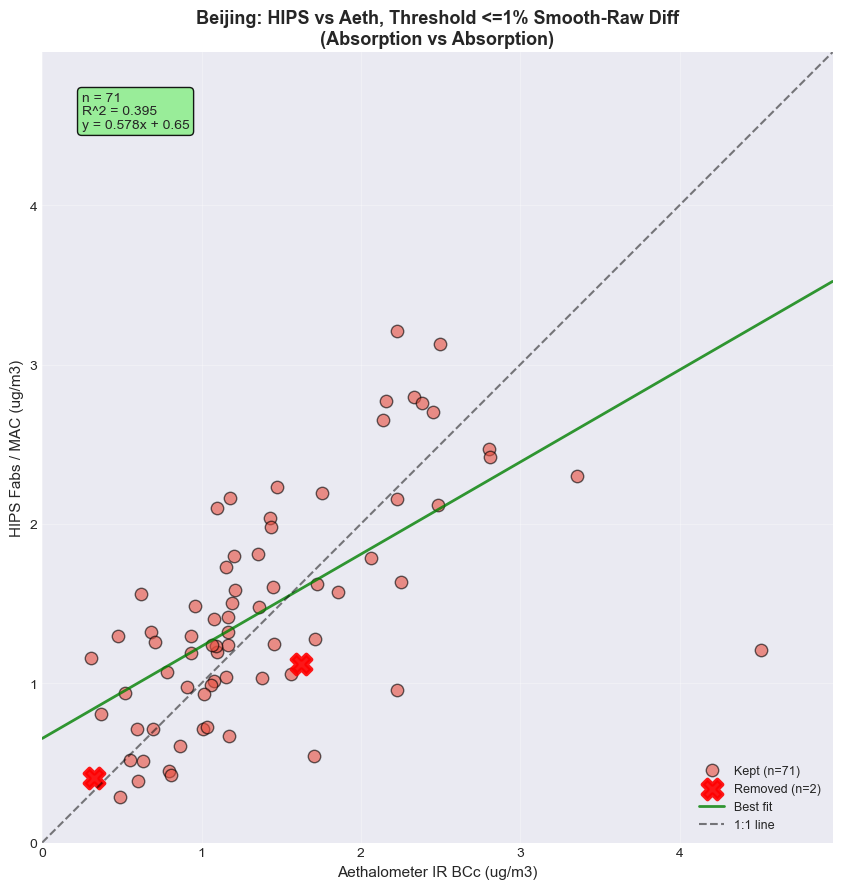

  Threshold <=1%: R^2 = 0.395, n = 71


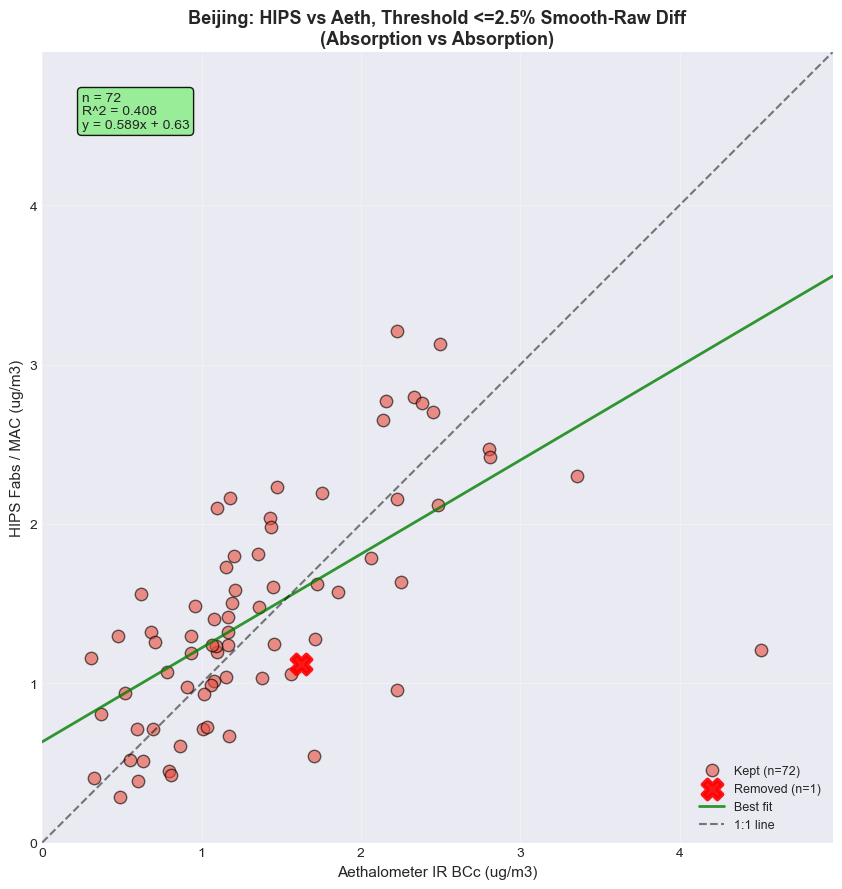

  Threshold <=2.5%: R^2 = 0.408, n = 72


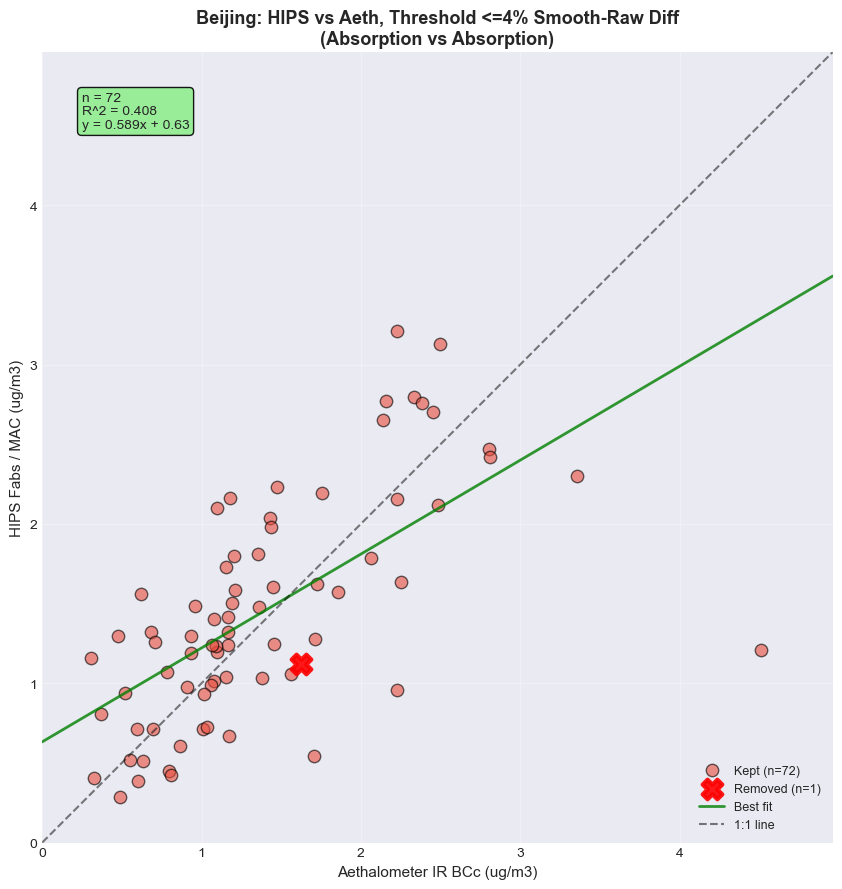

  Threshold <=4%: R^2 = 0.408, n = 72


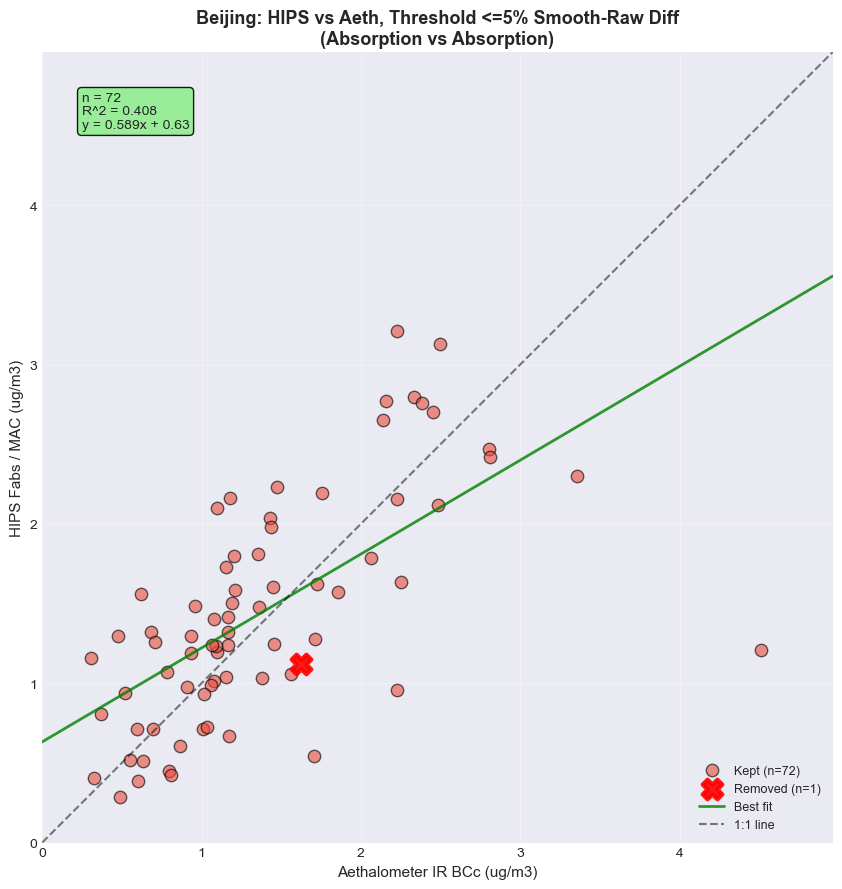

  Threshold <=5%: R^2 = 0.408, n = 72

Delhi: HIPS vs Aethalometer Smooth/Raw Threshold Analysis


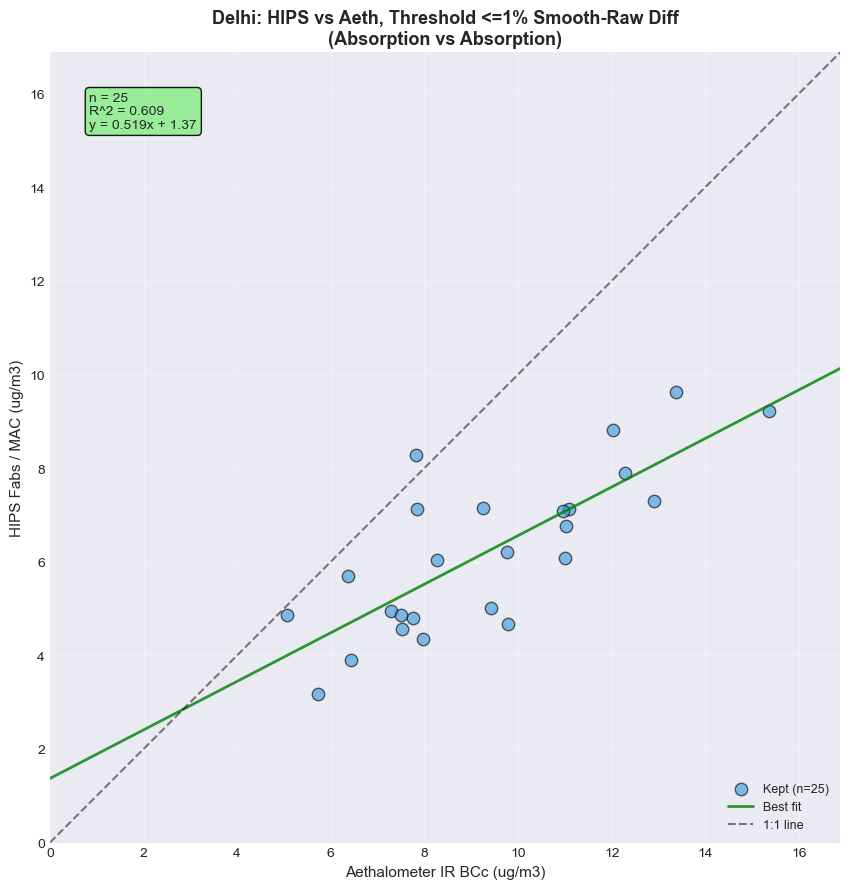

  Threshold <=1%: R^2 = 0.609, n = 25


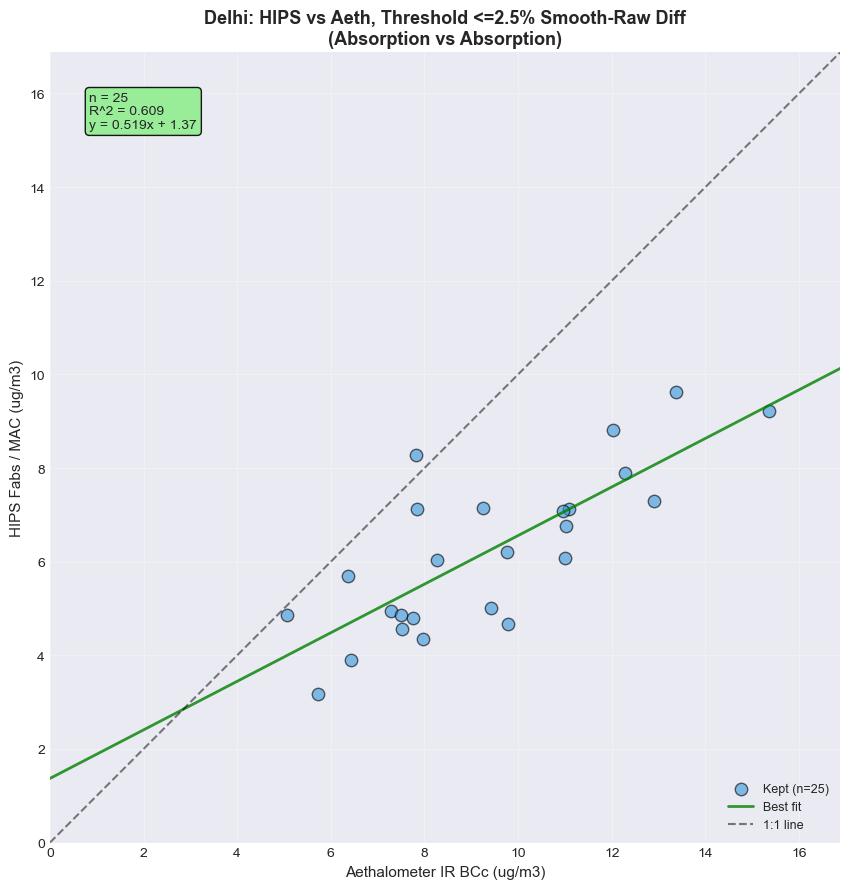

  Threshold <=2.5%: R^2 = 0.609, n = 25


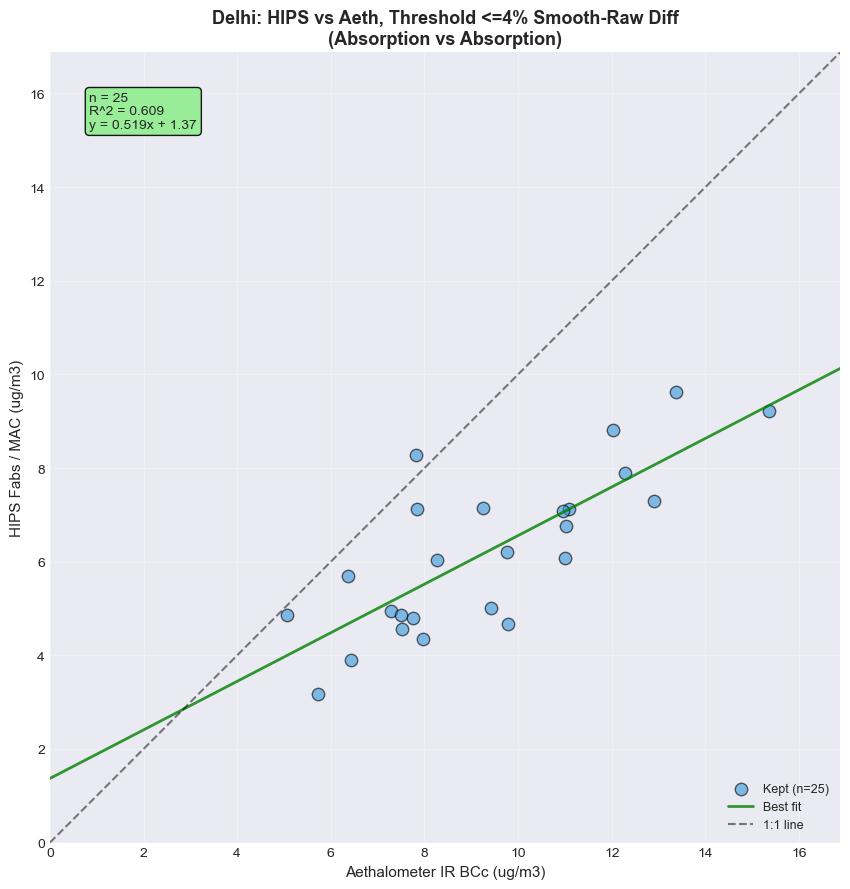

  Threshold <=4%: R^2 = 0.609, n = 25


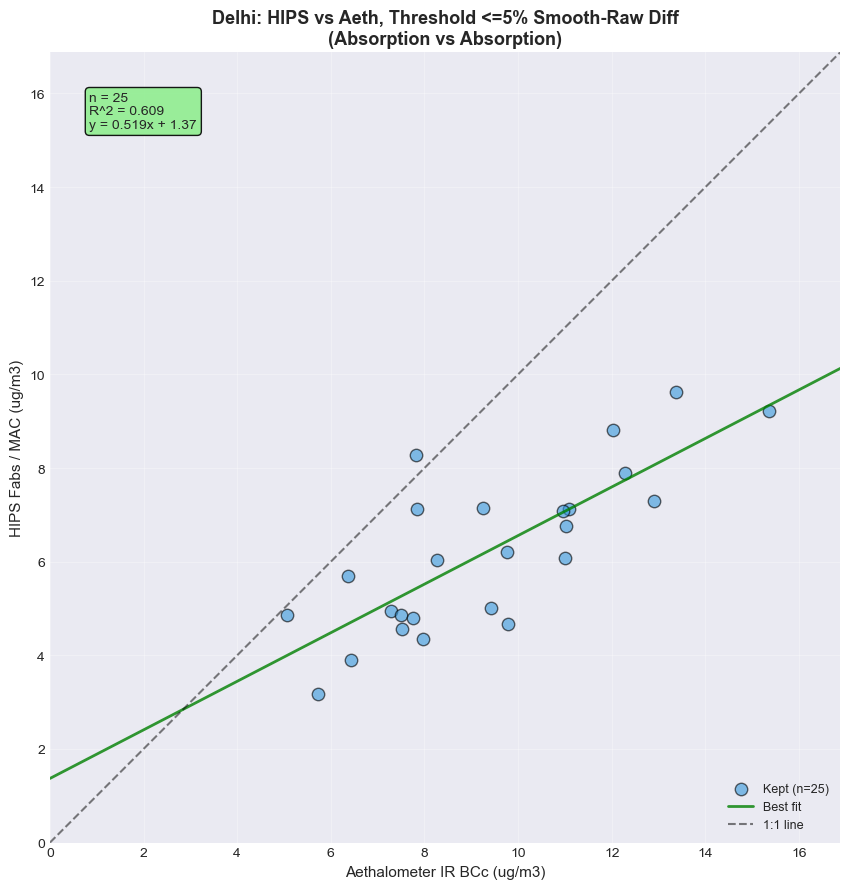

  Threshold <=5%: R^2 = 0.609, n = 25

JPL: HIPS vs Aethalometer Smooth/Raw Threshold Analysis


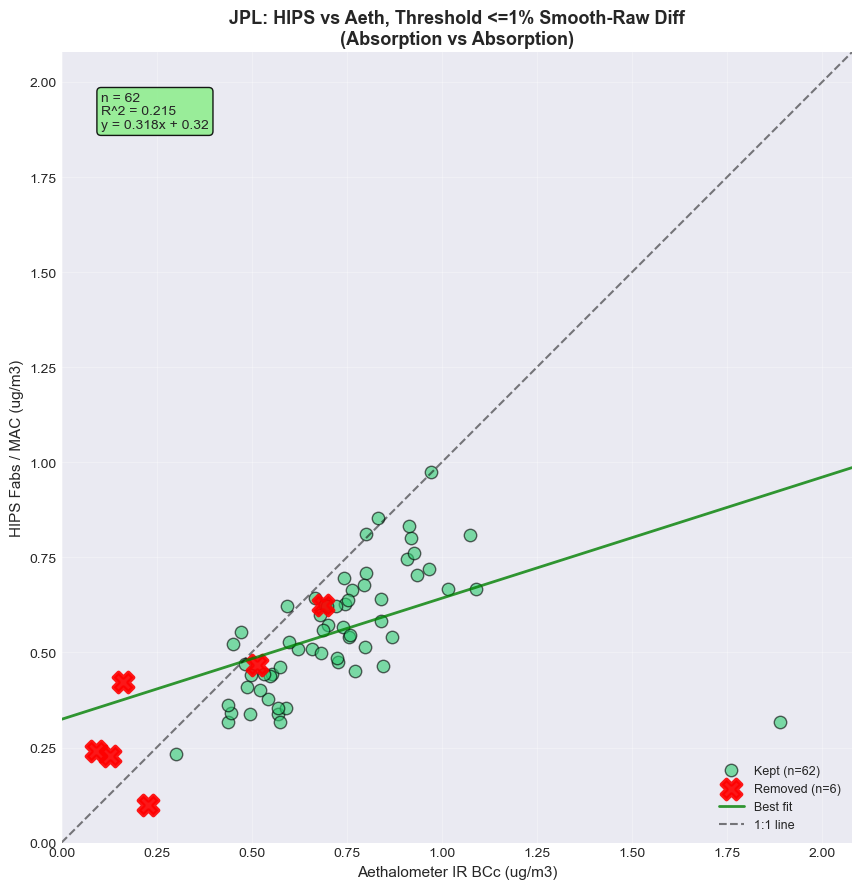

  Threshold <=1%: R^2 = 0.215, n = 62


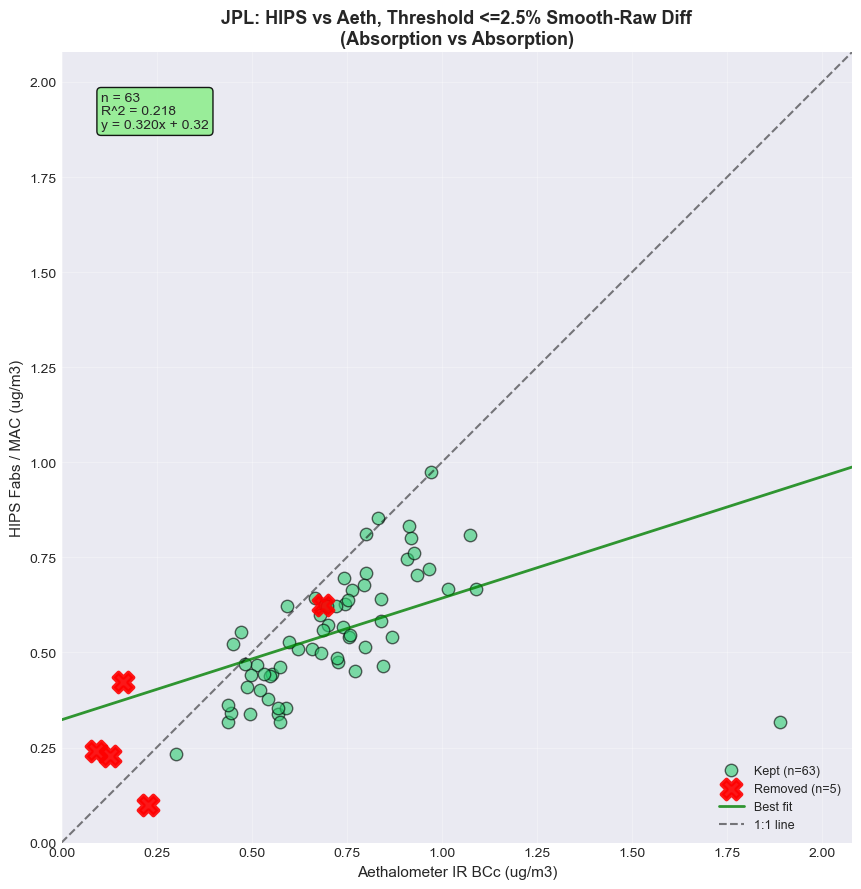

  Threshold <=2.5%: R^2 = 0.218, n = 63


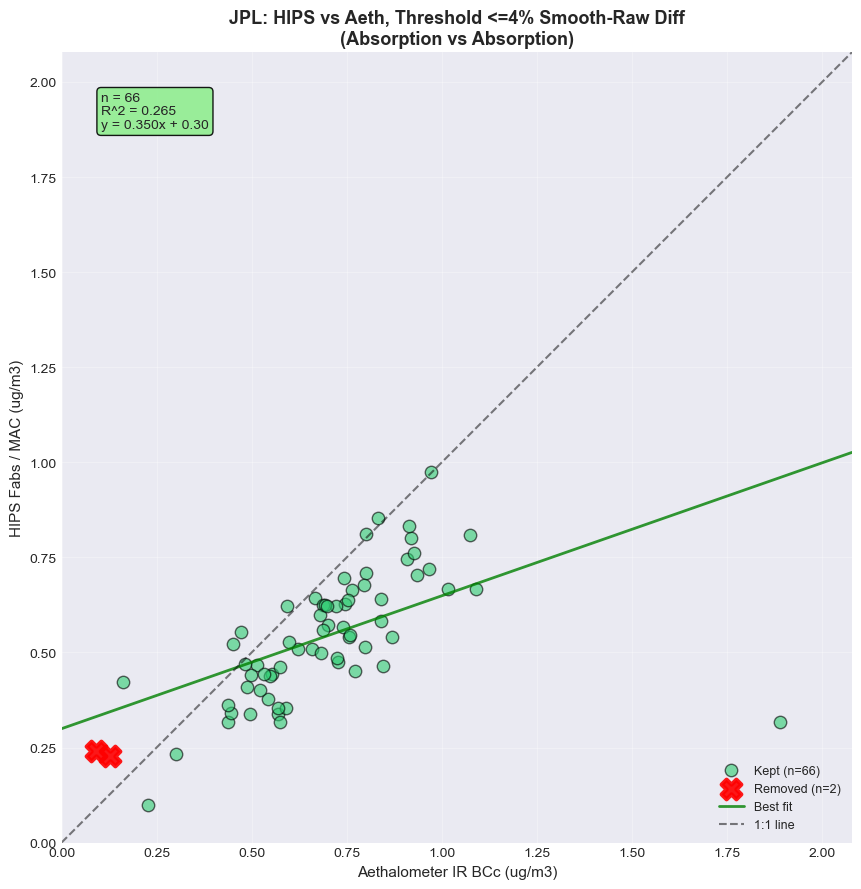

  Threshold <=4%: R^2 = 0.265, n = 66


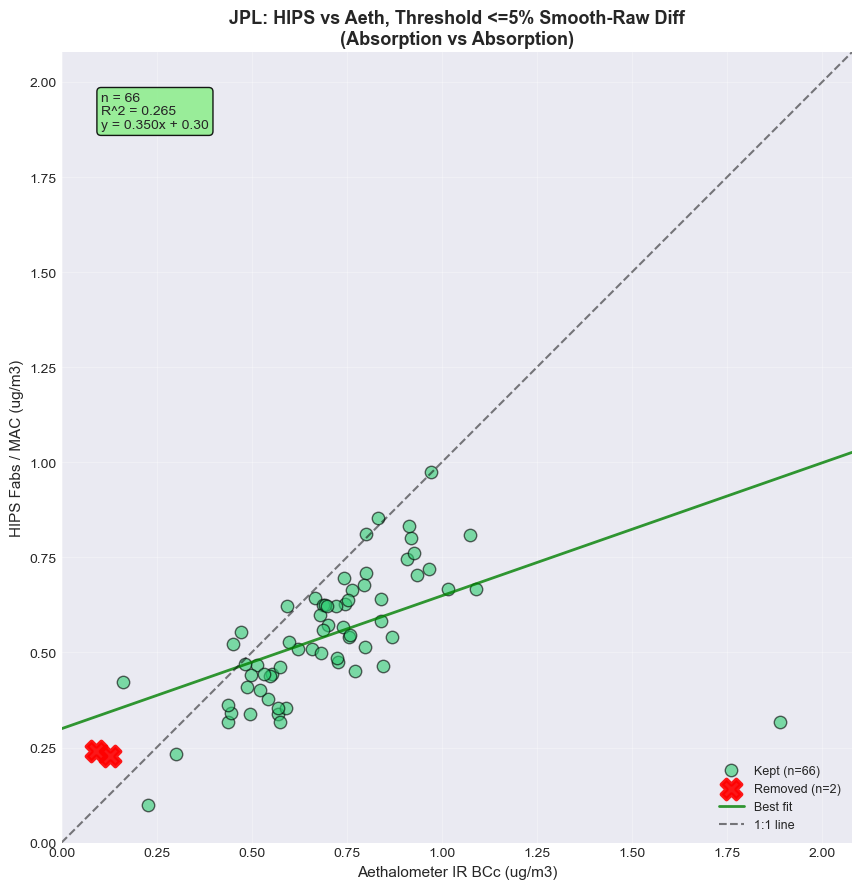

  Threshold <=5%: R^2 = 0.265, n = 66

Addis_Ababa: HIPS vs Aethalometer Smooth/Raw Threshold Analysis


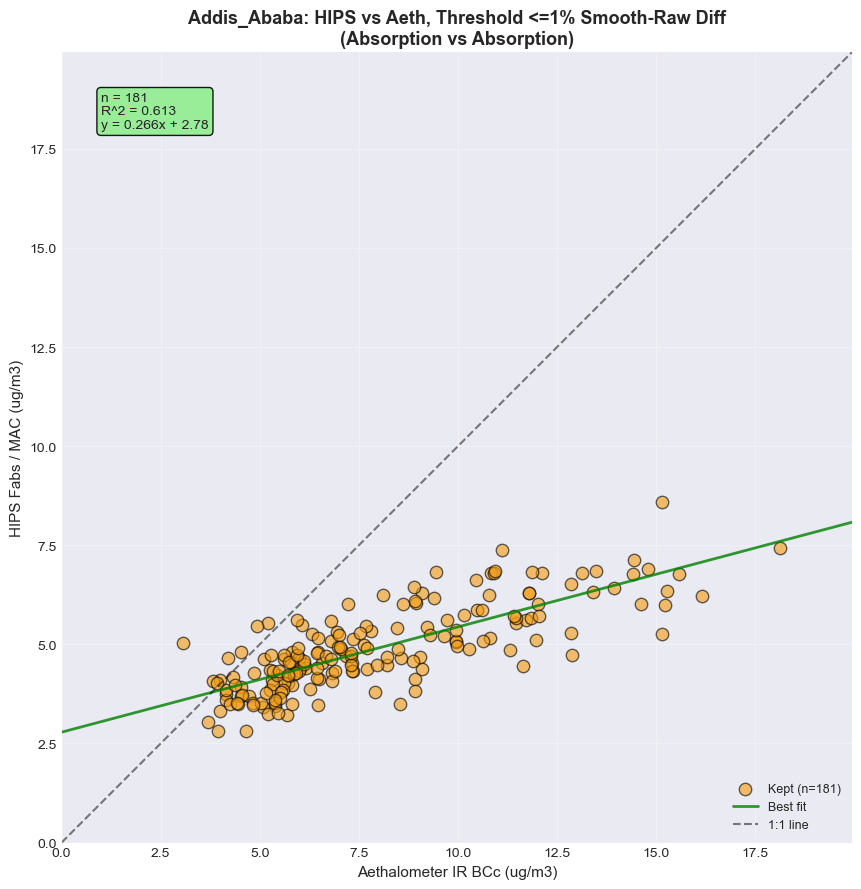

  Threshold <=1%: R^2 = 0.613, n = 181


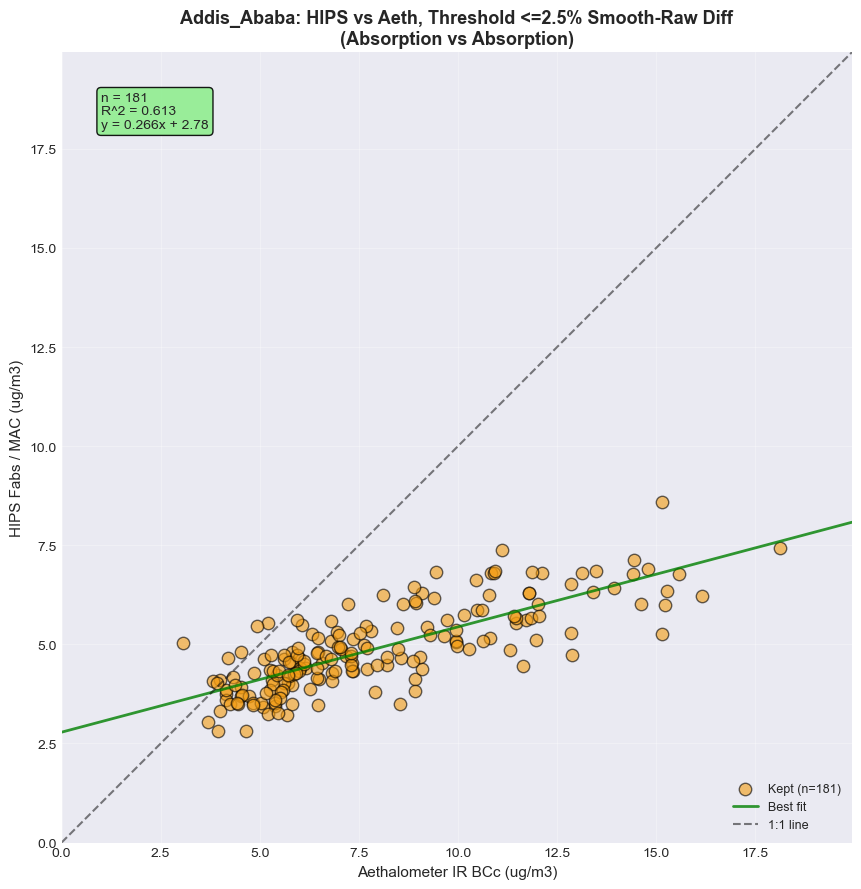

  Threshold <=2.5%: R^2 = 0.613, n = 181


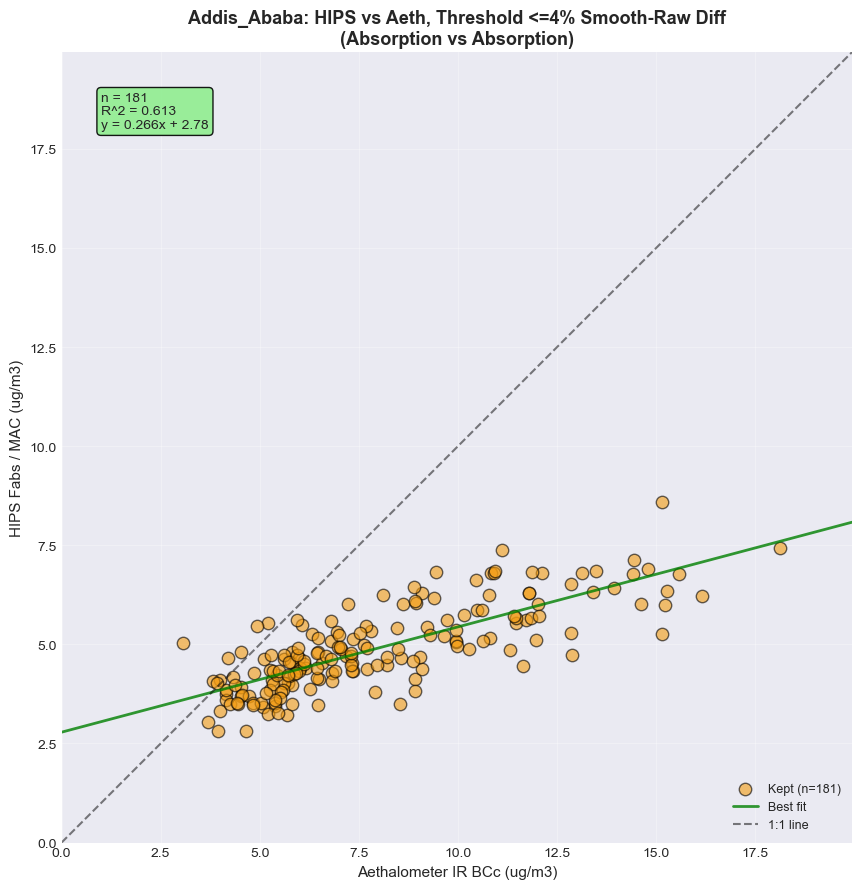

  Threshold <=4%: R^2 = 0.613, n = 181


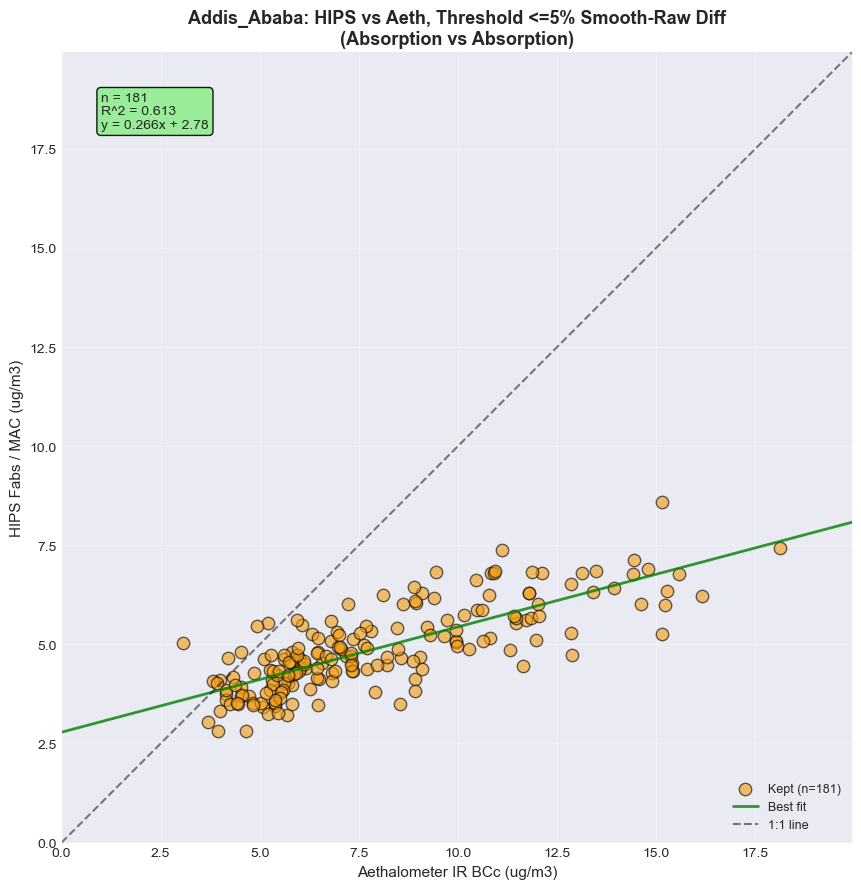

  Threshold <=5%: R^2 = 0.613, n = 181


In [34]:
# HIPS vs Aethalometer threshold analysis (individual plots per threshold)
hips_threshold_results = {}

for site_name, matched_df in hips_smooth_raw_data.items():
    config = SITES[site_name]
    
    if matched_df['smooth_raw_abs_pct'].notna().sum() < 3:
        print(f"{site_name}: Insufficient smooth data for HIPS analysis")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: HIPS vs Aethalometer Smooth/Raw Threshold Analysis")
    print(f"{'='*60}")
    
    site_results = {}
    
    # Calculate axis limits (same for all plots for this site)
    all_vals = np.concatenate([
        matched_df['aeth_bc'].dropna().values,
        matched_df['hips_fabs'].dropna().values
    ])
    max_val = all_vals.max() * 1.1 if len(all_vals) > 0 else 100
    
    for threshold in SMOOTH_RAW_THRESHOLDS:
        # Separate by threshold
        below_threshold = matched_df[matched_df['smooth_raw_abs_pct'] <= threshold].copy()
        above_threshold = matched_df[matched_df['smooth_raw_abs_pct'] > threshold].copy()
        
        n_kept = len(below_threshold)
        n_removed = len(above_threshold)
        
        if n_kept < 3:
            print(f"  Threshold <={threshold}%: Insufficient data (n={n_kept})")
            continue
        
        # Create individual figure for this threshold
        fig, ax = plt.subplots(figsize=(9, 9))
        
        # Plot kept points
        ax.scatter(below_threshold['aeth_bc'], below_threshold['hips_fabs'],
                   color=config['color'], alpha=0.6, s=80,
                   edgecolors='black', linewidth=1,
                   label=f'Kept (n={n_kept})')
        
        # Plot removed points as red X
        if len(above_threshold) > 0:
            ax.scatter(above_threshold['aeth_bc'], above_threshold['hips_fabs'],
                       color='red', alpha=0.9, s=200, marker='X',
                       linewidths=3, label=f'Removed (n={n_removed})')
        
        # Calculate regression on kept points
        stats = calculate_regression_stats(
            below_threshold['aeth_bc'].values,
            below_threshold['hips_fabs'].values
        )
        
        if stats:
            # Plot regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
            stats_text = f"n = {stats['n']}\nR^2 = {stats['r_squared']:.3f}\n{eq}"
            
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.9))
            
            site_results[threshold] = {
                'n_kept': n_kept,
                'n_removed': n_removed,
                **stats
            }
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel('Aethalometer IR BCc (ug/m3)', fontsize=11)
        ax.set_ylabel('HIPS Fabs / MAC (ug/m3)', fontsize=11)
        ax.set_title(f'{site_name}: HIPS vs Aeth, Threshold <={threshold}% Smooth-Raw Diff\n(Absorption vs Absorption)',
                     fontsize=13, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        if stats:
            print(f"  Threshold <={threshold}%: R^2 = {stats['r_squared']:.3f}, n = {stats['n']}")
    
    hips_threshold_results[site_name] = site_results

In [35]:
# Summary table for HIPS vs Aethalometer threshold analysis
print("\n" + "="*80)
print("SUMMARY: HIPS vs Aethalometer - Smooth/Raw Threshold Impact")
print("="*80)
print("(Absorption vs Absorption comparison)")

print_comparison_table(hips_threshold_results, metric_name='HIPS-Aeth Threshold Impact')


SUMMARY: HIPS vs Aethalometer - Smooth/Raw Threshold Impact
(Absorption vs Absorption comparison)

COMPARISON TABLE: HIPS-Aeth Threshold Impact

Beijing:
Threshold              n        R^2      Slope
---------------------------------------------
1                     71      0.395      0.578
2.5                   72      0.408      0.589
4                     72      0.408      0.589
5                     72      0.408      0.589

Delhi:
Threshold              n        R^2      Slope
---------------------------------------------
1                     25      0.609      0.519
2.5                   25      0.609      0.519
4                     25      0.609      0.519
5                     25      0.609      0.519

JPL:
Threshold              n        R^2      Slope
---------------------------------------------
1                     62      0.215      0.318
2.5                   63      0.218      0.320
4                     66      0.265      0.350
5                     66      0.265

---

## 6. Before/After Flow Fix Separation Analysis

Separate data by flow fix periods and compare regression statistics. This is particularly relevant for Beijing and JPL which had flow issues early in deployment.

In [36]:
# Show flow fix period configuration
print("Flow Fix Period Configuration:")
print("="*60)
for site_name, config in FLOW_FIX_PERIODS.items():
    print(f"\n{site_name}:")
    print(f"  Description: {config['description']}")
    print(f"  Before end: {config['before_end']}")
    print(f"  After start: {config['after_start']}")
    print(f"  Notes: {config['notes']}")

Flow Fix Period Configuration:

Beijing:
  Description: Gap in data where instrument was likely serviced
  Before end: 2022-06-01
  After start: 2022-09-01
  Notes: May 2022 data has very low flow ratios pulling down the mean

JPL:
  Description: Similar gap where flow ratio improved
  Before end: 2022-06-01
  After start: 2022-09-01
  Notes: Early days have flow ratio near 1.2, later improved to ~2.5

Delhi:
  Description: Started after flow issues were resolved
  Before end: None
  After start: None
  Notes: Best flow ratios (~2.4 mean), no problematic early period

Addis_Ababa:
  Description: Consistently low flow ratio throughout
  Before end: None
  After start: None
  Notes: Flow ratio ~1.2 throughout - never fixed



Beijing: Before/After Flow Fix Analysis
  Sample counts by period: {'after_fix': 65}
  Before Flow Fix: Insufficient data (n=0)
  After Flow Fix: R^2 = 0.197, Slope = 0.556, n = 65


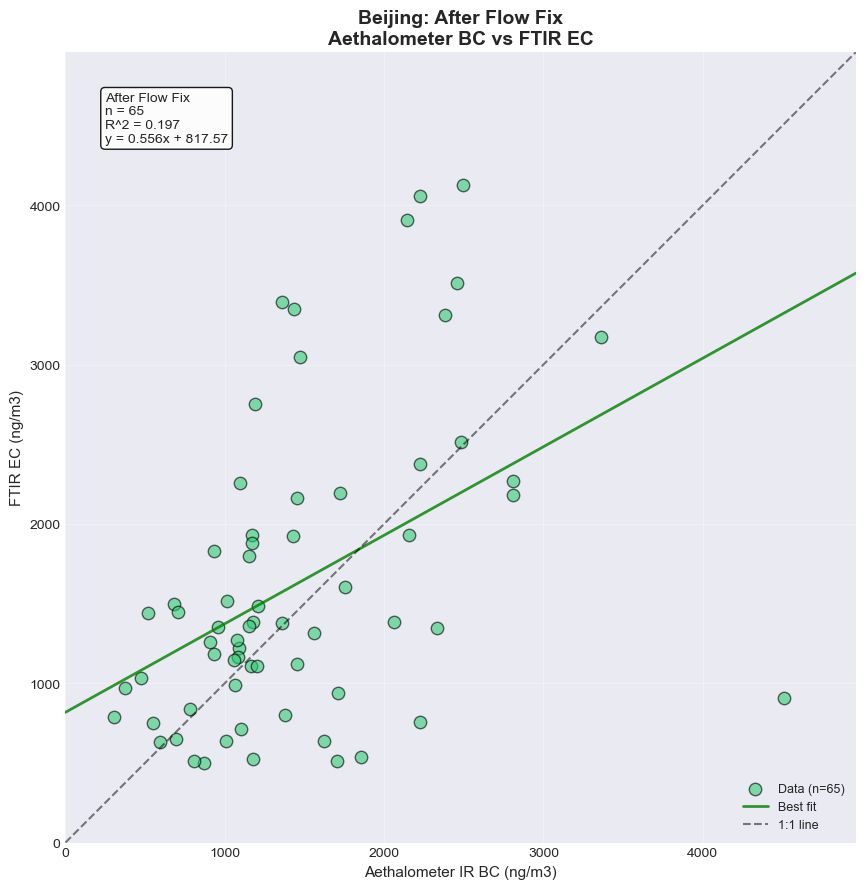


Delhi: No flow fix periods defined (all data treated as single period)

JPL: Before/After Flow Fix Analysis
  Sample counts by period: {'after_fix': 29, 'gap_period': 13}
  Before Flow Fix: Insufficient data (n=0)
  After Flow Fix: R^2 = 0.022, Slope = 0.067, n = 29


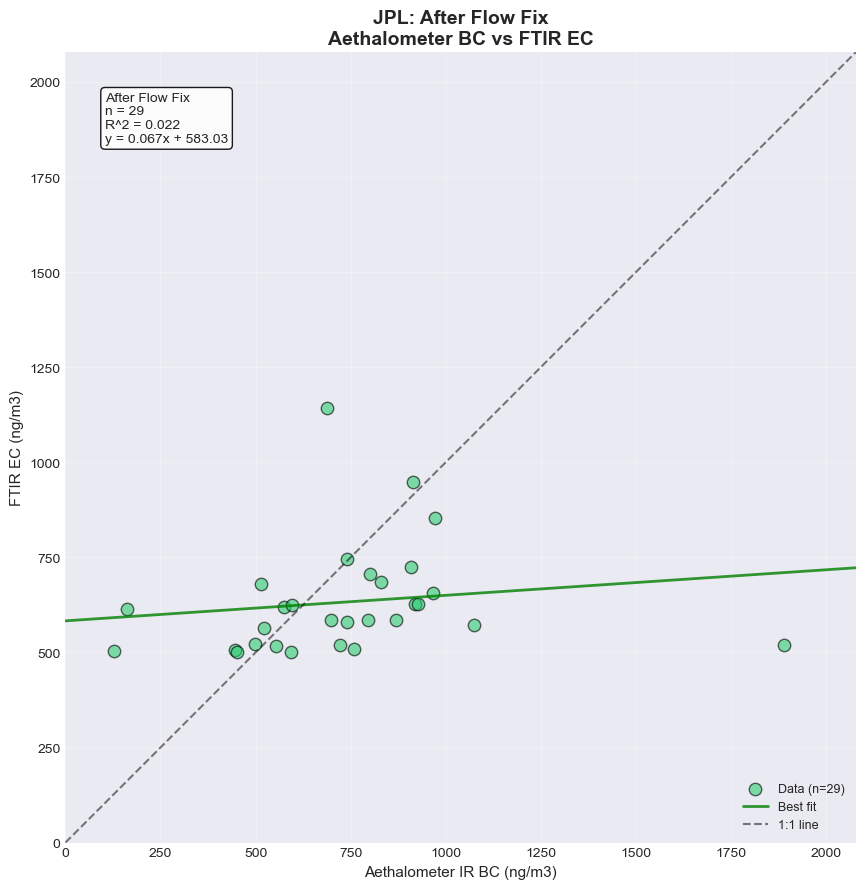


Addis_Ababa: No flow fix periods defined (all data treated as single period)


In [37]:
# Before/After Flow Fix Analysis
# Compare Aethalometer vs FTIR EC for before/after periods

flow_fix_results = {}

for site_name, matched_df in all_matched_data.items():
    config = SITES[site_name]
    flow_config = FLOW_FIX_PERIODS.get(site_name, {})
    
    # Check if this site has flow fix periods defined
    before_end = flow_config.get('before_end')
    after_start = flow_config.get('after_start')
    
    if before_end is None and after_start is None:
        print(f"\n{site_name}: No flow fix periods defined (all data treated as single period)")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Before/After Flow Fix Analysis")
    print(f"{'='*60}")
    
    # Add flow period column
    matched_with_period = matched_df.copy()
    matched_with_period['date'] = pd.to_datetime(matched_with_period['date'])
    
    before_end_dt = pd.to_datetime(before_end) if before_end else None
    after_start_dt = pd.to_datetime(after_start) if after_start else None
    
    def classify_period(date):
        if before_end_dt and date <= before_end_dt:
            return 'before_fix'
        elif after_start_dt and date >= after_start_dt:
            return 'after_fix'
        else:
            return 'gap_period'
    
    matched_with_period['flow_period'] = matched_with_period['date'].apply(classify_period)
    
    # Count samples in each period
    period_counts = matched_with_period['flow_period'].value_counts()
    print(f"  Sample counts by period: {period_counts.to_dict()}")
    
    # Apply exclusion flags
    matched_with_period = apply_exclusion_flags(matched_with_period, site_name)
    
    site_results = {}
    
    # Calculate axis limits
    all_vals = np.concatenate([
        matched_with_period['aeth_bc'].dropna().values,
        matched_with_period['filter_ec'].dropna().values
    ])
    max_val = all_vals.max() * 1.1 if len(all_vals) > 0 else 100
    
    # Create separate plots for before/after
    for period, period_label, period_color in [
        ('before_fix', 'Before Flow Fix', '#E74C3C'),  # Red
        ('after_fix', 'After Flow Fix', '#2ECC71')     # Green
    ]:
        period_data = matched_with_period[matched_with_period['flow_period'] == period].copy()
        
        if len(period_data) < 3:
            print(f"  {period_label}: Insufficient data (n={len(period_data)})")
            continue
        
        # Get outlier mask for this period
        outlier_mask = period_data['is_excluded'].values if 'is_excluded' in period_data.columns else None
        
        fig, ax = plt.subplots(figsize=(9, 9))
        
        x_data = period_data['aeth_bc'].values
        y_data = period_data['filter_ec'].values
        
        # Valid data mask
        valid_mask = (~np.isnan(x_data)) & (~np.isnan(y_data))
        
        if outlier_mask is not None:
            clean_mask = valid_mask & ~outlier_mask
            outlier_plot_mask = valid_mask & outlier_mask
        else:
            clean_mask = valid_mask
            outlier_plot_mask = np.zeros(len(x_data), dtype=bool)
        
        x_clean = x_data[clean_mask]
        y_clean = y_data[clean_mask]
        
        # Plot clean data
        ax.scatter(x_clean, y_clean, color=period_color, alpha=0.6, s=80,
                   edgecolors='black', linewidth=1, label=f'Data (n={len(x_clean)})')
        
        # Plot outliers as red X
        if outlier_plot_mask.any():
            ax.scatter(x_data[outlier_plot_mask], y_data[outlier_plot_mask],
                       color='red', alpha=0.9, s=200, marker='X', linewidths=3,
                       label=f'Excluded (n={outlier_plot_mask.sum()})')
        
        # Calculate regression
        stats = calculate_regression_stats(x_clean, y_clean)
        
        if stats:
            # Regression line
            x_line = np.array([0, max_val])
            y_line = stats['slope'] * x_line + stats['intercept']
            ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
            
            # Stats text
            sign = '+' if stats['intercept'] >= 0 else '-'
            eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
            stats_text = f"{period_label}\nn = {stats['n']}\nR^2 = {stats['r_squared']:.3f}\n{eq}"
            ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
            
            site_results[period] = stats
            print(f"  {period_label}: R^2 = {stats['r_squared']:.3f}, Slope = {stats['slope']:.3f}, n = {stats['n']}")
        
        # Set axes
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlabel('Aethalometer IR BC (ng/m3)', fontsize=11)
        ax.set_ylabel('FTIR EC (ng/m3)', fontsize=11)
        ax.set_title(f'{site_name}: {period_label}\nAethalometer BC vs FTIR EC',
                     fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    flow_fix_results[site_name] = site_results

In [38]:
# Summary table for flow fix analysis
print("\n" + "="*80)
print("SUMMARY: Before/After Flow Fix Comparison")
print("="*80)

for site_name, results in flow_fix_results.items():
    if len(results) == 0:
        continue
    
    print(f"\n{site_name}:")
    print(f"{'Period':<20s} {'n':>8s} {'R^2':>10s} {'Slope':>10s}")
    print("-" * 50)
    
    for period, stats in results.items():
        period_label = 'Before Fix' if period == 'before_fix' else 'After Fix'
        print(f"{period_label:<20s} {stats['n']:>8d} {stats['r_squared']:>10.3f} {stats['slope']:>10.3f}")
    
    # Show improvement
    if 'before_fix' in results and 'after_fix' in results:
        r2_before = results['before_fix']['r_squared']
        r2_after = results['after_fix']['r_squared']
        slope_before = results['before_fix']['slope']
        slope_after = results['after_fix']['slope']
        
        print(f"\n  R^2 change: {r2_before:.3f} -> {r2_after:.3f} (delta = {r2_after - r2_before:+.3f})")
        print(f"  Slope change: {slope_before:.3f} -> {slope_after:.3f} (delta = {slope_after - slope_before:+.3f})")


SUMMARY: Before/After Flow Fix Comparison

Beijing:
Period                      n        R^2      Slope
--------------------------------------------------
After Fix                  65      0.197      0.556

JPL:
Period                      n        R^2      Slope
--------------------------------------------------
After Fix                  29      0.022      0.067


---

## 7. Wavelength Dependence Analysis (All Sites)

Compare BC measurements at different wavelengths across all sites. This helps understand source apportionment (biomass burning vs fossil fuel) and potential measurement artifacts.

In [39]:
# Check which wavelengths are available for each site
wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']
wavelength_colors = {
    'UV': '#9B59B6',    # Purple
    'Blue': '#3498DB',  # Blue
    'Green': '#2ECC71', # Green
    'Red': '#E74C3C',   # Red
    'IR': '#34495E'     # Dark gray
}

print("Available BC wavelengths by site:")
print("="*60)

for site_name, df in aethalometer_data.items():
    available = []
    for wl in wavelengths:
        col = f'{wl} BCc'
        if col in df.columns:
            n_valid = df[col].notna().sum()
            if n_valid > 0:
                available.append(f"{wl} (n={n_valid})")
    print(f"\n{site_name}:")
    print(f"  {', '.join(available)}")

Available BC wavelengths by site:

Beijing:
  UV (n=222), Blue (n=222), Green (n=222), Red (n=222), IR (n=222)

Delhi:
  UV (n=113), Blue (n=113), Green (n=113), Red (n=113), IR (n=113)

JPL:
  UV (n=489), Blue (n=489), Green (n=489), Red (n=489), IR (n=489)

Addis_Ababa:
  UV (n=515), Blue (n=515), Green (n=515), Red (n=515), IR (n=515)



UV vs IR BC Comparison (Source Apportionment)
Higher UV/IR ratio suggests biomass burning contribution
Lower UV/IR ratio suggests fossil fuel dominance



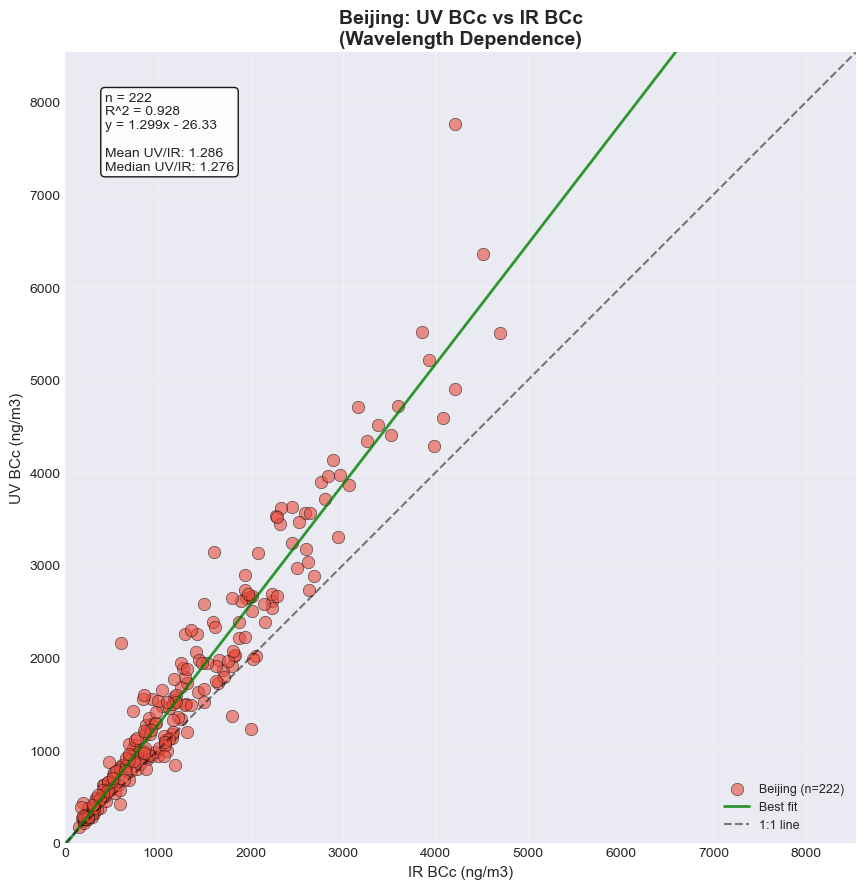

Beijing:
  Mean UV/IR ratio: 1.286
  Median UV/IR ratio: 1.276
  Std UV/IR ratio: 0.281



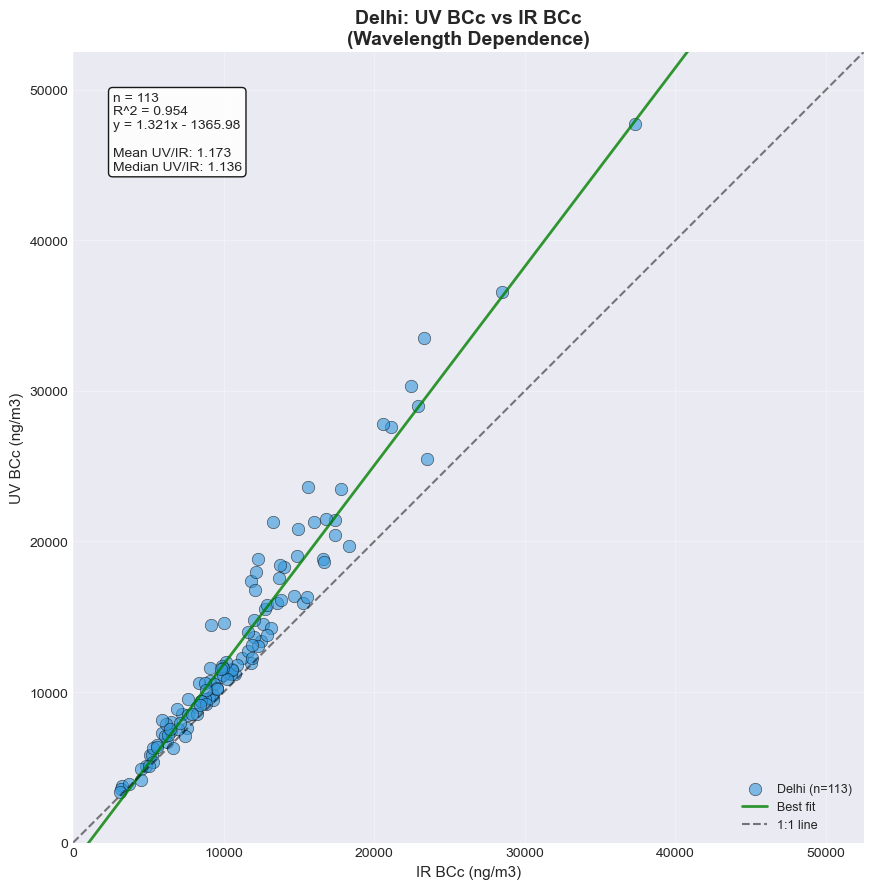

Delhi:
  Mean UV/IR ratio: 1.173
  Median UV/IR ratio: 1.136
  Std UV/IR ratio: 0.136



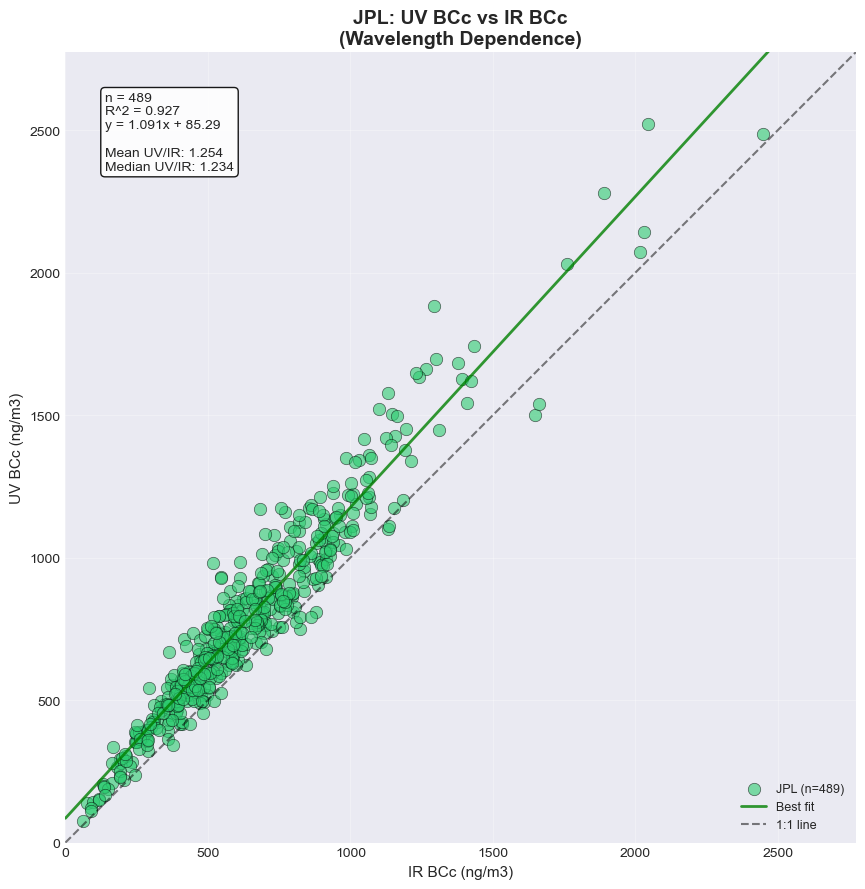

JPL:
  Mean UV/IR ratio: 1.254
  Median UV/IR ratio: 1.234
  Std UV/IR ratio: 0.165



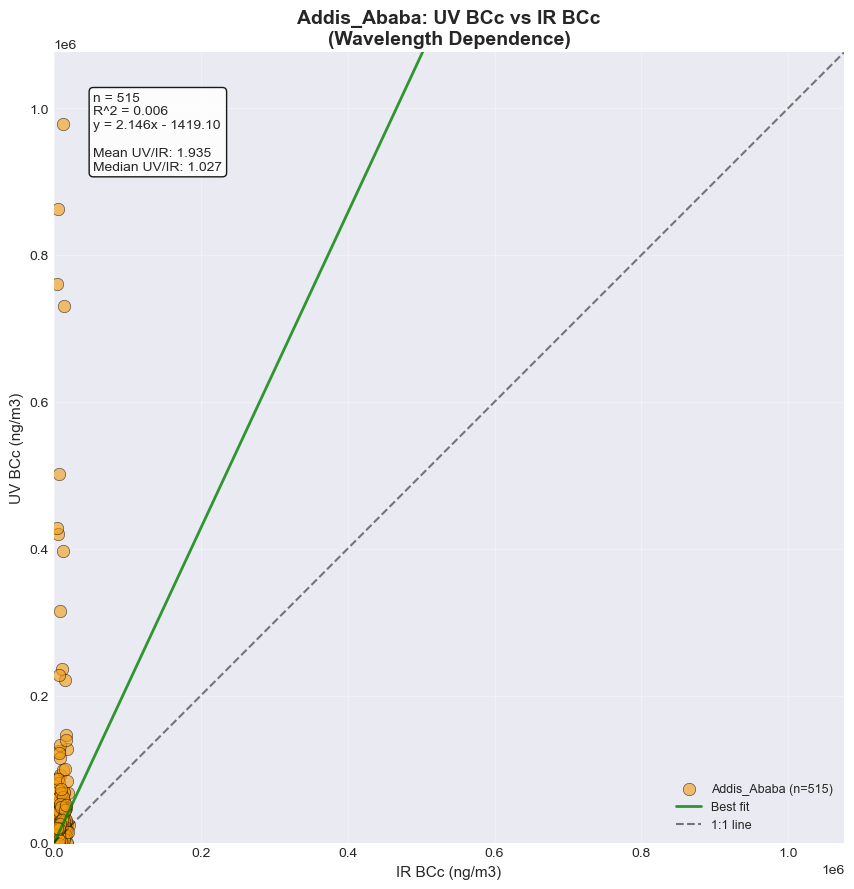

Addis_Ababa:
  Mean UV/IR ratio: 1.935
  Median UV/IR ratio: 1.027
  Std UV/IR ratio: 15.273



In [40]:
# Wavelength cross-plots: Compare UV BCc vs IR BCc (ratio indicates source type)
# Higher UV/IR ratio suggests biomass burning, lower ratio suggests fossil fuel

print("\n" + "="*80)
print("UV vs IR BC Comparison (Source Apportionment)")
print("="*80)
print("Higher UV/IR ratio suggests biomass burning contribution")
print("Lower UV/IR ratio suggests fossil fuel dominance")
print()

wavelength_results = {}

for site_name, df in aethalometer_data.items():
    config = SITES[site_name]
    
    # Check if both UV and IR are available
    if 'UV BCc' not in df.columns or 'IR BCc' not in df.columns:
        print(f"{site_name}: Missing UV or IR wavelength data")
        continue
    
    # Get valid data
    valid_mask = df['UV BCc'].notna() & df['IR BCc'].notna()
    valid_df = df[valid_mask].copy()
    
    if len(valid_df) < 3:
        print(f"{site_name}: Insufficient data (n={len(valid_df)})")
        continue
    
    uv_bc = valid_df['UV BCc'].values
    ir_bc = valid_df['IR BCc'].values
    
    # Calculate UV/IR ratio
    ratio = uv_bc / ir_bc
    
    fig, ax = plt.subplots(figsize=(9, 9))
    
    # Scatter plot
    ax.scatter(ir_bc, uv_bc, color=config['color'], alpha=0.6, s=80,
               edgecolors='black', linewidth=0.5, label=f'{site_name} (n={len(ir_bc)})')
    
    # Calculate regression
    stats = calculate_regression_stats(ir_bc, uv_bc)
    
    if stats:
        # Regression line
        max_val = max(ir_bc.max(), uv_bc.max()) * 1.1
        x_line = np.array([0, max_val])
        y_line = stats['slope'] * x_line + stats['intercept']
        ax.plot(x_line, y_line, 'g-', linewidth=2, alpha=0.8, label='Best fit')
        
        # 1:1 line
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=1.5, label='1:1 line')
        
        ax.set_xlim(0, max_val)
        ax.set_ylim(0, max_val)
        ax.set_aspect('equal', adjustable='box')
        
        # Stats text
        sign = '+' if stats['intercept'] >= 0 else '-'
        eq = f"y = {stats['slope']:.3f}x {sign} {abs(stats['intercept']):.2f}"
        stats_text = f"n = {stats['n']}\nR^2 = {stats['r_squared']:.3f}\n{eq}\n\nMean UV/IR: {ratio.mean():.3f}\nMedian UV/IR: {np.median(ratio):.3f}"
        ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        wavelength_results[site_name] = {
            **stats,
            'mean_ratio': ratio.mean(),
            'median_ratio': np.median(ratio),
            'std_ratio': ratio.std()
        }
    
    ax.set_xlabel('IR BCc (ng/m3)', fontsize=11)
    ax.set_ylabel('UV BCc (ng/m3)', fontsize=11)
    ax.set_title(f'{site_name}: UV BCc vs IR BCc\n(Wavelength Dependence)', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"{site_name}:")
    print(f"  Mean UV/IR ratio: {ratio.mean():.3f}")
    print(f"  Median UV/IR ratio: {np.median(ratio):.3f}")
    print(f"  Std UV/IR ratio: {ratio.std():.3f}")
    print()

In [41]:
# Summary comparison of UV/IR ratios across sites
print("\n" + "="*80)
print("SUMMARY: Wavelength Dependence (UV/IR Ratio)")
print("="*80)
print("\nInterpretation:")
print("  - UV/IR > 1.0: Strong UV absorption, suggests biomass burning")
print("  - UV/IR ~ 1.0: Equal absorption, mixed sources")
print("  - UV/IR < 1.0: Strong IR absorption, suggests fossil fuel")
print()

print(f"{'Site':<15s} {'n':>8s} {'Mean UV/IR':>12s} {'Median UV/IR':>14s} {'Std':>8s} {'Slope':>8s}")
print("-" * 70)

for site_name, results in wavelength_results.items():
    print(f"{site_name:<15s} {results['n']:>8d} {results['mean_ratio']:>12.3f} "
          f"{results['median_ratio']:>14.3f} {results['std_ratio']:>8.3f} {results['slope']:>8.3f}")


SUMMARY: Wavelength Dependence (UV/IR Ratio)

Interpretation:
  - UV/IR > 1.0: Strong UV absorption, suggests biomass burning
  - UV/IR ~ 1.0: Equal absorption, mixed sources
  - UV/IR < 1.0: Strong IR absorption, suggests fossil fuel

Site                   n   Mean UV/IR   Median UV/IR      Std    Slope
----------------------------------------------------------------------
Beijing              222        1.286          1.276    0.281    1.299
Delhi                113        1.173          1.136    0.136    1.321
JPL                  489        1.254          1.234    0.165    1.091
Addis_Ababa          515        1.935          1.027   15.273    2.146



Multi-Wavelength BC Time Series by Site


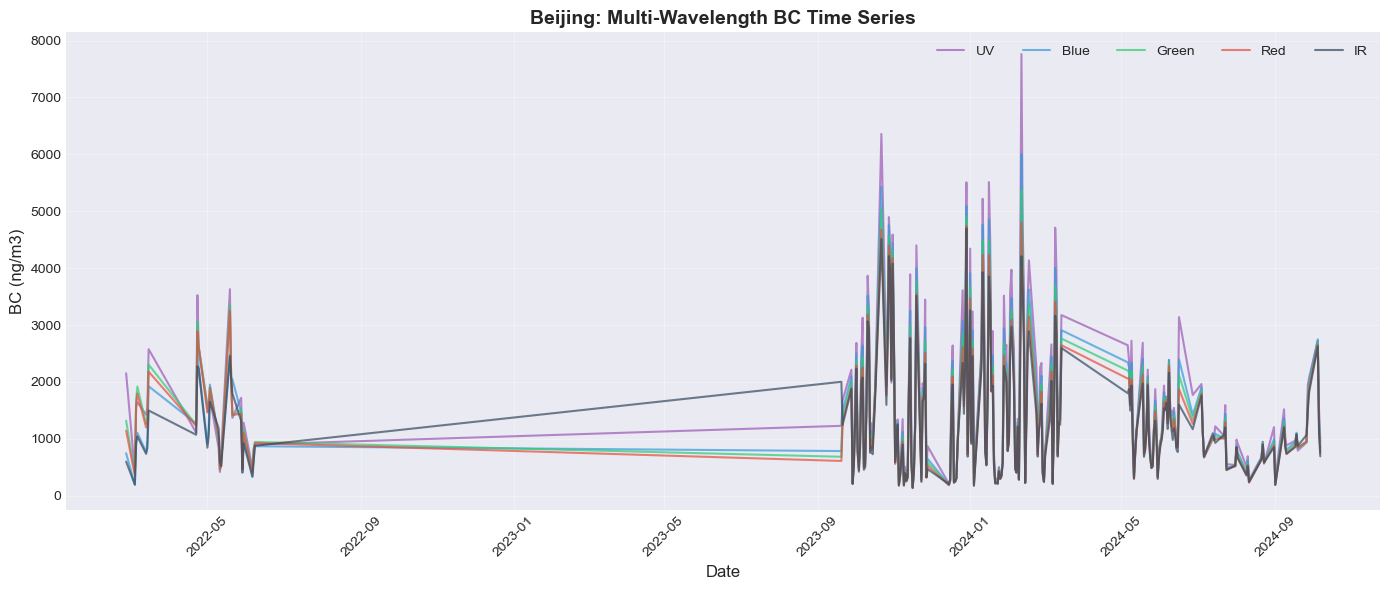

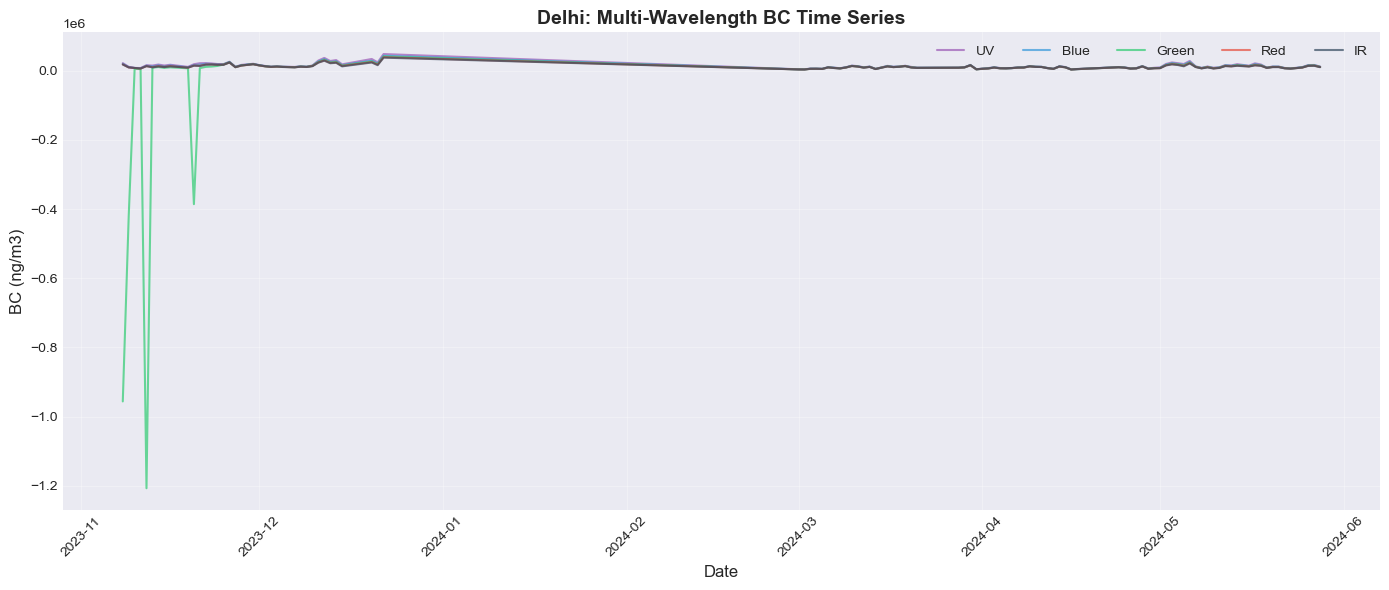

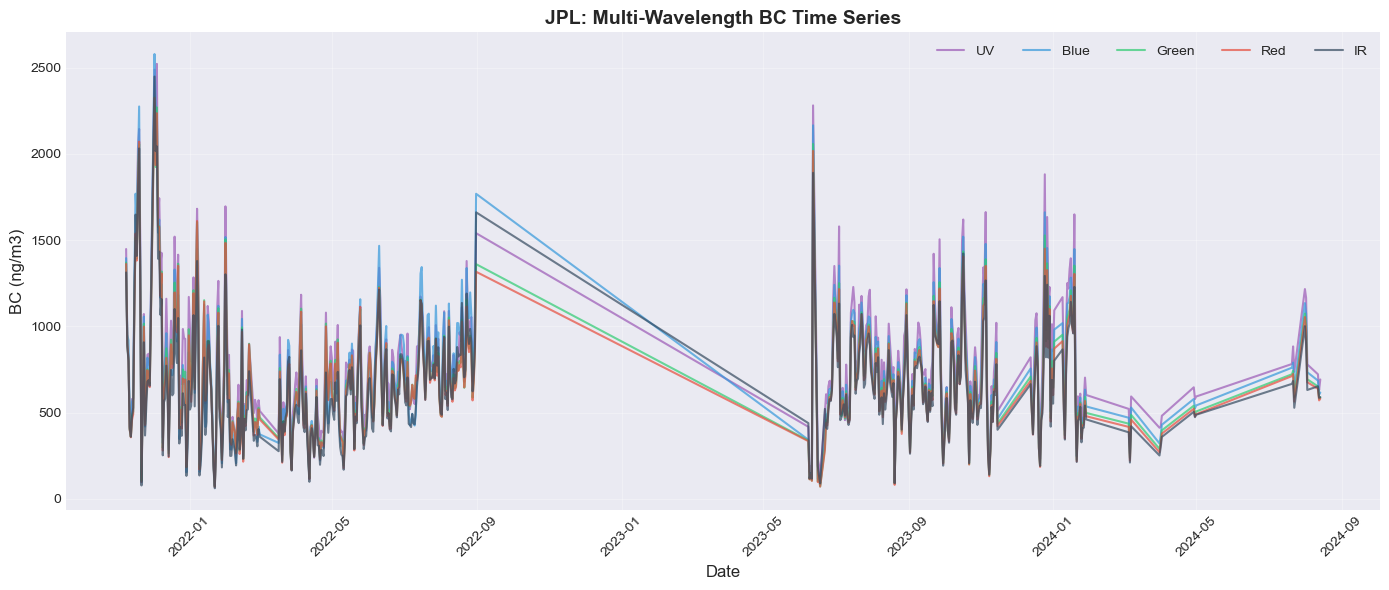

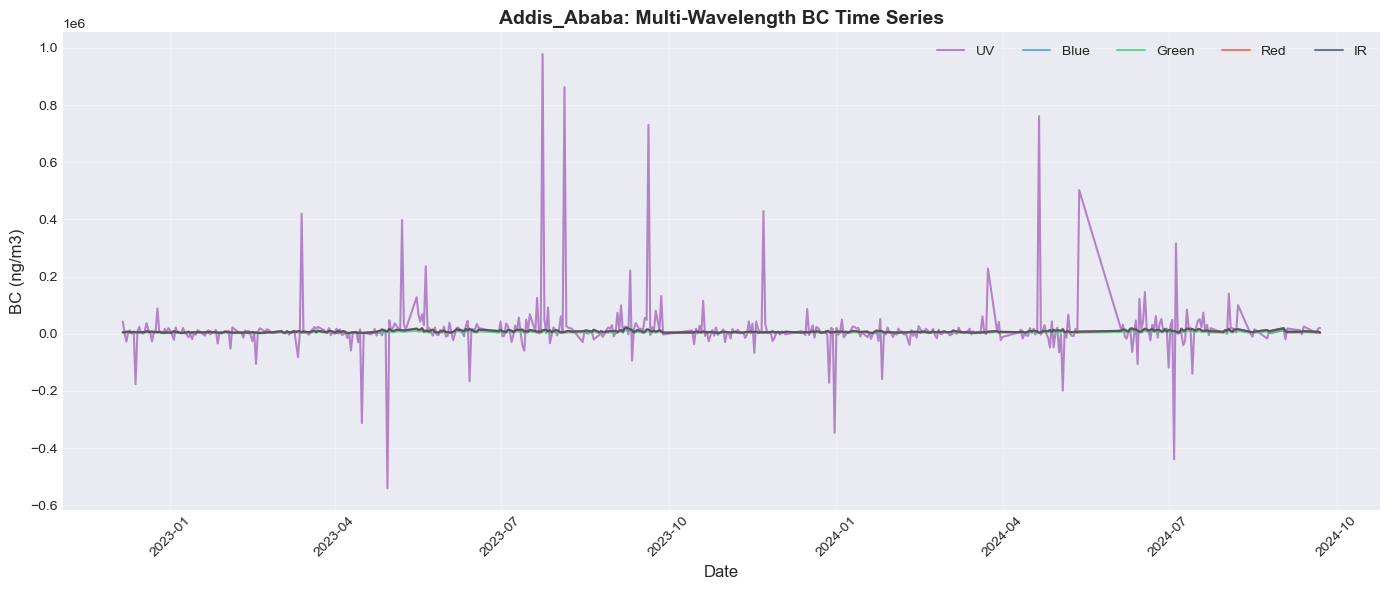

In [42]:
# Multi-wavelength time series for each site
print("\n" + "="*80)
print("Multi-Wavelength BC Time Series by Site")
print("="*80)

for site_name, df in aethalometer_data.items():
    config = SITES[site_name]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    has_data = False
    for wl in wavelengths:
        col = f'{wl} BCc'
        if col in df.columns:
            valid_data = df[df[col].notna()].copy()
            if len(valid_data) > 0:
                ax.plot(valid_data['day_9am'], valid_data[col],
                        color=wavelength_colors[wl], alpha=0.7, linewidth=1.5,
                        label=f'{wl}')
                has_data = True
    
    if not has_data:
        print(f"{site_name}: No wavelength data available")
        plt.close()
        continue
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('BC (ng/m3)', fontsize=12)
    ax.set_title(f'{site_name}: Multi-Wavelength BC Time Series', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, ncol=5)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

---

## 7b. Excluded Dates: Multi-Wavelength BC Visualization

For each site, show the BC values at all wavelengths on the excluded dates. This helps understand if the exclusion pattern is consistent across wavelengths or wavelength-specific.

### 7a. Wavelength BC Correlation, Distribution & Boxplots

For each site, analyze the relationships between BC measurements at different wavelengths:
- **Correlation Matrix**: Shows how well BC values correlate across wavelengths (high correlation expected)
- **Distribution Histogram**: Overlaid histograms showing the distribution of BC values at each wavelength
- **Boxplot**: Comparison of BC distributions showing median, quartiles, and outliers for each wavelength


Wavelength BC Analysis: Correlation, Distribution & Boxplots

Beijing: Wavelength BC Analysis
  Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']
  Complete cases (all wavelengths): 222


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_49393/2941541015.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


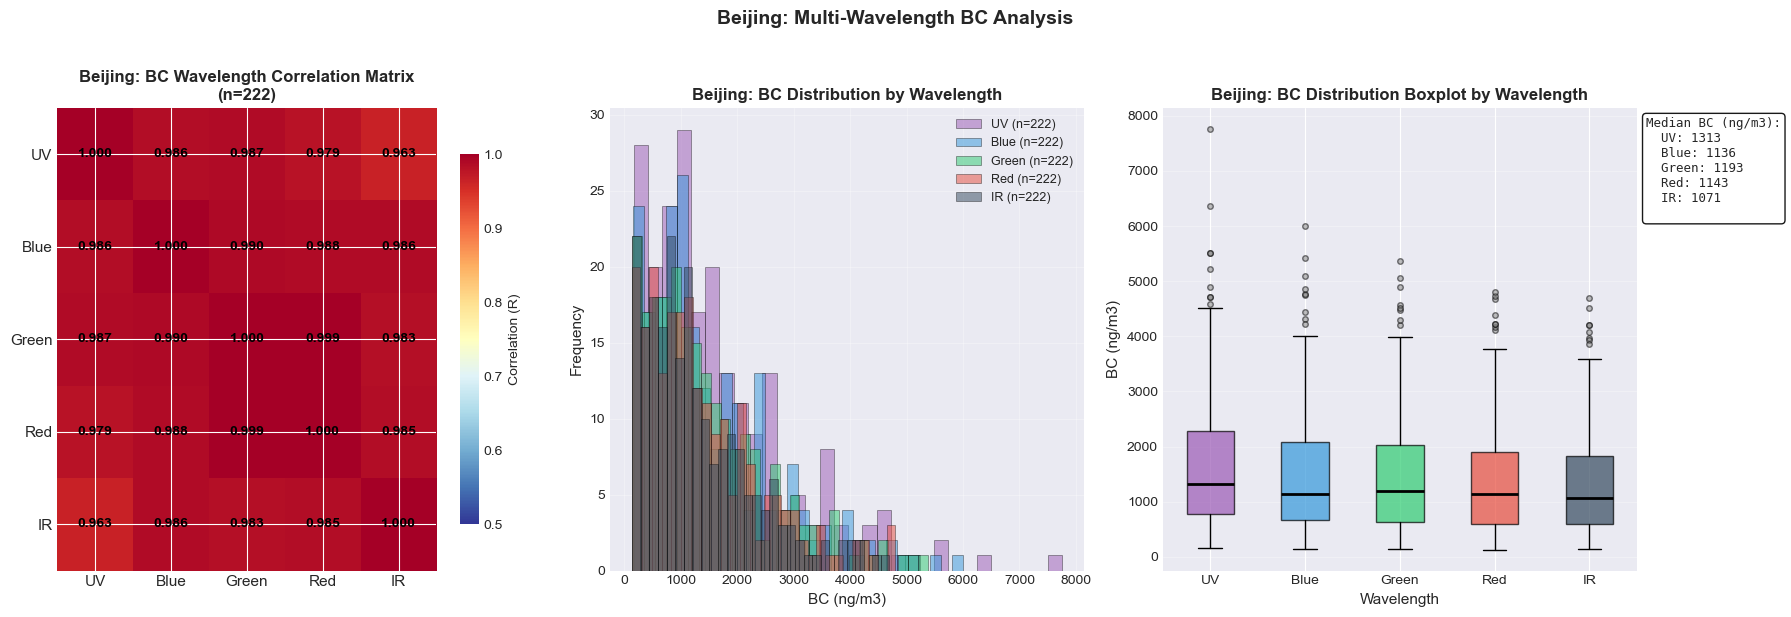


  Correlation Matrix (R values):
          UV   Blue  Green    Red     IR
UV     1.000  0.986  0.987  0.979  0.963
Blue   0.986  1.000  0.990  0.988  0.986
Green  0.987  0.990  1.000  0.999  0.983
Red    0.979  0.988  0.999  1.000  0.985
IR     0.963  0.986  0.983  0.985  1.000

  Summary Statistics (ng/m3):
  Wavelength          n       Mean     Median        Std        Min        Max
  ----------------------------------------------------------------------
  UV                222     1686.7     1312.9     1301.9      167.7     7762.4
  Blue              222     1509.9     1135.6     1150.3      147.2     6008.2
  Green             222     1465.0     1193.5     1085.5      136.7     5371.6
  Red               222     1395.9     1142.5     1025.3      131.1     4803.9
  IR                222     1318.2     1071.3      964.9      142.4     4697.1

Delhi: Wavelength BC Analysis
  Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']
  Complete cases (all wavelengths): 113


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_49393/2941541015.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


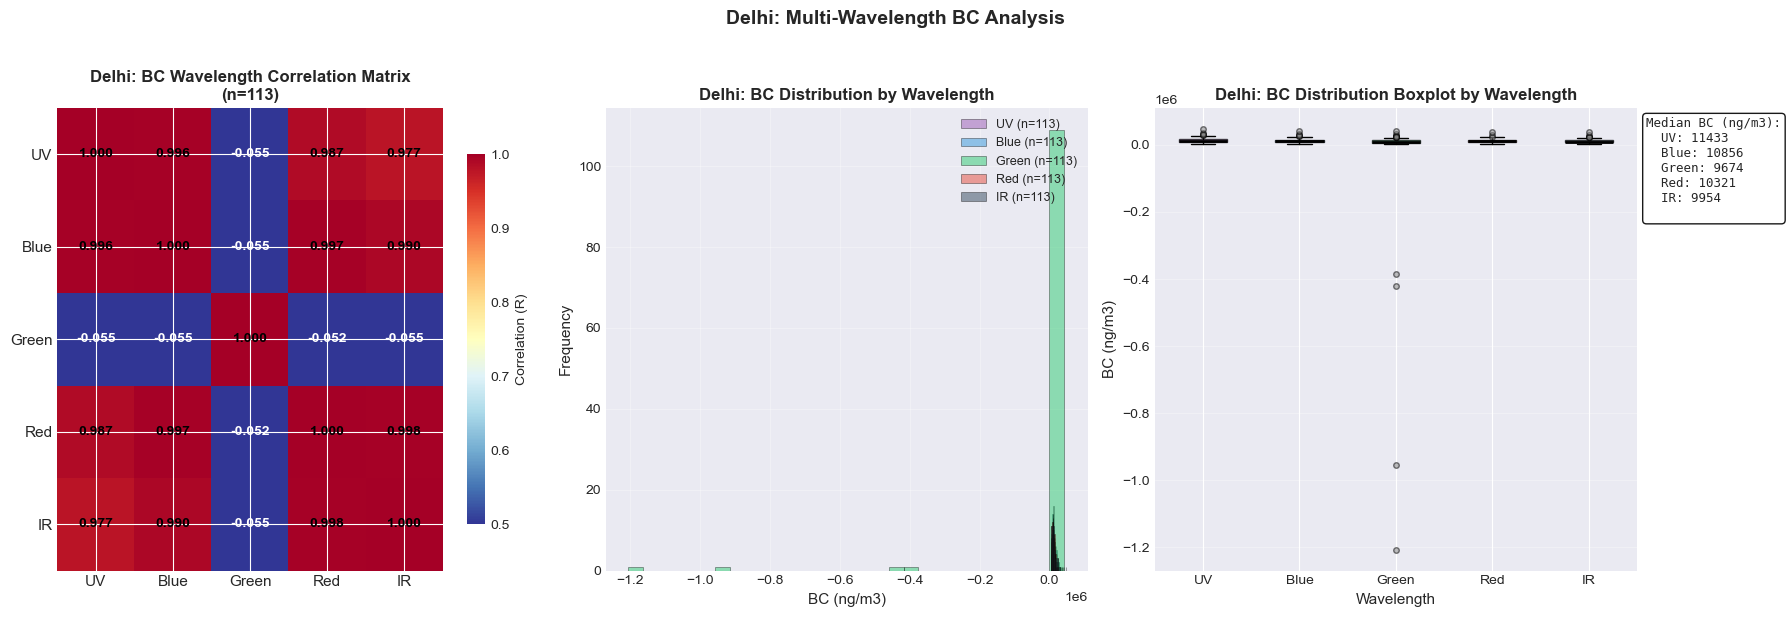


  Correlation Matrix (R values):
          UV   Blue  Green    Red     IR
UV     1.000  0.996 -0.055  0.987  0.977
Blue   0.996  1.000 -0.055  0.997  0.990
Green -0.055 -0.055  1.000 -0.052 -0.055
Red    0.987  0.997 -0.052  1.000  0.998
IR     0.977  0.990 -0.055  0.998  1.000

  Summary Statistics (ng/m3):
  Wavelength          n       Mean     Median        Std        Min        Max
  ----------------------------------------------------------------------
  UV                113    13198.3    11433.2     7319.2     3372.6    47728.8
  Blue              113    12133.3    10856.0     6426.9     3142.9    42760.2
  Green             113   -15530.5     9674.2   154872.9 -1206792.7    40730.1
  Red               113    11218.3    10321.4     5681.8     3041.9    38602.9
  IR                113    11025.9     9954.3     5412.6     3109.2    37307.1

JPL: Wavelength BC Analysis
  Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']
  Complete cases (all wavelengths): 489


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_49393/2941541015.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


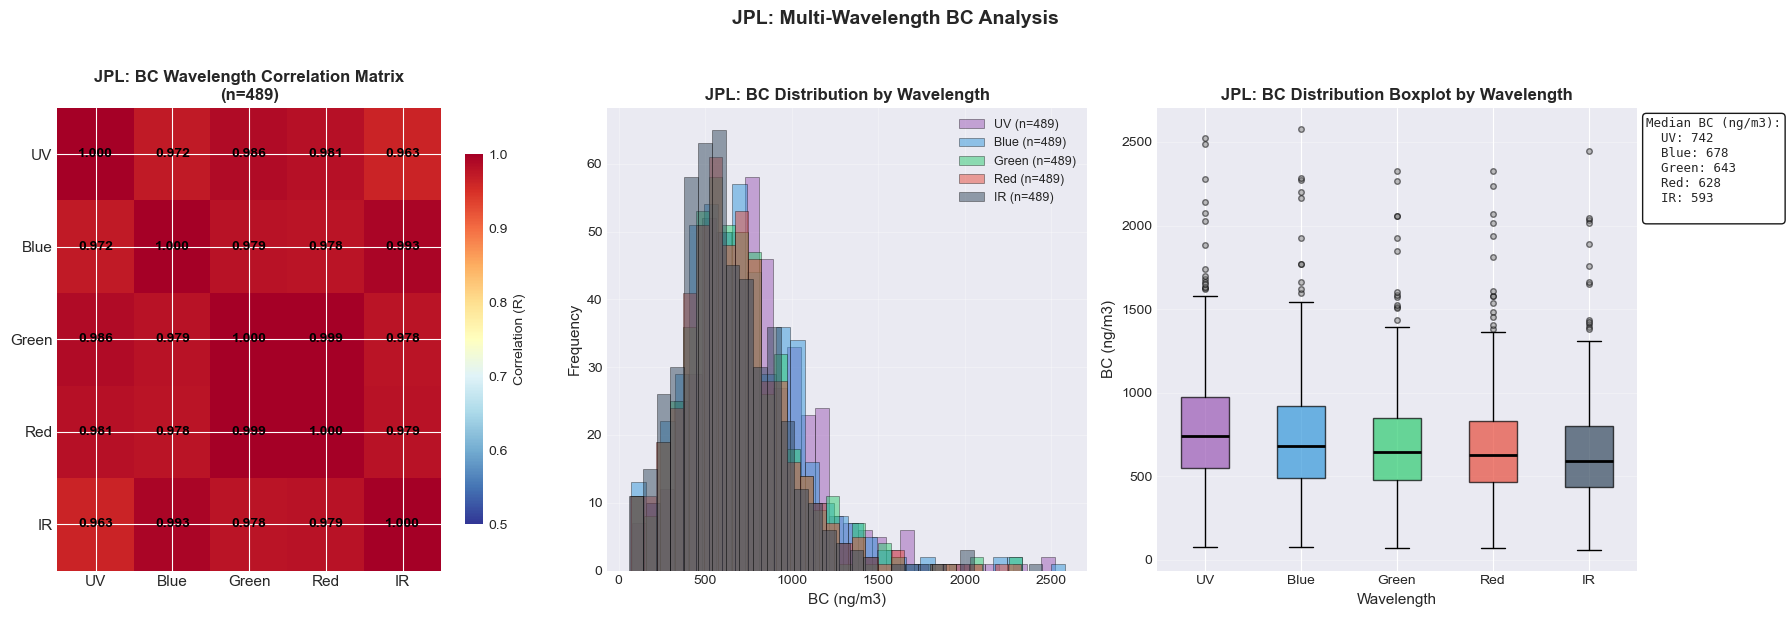


  Correlation Matrix (R values):
          UV   Blue  Green    Red     IR
UV     1.000  0.972  0.986  0.981  0.963
Blue   0.972  1.000  0.979  0.978  0.993
Green  0.986  0.979  1.000  0.999  0.978
Red    0.981  0.978  0.999  1.000  0.979
IR     0.963  0.993  0.978  0.979  1.000

  Summary Statistics (ng/m3):
  Wavelength          n       Mean     Median        Std        Min        Max
  ----------------------------------------------------------------------
  UV                489      784.5      741.7      356.1       76.8     2521.1
  Blue              489      726.0      678.5      352.6       73.6     2578.3
  Green             489      691.1      643.0      324.2       70.9     2327.6
  Red               489      676.5      628.1      321.0       68.9     2323.6
  IR                489      640.9      592.6      314.3       61.1     2447.7

Addis_Ababa: Wavelength BC Analysis
  Available wavelengths: ['UV', 'Blue', 'Green', 'Red', 'IR']
  Complete cases (all wavelengths): 515


/var/folders/7q/3m0wqxpd2719blfvfs1_4vpr0000gn/T/ipykernel_49393/2941541015.py:103: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,


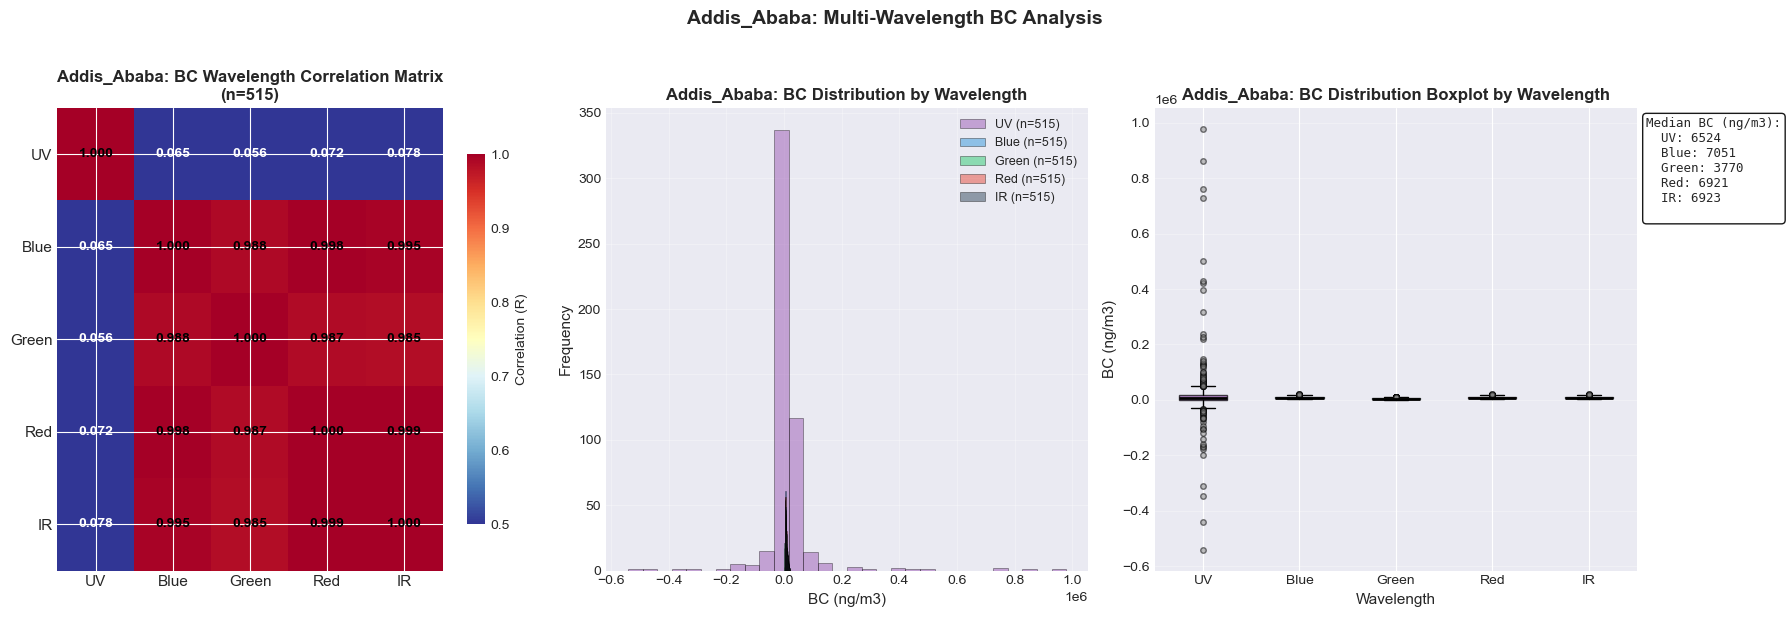


  Correlation Matrix (R values):
          UV   Blue  Green    Red     IR
UV     1.000  0.065  0.056  0.072  0.078
Blue   0.065  1.000  0.988  0.998  0.995
Green  0.056  0.988  1.000  0.987  0.985
Red    0.072  0.998  0.987  1.000  0.999
IR     0.078  0.995  0.985  0.999  1.000

  Summary Statistics (ng/m3):
  Wavelength          n       Mean     Median        Std        Min        Max
  ----------------------------------------------------------------------
  UV                515    15574.0     6524.0    98927.4  -540331.7   978253.1
  Blue              515     7987.6     7051.1     3700.6     2489.1    22256.0
  Green             515     4333.8     3770.4     2059.1     1008.8    12059.7
  Red               515     7860.4     6921.1     3589.2     2513.2    21223.4
  IR                515     7917.7     6923.1     3596.6     2606.3    21008.3


In [43]:
# Wavelength Analysis: Correlation Matrix, Histogram, and Boxplot for each site
print("\n" + "="*80)
print("Wavelength BC Analysis: Correlation, Distribution & Boxplots")
print("="*80)

for site_name, df in aethalometer_data.items():
    config = SITES[site_name]
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Wavelength BC Analysis")
    print(f"{'='*60}")
    
    # Collect BC data for all available wavelengths
    bc_data = {}
    for wl in wavelengths:
        col = f'{wl} BCc'
        if col in df.columns:
            valid_data = df[col].dropna()
            if len(valid_data) > 0:
                bc_data[wl] = valid_data
    
    if len(bc_data) < 2:
        print(f"  Insufficient wavelength data (need at least 2 wavelengths)")
        continue
    
    # Create DataFrame for correlation analysis (only rows with all wavelengths)
    bc_df = pd.DataFrame({wl: df[f'{wl} BCc'] for wl in bc_data.keys()})
    bc_df_complete = bc_df.dropna()
    
    print(f"  Available wavelengths: {list(bc_data.keys())}")
    print(f"  Complete cases (all wavelengths): {len(bc_df_complete)}")
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # ========== 1. Correlation Matrix Heatmap ==========
    ax1 = axes[0]
    
    if len(bc_df_complete) >= 3:
        corr_matrix = bc_df_complete.corr()
        
        # Create heatmap
        im = ax1.imshow(corr_matrix.values, cmap='RdYlBu_r', vmin=0.5, vmax=1.0, aspect='auto')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
        cbar.set_label('Correlation (R)', fontsize=10)
        
        # Set ticks and labels
        ax1.set_xticks(range(len(corr_matrix.columns)))
        ax1.set_yticks(range(len(corr_matrix.columns)))
        ax1.set_xticklabels(corr_matrix.columns, fontsize=11)
        ax1.set_yticklabels(corr_matrix.columns, fontsize=11)
        
        # Add correlation values as text
        for i in range(len(corr_matrix)):
            for j in range(len(corr_matrix)):
                val = corr_matrix.iloc[i, j]
                text_color = 'white' if val < 0.75 else 'black'
                ax1.text(j, i, f'{val:.3f}', ha='center', va='center', 
                        fontsize=10, fontweight='bold', color=text_color)
        
        ax1.set_title(f'{site_name}: BC Wavelength Correlation Matrix\n(n={len(bc_df_complete)})', 
                     fontsize=12, fontweight='bold')
    else:
        ax1.text(0.5, 0.5, 'Insufficient complete cases\nfor correlation matrix', 
                ha='center', va='center', fontsize=12, transform=ax1.transAxes)
        ax1.set_title(f'{site_name}: BC Wavelength Correlation Matrix', 
                     fontsize=12, fontweight='bold')
    
    # ========== 2. BC Distribution Histogram ==========
    ax2 = axes[1]
    
    # Plot histogram for each wavelength
    for wl in wavelengths:
        if wl in bc_data:
            data = bc_data[wl]
            ax2.hist(data, bins=30, alpha=0.5, color=wavelength_colors[wl], 
                    label=f'{wl} (n={len(data)})', edgecolor='black', linewidth=0.5)
    
    ax2.set_xlabel('BC (ng/m3)', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title(f'{site_name}: BC Distribution by Wavelength', 
                 fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # ========== 3. BC Distribution Boxplot ==========
    ax3 = axes[2]
    
    # Prepare data for boxplot
    boxplot_data = []
    boxplot_labels = []
    boxplot_colors = []
    
    for wl in wavelengths:
        if wl in bc_data:
            boxplot_data.append(bc_data[wl].values)
            boxplot_labels.append(wl)
            boxplot_colors.append(wavelength_colors[wl])
    
    # Create boxplot
    bp = ax3.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True,
                     medianprops=dict(color='black', linewidth=2),
                     flierprops=dict(marker='o', markerfacecolor='gray', 
                                    markersize=4, alpha=0.5))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], boxplot_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_xlabel('Wavelength', fontsize=11)
    ax3.set_ylabel('BC (ng/m3)', fontsize=11)
    ax3.set_title(f'{site_name}: BC Distribution Boxplot by Wavelength', 
                 fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add statistics annotation
    stats_text = "Median BC (ng/m3):\n"
    for wl in wavelengths:
        if wl in bc_data:
            median_val = bc_data[wl].median()
            stats_text += f"  {wl}: {median_val:.0f}\n"
    
    ax3.text(1.02, 0.98, stats_text, transform=ax3.transAxes, fontsize=9,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.suptitle(f'{site_name}: Multi-Wavelength BC Analysis', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print correlation summary
    if len(bc_df_complete) >= 3:
        print(f"\n  Correlation Matrix (R values):")
        print(corr_matrix.round(3).to_string())
        
        # Print summary statistics
        print(f"\n  Summary Statistics (ng/m3):")
        print(f"  {'Wavelength':<12s} {'n':>8s} {'Mean':>10s} {'Median':>10s} {'Std':>10s} {'Min':>10s} {'Max':>10s}")
        print("  " + "-" * 70)
        for wl in wavelengths:
            if wl in bc_data:
                data = bc_data[wl]
                print(f"  {wl:<12s} {len(data):>8d} {data.mean():>10.1f} {data.median():>10.1f} "
                      f"{data.std():>10.1f} {data.min():>10.1f} {data.max():>10.1f}")

---

## 8. Research Questions Summary

### Key Research Questions

1. **How well do aethalometer BC measurements correlate with filter-based methods?**
   - FTIR EC vs Aethalometer IR BCc
   - HIPS Fabs vs Aethalometer IR BCc (absorption vs absorption)
   - Site-specific variations

2. **Does iron contamination affect HIPS or FTIR EC measurements?**
   - Iron gradient plots show if high-iron samples deviate from regression
   - Potential interference mechanism

3. **How does the smooth/raw BC difference affect data quality?**
   - Threshold analysis for FTIR EC comparison
   - Threshold analysis for HIPS comparison (absorption-absorption)
   - Optimal threshold selection

4. **How does the flow fix impact aethalometer-filter agreement?**
   - Before/after analysis for Beijing and JPL
   - R^2 and slope changes

5. **What does wavelength dependence tell us about BC sources?**
   - UV/IR ratio across sites
   - Seasonal/temporal variations
   - Biomass burning vs fossil fuel contributions

In [44]:
# Comprehensive Summary Statistics
print("="*100)
print("COMPREHENSIVE SUMMARY: MULTI-SITE AETHALOMETER VS FILTER ANALYSIS")
print("="*100)

# Calculate stats for summary
site_stats = {}
for site_name, matched_df in all_matched_data.items():
    stats = calculate_regression_stats(
        matched_df['aeth_bc'].values,
        matched_df['filter_ec'].values
    )
    if stats:
        site_stats[site_name] = stats

print("\n" + "-"*80)
print("1. AETHALOMETER VS FTIR EC CORRELATION")
print("-"*80)
print(f"{'Site':<15s} {'n':>8s} {'R^2':>10s} {'Slope':>10s} {'Intercept':>12s}")
print("-" * 60)
for site_name, stats in site_stats.items():
    print(f"{site_name:<15s} {stats['n']:>8d} {stats['r_squared']:>10.3f} "
          f"{stats['slope']:>10.3f} {stats['intercept']:>12.2f}")

print("\n" + "-"*80)
print("2. WAVELENGTH DEPENDENCE (UV/IR Ratio)")
print("-"*80)
print(f"{'Site':<15s} {'n':>8s} {'Mean UV/IR':>12s} {'Interpretation':>25s}")
print("-" * 65)
for site_name, results in wavelength_results.items():
    ratio = results['mean_ratio']
    if ratio > 1.1:
        interp = "Biomass burning"
    elif ratio < 0.9:
        interp = "Fossil fuel"
    else:
        interp = "Mixed sources"
    print(f"{site_name:<15s} {results['n']:>8d} {ratio:>12.3f} {interp:>25s}")

print("\n" + "-"*80)
print("3. KEY FINDINGS")
print("-"*80)
print("""
- Addis Ababa shows highest R^2 for FTIR EC comparison (likely cleanest conditions)
- Iron gradient plots may reveal potential interference in dusty conditions
- Smooth/raw threshold filtering can improve correlation for sites with noisy data
- Flow fix periods show clear improvement in agreement at Beijing and JPL
- UV/IR ratios vary significantly across sites, indicating different source mixtures
""")

print("\n" + "-"*80)
print("4. OPEN QUESTIONS / NEXT STEPS")
print("-"*80)
print("""
- Investigate why HIPS slopes differ significantly from 1:1 at some sites
- Explore seasonal patterns in UV/IR ratios
- Consider MAC value optimization for each site
- Investigate outlier mechanisms (contamination, instrument issues)
- Add more sites as data becomes available
""")

COMPREHENSIVE SUMMARY: MULTI-SITE AETHALOMETER VS FILTER ANALYSIS

--------------------------------------------------------------------------------
1. AETHALOMETER VS FTIR EC CORRELATION
--------------------------------------------------------------------------------
Site                   n        R^2      Slope    Intercept
------------------------------------------------------------
Beijing               65      0.197      0.556       817.57
Delhi                 24      0.558      0.837     -1194.50
JPL                   42      0.022      0.070       575.60
Addis_Ababa          181      0.731      0.637        49.30

--------------------------------------------------------------------------------
2. WAVELENGTH DEPENDENCE (UV/IR Ratio)
--------------------------------------------------------------------------------
Site                   n   Mean UV/IR            Interpretation
-----------------------------------------------------------------
Beijing              222        1.286  

EXCLUDED DATES: Multi-Wavelength BC Values

This shows BC values at all wavelengths for excluded sample dates.
Red vertical lines mark the excluded dates on the time series.


Beijing: Excluded Dates Analysis

Excluded dates (1):
  - 2022-05-15: Extreme aethalometer BC outlier - affects slope significantl...


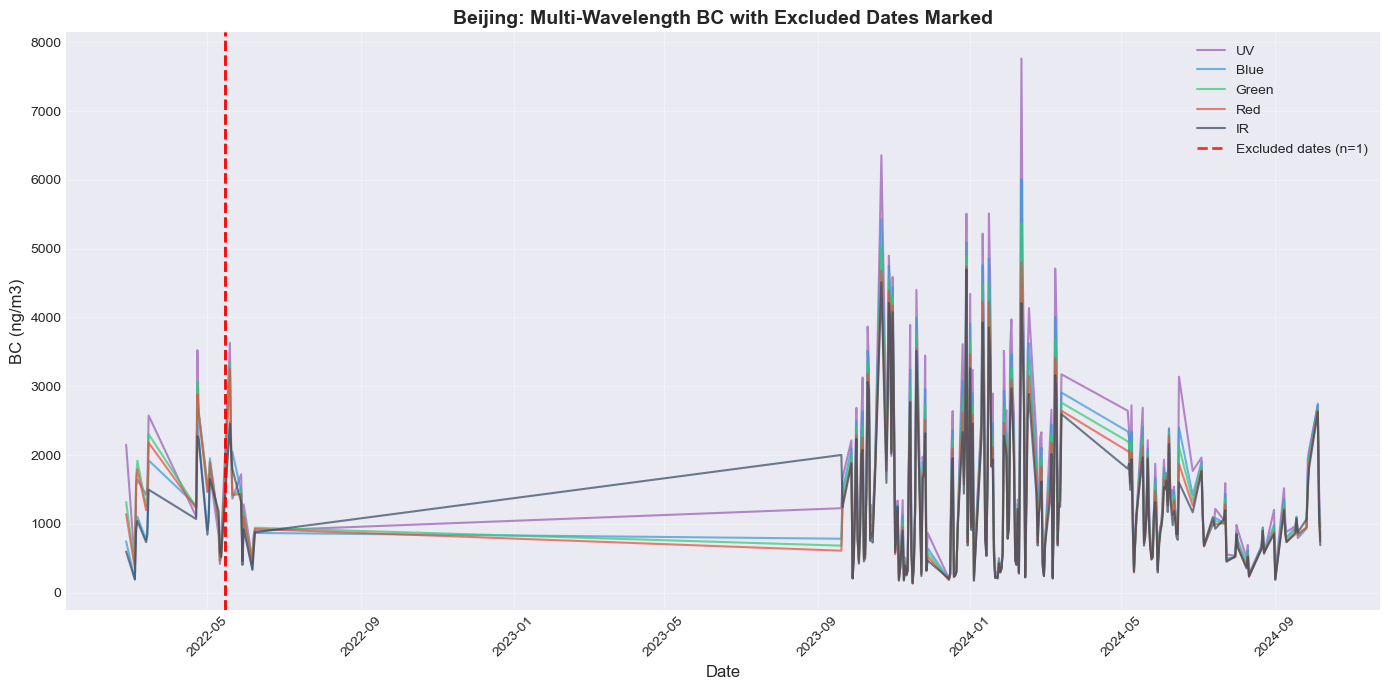


BC values at excluded dates:
Date                  UV        Blue       Green         Red          IR
------------------------------------------------------------------------
2022-05-15   No matching aethalometer data

UV/IR ratios at excluded dates:

Delhi: Excluded Dates Analysis

Excluded dates (2):
  - 2023-01-10: High aethalometer (~10000) with low FTIR EC (~2000) - measur...
  - 2023-01-15: High aethalometer (~9500) with low FTIR EC (~2500) - measure...


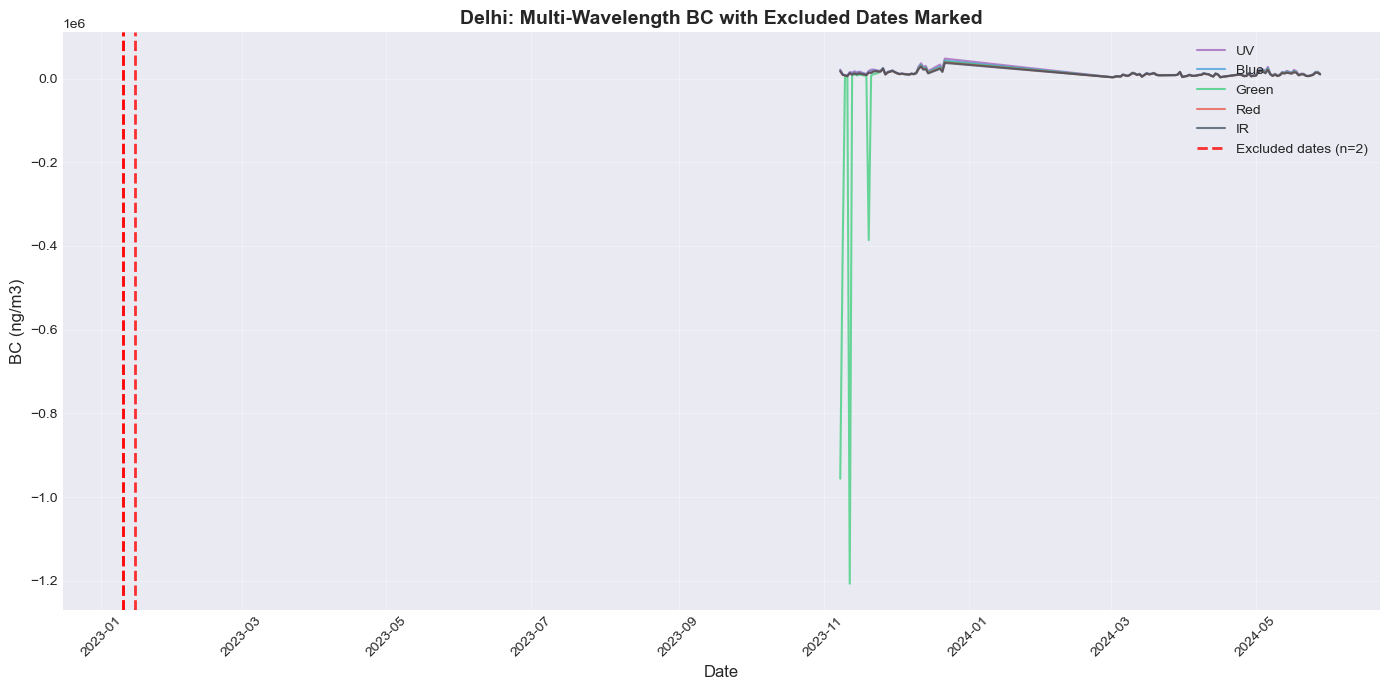


BC values at excluded dates:
Date                  UV        Blue       Green         Red          IR
------------------------------------------------------------------------
2023-01-10   No matching aethalometer data
2023-01-15   No matching aethalometer data

UV/IR ratios at excluded dates:

JPL: Excluded Dates Analysis

Excluded dates (2):
  - 2022-06-20: Pre-flow-fix period - aethalometer BC > 1700 threshold...
  - 2022-07-05: FTIR EC > 1000 threshold - likely contamination...


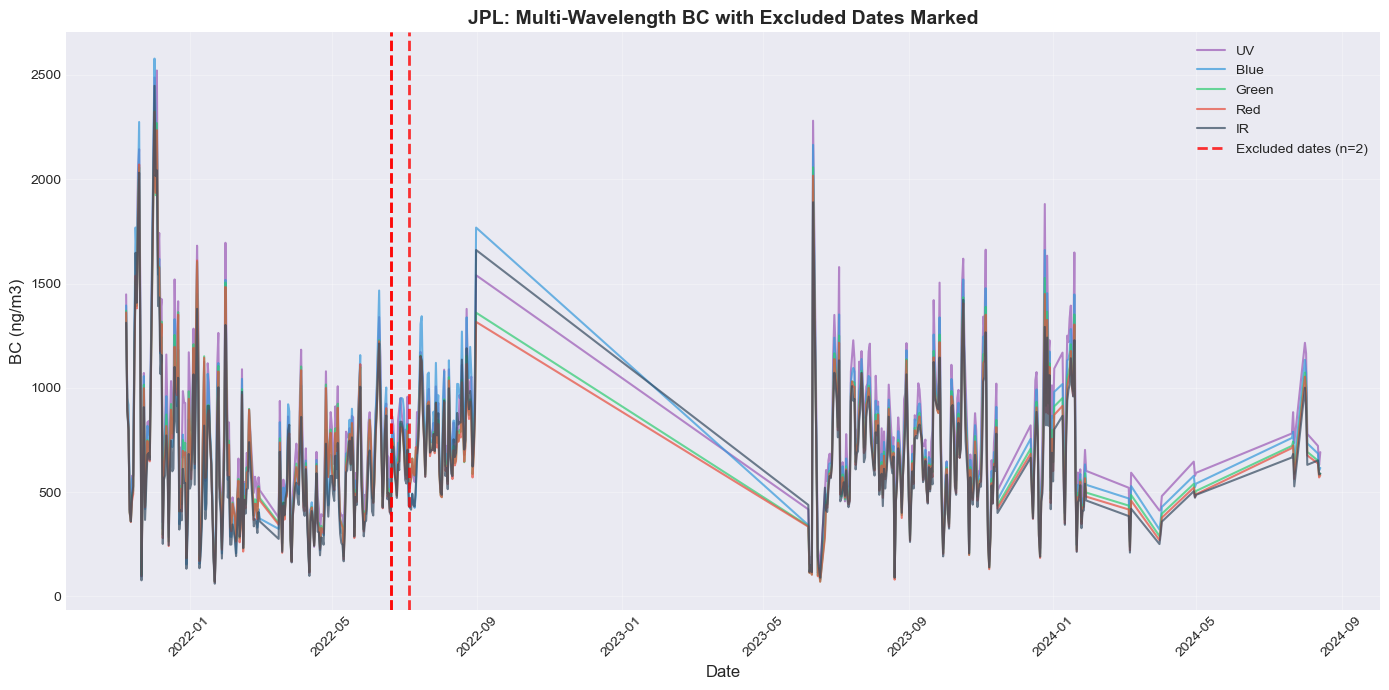


BC values at excluded dates:
Date                  UV        Blue       Green         Red          IR
------------------------------------------------------------------------
2022-06-20         639.4       562.9       534.0       518.5       505.2
2022-07-05         691.6       582.2       633.8       626.3       521.8

UV/IR ratios at excluded dates:
  2022-06-20: UV/IR = 1.266
  2022-07-05: UV/IR = 1.325

Addis_Ababa: No excluded samples defined


In [45]:
# Visualize excluded dates across all wavelengths
# Shows BC at all wavelengths for dates that were excluded

print("="*80)
print("EXCLUDED DATES: Multi-Wavelength BC Values")
print("="*80)
print("\nThis shows BC values at all wavelengths for excluded sample dates.")
print("Red vertical lines mark the excluded dates on the time series.")
print()

for site_name in SITES:
    if site_name not in aethalometer_data:
        continue
    
    config = SITES[site_name]
    df_aeth = aethalometer_data[site_name]
    
    # Get excluded dates for this site from EXCLUDED_SAMPLES
    excluded_list = EXCLUDED_SAMPLES.get(site_name, [])
    
    if len(excluded_list) == 0:
        print(f"\n{site_name}: No excluded samples defined")
        continue
    
    print(f"\n{'='*60}")
    print(f"{site_name}: Excluded Dates Analysis")
    print(f"{'='*60}")
    
    # Convert excluded dates to datetime
    excluded_dates = [pd.to_datetime(excl['date']) for excl in excluded_list]
    
    # Print excluded dates info
    print(f"\nExcluded dates ({len(excluded_dates)}):")
    for excl in excluded_list:
        print(f"  - {excl['date']}: {excl['reason'][:60]}...")
    
    # Create time series plot with excluded dates marked
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot all wavelengths
    has_data = False
    for wl in wavelengths:
        col = f'{wl} BCc'
        if col in df_aeth.columns:
            valid_data = df_aeth[df_aeth[col].notna()].copy()
            if len(valid_data) > 0:
                ax.plot(valid_data['day_9am'], valid_data[col],
                        color=wavelength_colors[wl], alpha=0.7, linewidth=1.5,
                        label=f'{wl}')
                has_data = True
    
    if not has_data:
        print(f"  No wavelength data available")
        plt.close()
        continue
    
    # Mark excluded dates with vertical red lines
    ymin, ymax = ax.get_ylim()
    for excl_date in excluded_dates:
        ax.axvline(x=excl_date, color='red', linestyle='--', linewidth=2, alpha=0.8)
    
    # Add a single legend entry for excluded dates
    ax.axvline(x=excluded_dates[0], color='red', linestyle='--', linewidth=2, 
               alpha=0.8, label=f'Excluded dates (n={len(excluded_dates)})')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('BC (ng/m3)', fontsize=12)
    ax.set_title(f'{site_name}: Multi-Wavelength BC with Excluded Dates Marked', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create table of BC values at excluded dates for each wavelength
    print(f"\nBC values at excluded dates:")
    print(f"{'Date':<12s}", end='')
    for wl in wavelengths:
        print(f"{wl:>12s}", end='')
    print()
    print("-" * (12 + 12 * len(wavelengths)))
    
    for excl_date in excluded_dates:
        # Find matching aethalometer data (within 1 day tolerance)
        date_match = df_aeth[
            (df_aeth['day_9am'] >= excl_date - pd.Timedelta(days=1)) &
            (df_aeth['day_9am'] <= excl_date + pd.Timedelta(days=1))
        ]
        
        if len(date_match) > 0:
            print(f"{str(excl_date.date()):<12s}", end='')
            for wl in wavelengths:
                col = f'{wl} BCc'
                if col in date_match.columns and date_match[col].notna().any():
                    val = date_match[col].mean()
                    print(f"{val:>12.1f}", end='')
                else:
                    print(f"{'--':>12s}", end='')
            print()
        else:
            print(f"{str(excl_date.date()):<12s} No matching aethalometer data")
    
    # Calculate and show wavelength ratios for excluded dates
    print(f"\nUV/IR ratios at excluded dates:")
    for excl_date in excluded_dates:
        date_match = df_aeth[
            (df_aeth['day_9am'] >= excl_date - pd.Timedelta(days=1)) &
            (df_aeth['day_9am'] <= excl_date + pd.Timedelta(days=1))
        ]
        
        if len(date_match) > 0:
            if 'UV BCc' in date_match.columns and 'IR BCc' in date_match.columns:
                uv_val = date_match['UV BCc'].mean()
                ir_val = date_match['IR BCc'].mean()
                if pd.notna(uv_val) and pd.notna(ir_val) and ir_val > 0:
                    ratio = uv_val / ir_val
                    print(f"  {excl_date.date()}: UV/IR = {ratio:.3f}")
                else:
                    print(f"  {excl_date.date()}: UV/IR = N/A")
            else:
                print(f"  {excl_date.date()}: Missing UV or IR data")

---

## Notes

### Section 3: Iron Gradient Plots
- Uses plasma colormap to visualize iron concentration
- Look for systematic deviations at high iron values
- May indicate dust interference

### Section 4: Multi-Site Comparisons
- All sites plotted together for direct comparison
- Overall regression line shows combined trend
- Individual site colors maintained

### Section 5: HIPS vs Aethalometer (Absorption-Absorption)
- More direct comparison than FTIR EC
- Both methods measure light absorption
- Threshold analysis similar to FTIR comparison

### Section 6: Flow Fix Analysis
- Beijing and JPL had known flow issues early on
- Before/after separation shows improvement
- Useful for understanding data quality evolution

### Section 7: Wavelength Dependence
- UV/IR ratio indicates source type
- Addis Ababa expected to show biomass burning signature
- Delhi and Beijing may show fossil fuel dominance

### How to Update This Notebook
1. Add new outliers to `scripts/outliers.py`
2. Modify thresholds in `scripts/config.py`
3. Restart kernel and re-run all cells